

**Authors: Lidor Erez 318661444, Daniel Mizrachi 208727230, Dvir Rehavi 207206624**


# Libraries

Install if you need:

In [8]:
# !pip install plotly
# !pip install hyperopt

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.renderers.default='svg'

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope

In [3]:
train = pd.read_csv("https://raw.githubusercontent.com/LidorErez98/Sberbank_ML/main/Data/train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/LidorErez98/Sberbank_ML/main/Data/test.csv")

# Baseline Models

In [11]:
cols = ['full_sq', 'life_sq', 'floor', 'max_floor', 'material',
'build_year', 'num_room', 'kitch_sq', 'state', 'product_type', 'sub_area','price_doc']
train_cp = train.copy(deep=True)[cols]
test_cp = test.copy(deep=True)[cols[:-1]]

## Missing Values Handling

In [12]:
train_cp.isna().sum()

full_sq             0
life_sq          6383
floor             167
max_floor        9572
material         9572
build_year      13605
num_room         9572
kitch_sq         9572
state           13559
product_type        0
sub_area            0
price_doc           0
dtype: int64

In [13]:
test_cp.isna().sum()

full_sq            0
life_sq         1176
floor              0
max_floor          0
material           0
build_year      1049
num_room           0
kitch_sq           0
state            694
product_type      33
sub_area           0
dtype: int64

In [14]:
# Remove rows with more than 5 missing values.
train_cp = train_cp.loc[train_cp.isna().sum(axis=1) < 5]


# Handle missing values in build year 
train_cp.loc[(train_cp['build_year'] == 0) | (train_cp['build_year'] == 1), 'build_year'] = None
train_cp['build_year'].fillna(train_cp['build_year'].median(numeric_only=True), inplace=True)

test_cp.loc[(test_cp['build_year'] == 0) | (test_cp['build_year'] == 1), 'build_year'] = None
test_cp['build_year'].fillna(test_cp['build_year'].median(numeric_only=True), inplace=True)

# Handle Missing values in life_sq
train_cp['life_sq'].fillna(train_cp['life_sq'].mean(numeric_only=True), inplace=True)
test_cp['life_sq'].fillna(test_cp['life_sq'].mean(numeric_only=True), inplace=True)

# Handle Missing values in categorical 
train_cp['state'].fillna(train_cp['state'].mode()[0], inplace=True)
test_cp['state'].fillna(test_cp['state'].mode()[0],inplace=True)

train_cp['material'].fillna(train_cp['material'].mode()[0], inplace=True)
test_cp['material'].fillna(test_cp['material'].mode()[0],inplace=True)

test_cp['product_type'].fillna(test_cp['product_type'].mode()[0],inplace=True)


# Check how many NAS there are:

print(f'Test data:\n {test_cp.isna().sum()}  \n\n Train Data: \n{train_cp.isna().sum()}')

Test data:
 full_sq         0
life_sq         0
floor           0
max_floor       0
material        0
build_year      0
num_room        0
kitch_sq        0
state           0
product_type    0
sub_area        0
dtype: int64  

 Train Data: 
full_sq         0
life_sq         0
floor           0
max_floor       0
material        0
build_year      0
num_room        0
kitch_sq        0
state           0
product_type    0
sub_area        0
price_doc       0
dtype: int64


## Data Types Handling

In [15]:
train_cp.dtypes

full_sq           int64
life_sq         float64
floor           float64
max_floor       float64
material        float64
build_year      float64
num_room        float64
kitch_sq        float64
state           float64
product_type     object
sub_area         object
price_doc         int64
dtype: object

In [16]:
test_cp.dtypes

full_sq         float64
life_sq         float64
floor             int64
max_floor         int64
material          int64
build_year      float64
num_room          int64
kitch_sq        float64
state           float64
product_type     object
sub_area         object
dtype: object

In [17]:
categorical_cols = ['state','material','sub_area','product_type']
to_int_cols = ['num_room','floor','max_floor','build_year']
to_float_cols = ['full_sq','price_doc']


# Changing some of the float columns to int.
train_cp[to_int_cols] = train_cp[to_int_cols].astype('int64')
test_cp[to_int_cols] = test_cp[to_int_cols].astype('int64')

# From int to float

train_cp[to_float_cols] = train_cp[to_float_cols].astype('float64')
test_cp[to_float_cols[:-1]] = test_cp[to_float_cols[:-1]].astype('float64')


# Categorical columns to int.
train_cp[categorical_cols[:2]] = train_cp[categorical_cols[:2]].astype('int64')
test_cp[categorical_cols[:2]] = test_cp[categorical_cols[:2]].astype('int64')


numeric_columns = list(train_cp.select_dtypes(['float64']).columns)

## Outliers Handling

In [18]:
def categoricalOutlierHandler(df, cat_cols):
    vals_to_delete = {}

    for col in cat_cols:
        # Check for relative frequenecies 
        freq = df[col].value_counts()
        # calculate the 10th quantile of the frequencies distribution
        q5 = freq.quantile(0.05)
        # Get rid of values that return less than the 10th quantile.
        vals_to_delete[col] = list(freq[freq < q5].index)

    for key in vals_to_delete:
         df = df[~df[key].isin(vals_to_delete[key])]
    
    return df
    

# categorical columns without product type (product type is binary).

train_cp = categoricalOutlierHandler(train_cp, ['state','material']).reset_index(drop=True)


In [19]:
def numericOutlierHandler(df,numeric_cols):
    for col in numeric_cols:
        # Calculate iqr
        q25 = np.quantile(df[col], 0.25)
        q75 = np.quantile(df[col], 0.75)
        iqr = q75 - q25
        lower_val = q25 - 1.5*iqr
        upper_val = q75 + 1.5*iqr

        # Cap the outliers using the upper val and lower val.
        df.loc[df[col] > upper_val, col] = upper_val
        df.loc[df[col] < lower_val, col] = lower_val
    return df

# Get all numeric columns
train_cp = numericOutlierHandler(train_cp, numeric_columns)

## Categorical Features Handling

In [20]:
# Product Type has only 2 values we can change it to binary
train_cp['product_type'] = train_cp['product_type'].apply(lambda x: (x == 'Investment')*1)
test_cp['product_type'] = test_cp['product_type'].apply(lambda x: (x=='Investment')*1)

# Dummies for sub area
train_cp = train_cp.drop(columns = 'sub_area').join(pd.get_dummies(train_cp['sub_area'])*1).reset_index(drop=True)
test_cp = test_cp.drop(columns = 'sub_area').join(pd.get_dummies(test_cp['sub_area'])*1).reset_index(drop=True)

## Feature Engineering

In [21]:
train_cp['room_sq'] = train_cp['num_room']/(train_cp['full_sq'] + 1e-10)
test_cp['room_sq'] = test_cp['num_room']/(test_cp['full_sq'] + 1e-10)

## Train - Validation - Test Split

In [22]:
X = train_cp.drop(columns = 'price_doc').reset_index(drop=True)
y = train_cp['price_doc']

x_train, x_testval, y_train, y_testval = train_test_split(X,y, test_size=0.3)
x_val, x_test, y_val, y_test = train_test_split(x_testval, y_testval, test_size=0.15)

In [23]:
# Get all columns that are in X and not in Test Data Frame

X.columns.difference(test_cp.columns)

Index(['Poselenie Klenovskoe'], dtype='object')

In [24]:
test_cp['Poselenie Klenovskoe'] = 0

In [25]:
X.columns.difference(test_cp.columns)

Index([], dtype='object')

## Random Forest Regressor

In [26]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
# Get the most important features:
importance = rf.feature_importances_

In [27]:
# Get the most important features
important_features = list(x_train.columns[np.where(importance > np.median(importance))])
x_train_subset = x_train[important_features]
rf.fit(x_train_subset,y_train)

RandomForestRegressor()

In [28]:
# Cross Validation 
cv_mse = cross_val_score(rf,x_val[important_features],y_val,cv=5,scoring='neg_mean_squared_error')
print(f'Random Forest MSE Score {np.mean(-cv_mse)}')

Random Forest MSE Score 5134281376847.779


In [29]:
mean_squared_error(rf.predict(x_test[important_features]),y_test)

4673306534227.724

## XGBoost Regressor

In [30]:

xgb = XGBRegressor()
params = {
    'learning_rate':np.arange(0.01,0.2),
    'max_depth' : np.arange(3,10),
    'gamma' :[0.0,0.1,0.2,0.3,0.4],
    'n_estimators': [500,600,700,800,900]
}

rs_model = RandomizedSearchCV(xgb, param_distributions=params, n_iter=5, scoring='neg_mean_squared_error',cv=5,n_jobs=-1, verbose=3)
rs_model.fit(x_train, y_train)
rs_model.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'n_estimators': 600, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0.4}

In [31]:
new_xgb = XGBRegressor(**rs_model.best_params_)
new_xgb.fit(x_train, y_train)
cv_mse_xgb = cross_val_score(new_xgb,x_val, y_val, cv=5, scoring='neg_mean_squared_error')
f'XGBoost Regressor MSE: {np.mean(-cv_mse_xgb)}'

'XGBoost Regressor MSE: 4796309610025.951'

In [32]:
mean_squared_error(new_xgb.predict(x_test),y_test)

4521142820948.662

## Kaggle Submission Files

In [33]:
# predict test csv column and upload to kaggle.
xgb_preds = new_xgb.predict(test_cp[X.columns])
rf_preds = rf.predict(test_cp[important_features])

xgb_submit = pd.DataFrame({'id':test['id'],'price_doc':xgb_preds})
rf_submit = pd.DataFrame({'id':test['id'],'price_doc':rf_preds})

In [34]:
# create csv files for submissions:

xgb_submit.to_csv('xgb_baseline_submission.csv',index=False)
rf_submit.to_csv('rf_baseline_submission.csv',index=False)

# Notebooks Summary

## [Basic Time Series Analysis & Feature Selection](https://www.kaggle.com/code/creatrol/basic-time-series-analysis-feature-selection) 


### Methodology:

1.	**Data Preprocessing:**  

    a.	Few functions for data transformation were created (log transformation).

    b.	Columns that hold more 20% missing values and above were removed from the data set.

    c.	Duplicated features were removed.
    
2.	**Exploratory Data Analysis:**

    a.	The distribution of log price was examined.

    b.	The trend of price by months was examined.

3.	**Feature Engineering:**

    a.	Time frame columns: time frames columns such as year, month, and date were created.

    b.	Log Price: log transformation to the response variable (price_doc)

4.	**Feature Selection:**

    a.	Correlation Test between every feature in the data set

    b.	Correlation Test between every feature in the data set with log price

    c.	Using XGBoost for feature selection.

    d.	Choosing features according both correlation test and XGBoost importance. 

5.	**Data Preprocessing (Before deploying second XGBoost):**

    a.	Missing values imputation using most frequent value.

    b.	Normalizing the data using ‘l2’.

    c.	Label Encoder was used to transform category features.
    
6.	**XGBoost Model:**

    a.	 Training a model using K-Fold Cross Validation method with a rmse metric.
    
    b.	Get the top 10 important features and examine their relationship with log price.


## Results:

1.	Some of the features are highly correlated with each other.

2.	The highest correlation with the log price is less than 0.040.

3.	Total area of the apartment is the most important feature to the first XGBoost model.

4.	Time frame features created on the feature engineering phase have high importance.

5.	Model’s RMSE is 0.46% 


## Conclusions:
1.	Reducing the number of features is a crucial step because of the high correlation.

2.	No strong linear relation with log price was detected.

3.	Time features seem to contribute a lot to the model even though there’s no meaning to the order of the values (the values weren’t sorted).

4.	After capping outliers for each of the top 10 features  they seem to have a strong relationship with log price.


## Critics:

1.	Training XGBoost using cross validation is a smart decision, however when using a time series data, it’s important to consider the time which the event occurred while training the model. Thus, we suggest using a time series version of the cross-validation method.

2.	Removing correlated features from the data set might overcome this problem however one can also use PCA to reduce the dimensionality in the data. Thus, we suggest also trying using other methods but removing.


## [A Very Extensive Exploratory Analysis in Python](https://www.kaggle.com/code/agzamovr/a-very-extensive-exploratory-analysis-in-python) 

### Methodology:

1.	**Data Preprocessing:** Corrects data quality issues, ensuring the dataset’s integrity and reliability.

2.	**Exploratory Data Analysis:**

    a.	Missing Values: Visualize the number of missing values in each column.
    
    b.	Housing Internal Characteristics: Investigates features like floor area, number of rooms and building material to understand their influence on apartment prices.

    c.	Time Series Analysis: The author Investigated how does price changes in several time frames.

    d.	School Characteristics: Explores variables related to school facilities and their association with housing prices.

    e.	Cultural Characteristics: Analyzes the impact of proximity to cultural landmarks and recreational facilities on property prices.

    f.	Infrastructure Features: Examines proximity to infrastructure such as public transport, parks, and utilities in relation to housing prices.

    g. Variable Importance: Built a Random Forest Regressor model to understand which features are most important (categorical features were encoded using label encoder).

    h. Train – Test Comparison: Compared between the train and test data to understand if they’re different or not.


### Results:

1.	**Housing Internal Characteristics:**

    a.	Number of rooms in the apartment exhibits a high correlation with the total area of the apartment (makes sense).

    b.	None of the features exhibit a strong linear relation with the price though number of rooms has a correlation score of 0.48 with the price.

    c.	Housing internal features are the most important to the model.

2.	**School , Cultural and Infrastructure Features:**

    a.	Some of the  features exhibits high correlation with each other.

    b.	There is no strong linear relation between the features and the price.


### Conclusions:

1.	Most important variables are housing internal features.

2.	There might be redundant information in the data (high correlation between predictors).

3.	The relation between price and other features is probably not linear. However, a statistical test needs to be done to support this assumption.

4.	The train and test datasets are different from each other and might hold different values / number of values in each column.


### Critic:

1.	Categorical features were encoded using label encoder. However, in some cases it’s better to use one hot encoding. Since label encoder might imply ordinality to a predictor which the ordinality is meaningless (such as sub area). Thus, we suggest using one hot encoding (dummies) instead.

2.	Random Forest Regressor was used, and its performance wasn’t tested. This could’ve been addressed by Cross Validation to provide a more robust assessment of its predictive capabilities and help validate the results of the model.

3.	Instead of removing missing values, considering imputation or interpolation method could retain valuable information and prevent potential bias in the analysis.

4.	While using Random Forest’s feature importance is a smart decision, feature selection based on more than one method might lead to a better result. Thus, we suggest combining few feature selection methods to better understand which of the features contribute the most to the model.


# Advanced Modeling

* Data Preprocessing (Integrity, Missing Values, Outliers)
* Feature Engineering
* Feature Selection (Importance, Correlation, Step-Wise regression?, LASSO)
* Hyperparameter Tuning (Bayesian Optimization, GridSearch, RandomSearch)
* Meta Learner (SVM, Linear Regression, Polynomial Regression, LASSO, Ridge)

## Data Integrity (Quality)

We made sure the data make sense in both train and test data frames

In [35]:
full_data = pd.concat([train,test]).reset_index(drop=True)

In [36]:
interior_cols = ['id', 'timestamp', 'full_sq', 'floor', 'num_room', 'product_type',
       'sub_area', 'price_doc', 'life_sq','max_floor','build_year','kitch_sq','state','material']

In [37]:
interiors = full_data[interior_cols]

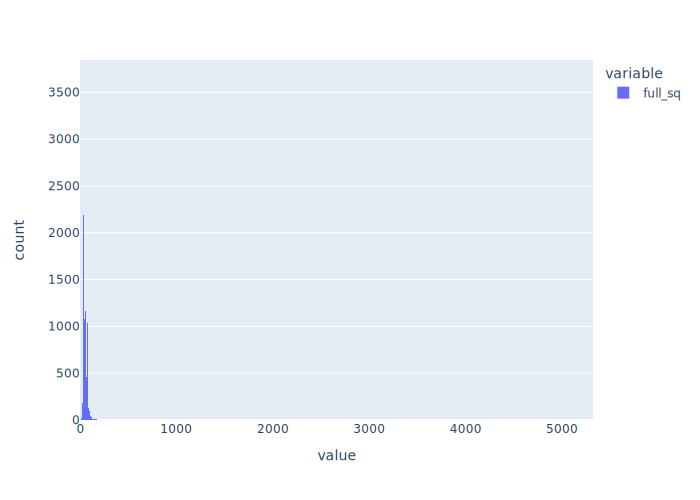

In [38]:
px.histogram(interiors['full_sq'])

### Full Square

In [39]:
# Life square supposed to be at least 0.3 of the full square (conservative value)
interiors.loc[interiors.full_sq < 10 ,'full_sq'] = np.nan # full sq is too low...
interiors.loc[(interiors.life_sq < 0.3*interiors.full_sq)*(interiors.full_sq > 210), 'full_sq'] = np.nan # full sq is probably wrong.

### Life Square

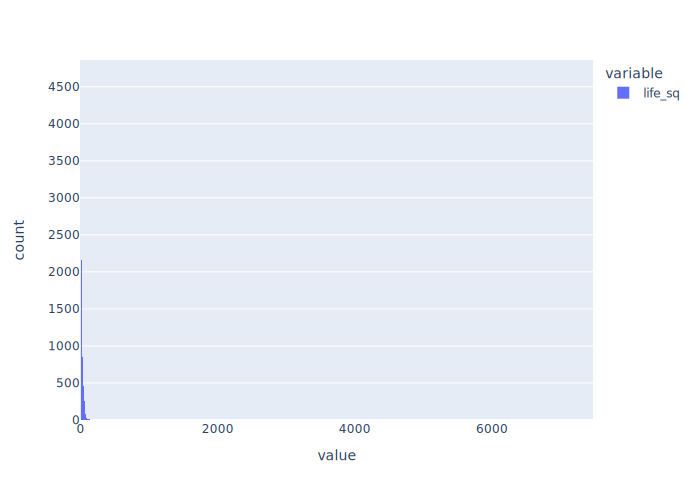

In [40]:
px.histogram(interiors.life_sq)

In [41]:
interiors.loc[(interiors.life_sq < 5), 'life_sq'] = np.nan # deal with bad life square.
interiors.loc[(interiors.life_sq >= interiors.full_sq), 'life_sq'] = np.nan

### Kitchen Square

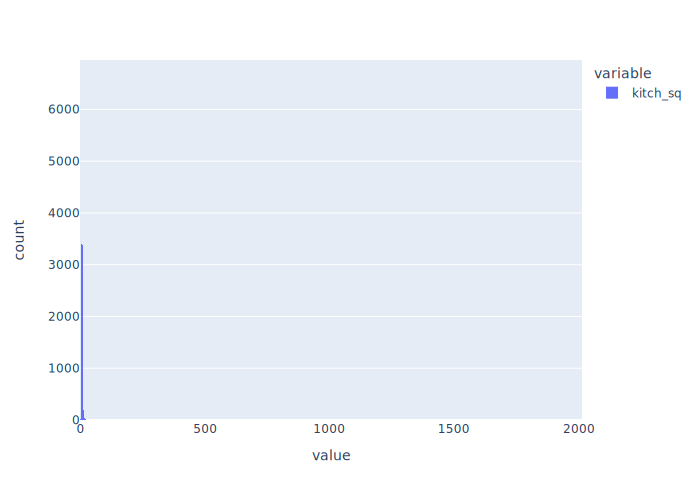

In [42]:
px.histogram(interiors['kitch_sq'])

In [43]:
# Remove too small values
interiors.loc[interiors['kitch_sq'].isin([0,1,2,3]), 'kitch_sq'] = np.nan
# Remove abnormal values

interiors.loc[(interiors['kitch_sq'] >= interiors['full_sq']) | (interiors['kitch_sq'] >= interiors['life_sq']) ,'kitch_sq'] = np.nan 

### Number of rooms

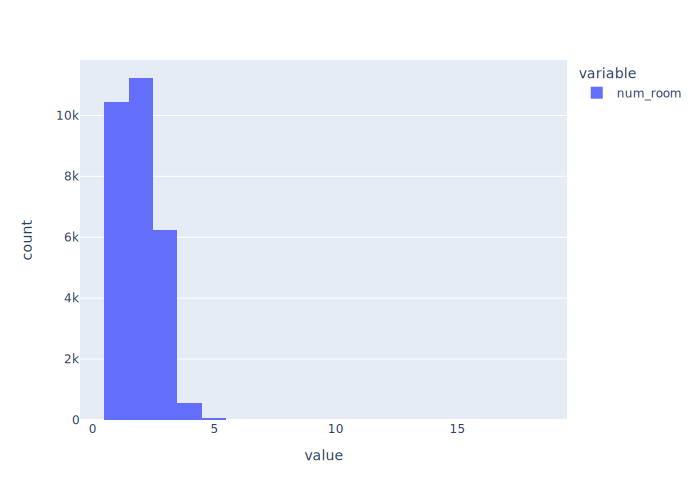

In [44]:
px.histogram(interiors.num_room)

In [45]:
# Finding apartment with a incorrect number of rooms.
threshold_for_sq_per_room = 5

interiors.loc[(interiors['life_sq']/interiors['num_room'] < threshold_for_sq_per_room) | (interiors.num_room <= 0), 'num_room'] = np.nan

### Floor & Max Floor

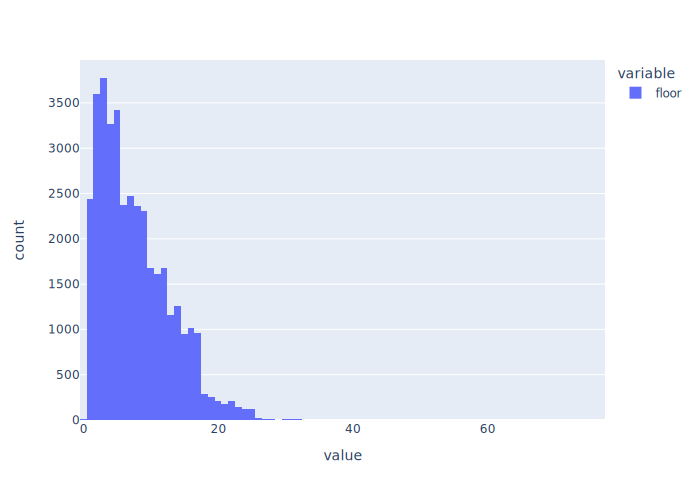

In [46]:
px.histogram(interiors.floor)

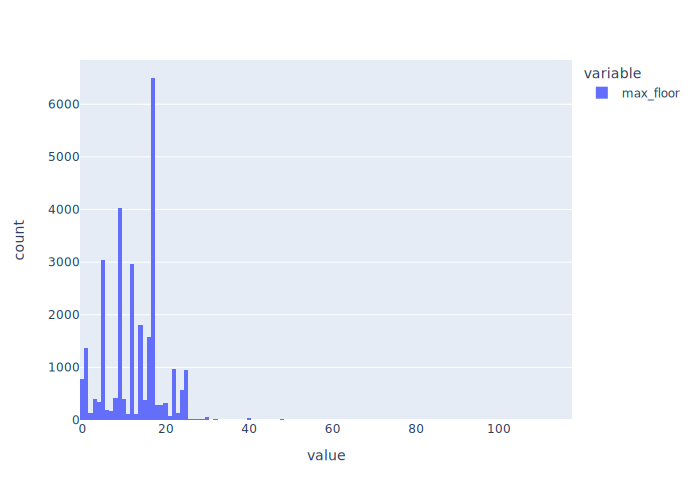

In [47]:
px.histogram(interiors.max_floor)

In [48]:
interiors.loc[interiors['floor'] == 77, 'floor'] = np.nan
interiors.loc[interiors['floor'] > interiors['max_floor'], 'max_floor'] = np.nan
interiors.loc[interiors['floor'] == 0, 'floor'] = np.nan
interiors.loc[interiors['max_floor'] == 0, 'max_floor'] = np.nan

###  Build Year

In [49]:
interiors.build_year.value_counts().index.unique()

Index([    2014.0,     2015.0,        0.0,     2016.0,     2013.0,     2017.0,
              1.0,     1969.0,     1970.0,     1968.0,
       ...
           1945.0,       71.0,     1904.0, 20052009.0,     1876.0,     1886.0,
           1925.0,     1691.0,       20.0,     1898.0],
      dtype='float64', name='build_year', length=127)

In [50]:
# Build Year
interiors.loc[(interiors['build_year'] < 1500) , 'build_year'] = np.nan
interiors.loc[interiors['build_year'] == 4965,'build_year'] = 1965
interiors.loc[interiors['build_year'] == 20052009, 'build_year'] = np.nan

In [51]:
# Product type
interiors['product_type'].value_counts()

product_type
Investment       24446
OwnerOccupier    13654
Name: count, dtype: int64

In [52]:
interiors['product_type'].isnull().sum()

33

In [53]:
interiors['product_type'].fillna(interiors['product_type'].mode()[0], inplace=True)

/var/folders/2y/5vlst1hd6jz9tggyvm776y3m0000gn/T/ipykernel_66217/3817222879.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
# State
print(interiors['state'].value_counts())
# Remove outlier.
interiors.loc[interiors['state'] == 33.0, 'state'] =  3

state
2.0     8506
3.0     7703
1.0     7121
4.0      549
33.0       1
Name: count, dtype: int64


In [55]:
# Material
interiors['material'].value_counts()

material
1.0    19438
2.0     3951
5.0     2048
4.0     1963
6.0     1159
3.0        2
Name: count, dtype: int64

In [56]:
full_data[interiors.columns] = interiors

## Data Cleaning

### Missing Values - Shallow Cleaning

The way we cleaned our data:

1. Got the list of the features that has more than 30% missing values.
2. Calculated each feature (from the list above) correlation with the response variable.
3. If a feature had more than 30% missing values and a correlation below 0.3 (in absolute value) it was removed.

In [57]:
missing_vals = pd.DataFrame(full_data.isnull().mean()*100)
features = missing_vals.index
vals = missing_vals.values.flatten()

# Create a dataframe with the pct of missing values for each feature
missing_vals = pd.DataFrame({'Features':features,'vals':vals})

# Get the feature 
features_to_delete = missing_vals[missing_vals['vals'] > 30]['Features']

# Get the corrs with price
corss = np.round(full_data[['price_doc'] + features_to_delete.to_list()].corr(),2).loc['price_doc']

# Remove the first correlation (price with itself).
corrs_with_price = corss.to_list()[1:]

corr_w_price = pd.DataFrame({'Features to delete':features_to_delete,'corr with price':corrs_with_price})

corr_w_price

Features to delete  corr with price
3                       life_sq             0.56
5                     max_floor             0.13
7                    build_year             0.04
9                      kitch_sq             0.38
10                        state             0.13
24          hospital_beds_raion             0.15
160  cafe_sum_500_min_price_avg             0.04
161  cafe_sum_500_max_price_avg             0.04
162          cafe_avg_price_500             0.04

We decided to not delete max floor, state, build year and hospital beds since they give us valuable information about surroundings, building and apartment

In [58]:
corr_w_price.drop([7,24,5,10], inplace=True)

In [59]:
# Get the features that has low correlation with the response variable
features_to_delete = corr_w_price[abs(corr_w_price['corr with price']) < 0.3]['Features to delete'].tolist()
print(features_to_delete)
full_data = full_data.drop(columns = features_to_delete)

['cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg', 'cafe_avg_price_500']


### Missing Values - Deep cleaning

By reading the data dictionary text file, we understood that some of the neighborhood features can be separated into groups. Thus, we created separated text files for each group of features and uploaded it to github so it'd be much easier to divide them into groups

In [60]:
import requests

# Paths to text files from github
paths = ['https://raw.githubusercontent.com/LidorErez98/Sberbank_ML/main/text_files/areas.txt',
         'https://raw.githubusercontent.com/LidorErez98/Sberbank_ML/main/text_files/buildings.txt',
         'https://raw.githubusercontent.com/LidorErez98/Sberbank_ML/main/text_files/demographics.txt',
         'https://raw.githubusercontent.com/LidorErez98/Sberbank_ML/main/text_files/distances.txt',
         'https://raw.githubusercontent.com/LidorErez98/Sberbank_ML/main/text_files/education.txt', 
         'https://raw.githubusercontent.com/LidorErez98/Sberbank_ML/main/text_files/facilities.txt',
         'https://raw.githubusercontent.com/LidorErez98/Sberbank_ML/main/text_files/interior.txt',
         'https://raw.githubusercontent.com/LidorErez98/Sberbank_ML/main/text_files/surroundings.txt']

# Groups
groups = {
    'areas':[],
    'buildings':[],
    'demographics':[],
    'distances':[],
    'education':[],
    'facilities':[],
    'interior': [],
    'surroundings':[]
}

keys = list(groups.keys())

for i in range(len(paths)):
    # Http request to get the file data
    response = requests.get(paths[i])
    # read File lines
    lines = response.text.splitlines()
    for line in lines:
        # Split by \t
        col = line.split('\t')[0]
        # Interior file has : in it.
        if keys[i] == 'interior':
            col = col.split(':')[0]
        groups[keys[i]].append(col)

In [61]:
def naIndicator(data, groups):
    nas_indicators = []
    for group in groups:
        data_cols = data.columns[np.where(data.columns.isin(groups[group]))]
        na_indicator = np.any(data[data_cols].isnull().sum() > 0)
        nas_indicators.append((group, na_indicator))
    return nas_indicators

In [62]:
naIndicator(full_data, groups)

[('areas', False),
 ('buildings', True),
 ('demographics', False),
 ('distances', True),
 ('education', True),
 ('facilities', True),
 ('interior', True),
 ('surroundings', True)]

It seems that few groups are still suffering from missing data.

In [63]:
# Create a data frame for each group:
groups_dfs = {group:full_data[full_data.columns[np.where(full_data.columns.isin(groups[group]))]] for group in groups}

#### Buildings

In [64]:
buildings = groups_dfs['buildings']
# Get rows with missing values.
missing_vals = buildings.loc[buildings.isna().sum(axis=1) > 0]

# Check if the missing values df has some data in it.
print(f'Number of rows in df: {missing_vals.shape[0]} \n\n Number of missing values in each columns: \n\n {missing_vals.isna().sum()}')

Number of rows in df: 6209 

 Number of missing values in each columns: 

 raion_build_count_with_material_info     6209
build_count_block                        6209
build_count_wood                         6209
build_count_frame                        6209
build_count_brick                        6209
build_count_monolith                     6209
build_count_panel                        6209
build_count_foam                         6209
build_count_slag                         6209
build_count_mix                          6209
raion_build_count_with_builddate_info    6209
build_count_before_1920                  6209
build_count_1921-1945                    6209
build_count_1946-1970                    6209
build_count_1971-1995                    6209
build_count_after_1995                   6209
dtype: int64


In order to fill these columns we need domain knowledge. However each of these columns represent an amount therefore we'll replace nan values with 0.

In [65]:
buildings[buildings.filter(like='count').columns] = buildings[buildings.filter(like='count').columns].replace(np.nan, 0) # 0 for count data
buildings[buildings.filter(like='info').columns] = buildings[buildings.filter(like='info').columns].replace(np.nan,-1)
buildings.isnull().sum()

/var/folders/2y/5vlst1hd6jz9tggyvm776y3m0000gn/T/ipykernel_66217/222925215.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/2y/5vlst1hd6jz9tggyvm776y3m0000gn/T/ipykernel_66217/222925215.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



raion_build_count_with_material_info     0
build_count_block                        0
build_count_wood                         0
build_count_frame                        0
build_count_brick                        0
build_count_monolith                     0
build_count_panel                        0
build_count_foam                         0
build_count_slag                         0
build_count_mix                          0
raion_build_count_with_builddate_info    0
build_count_before_1920                  0
build_count_1921-1945                    0
build_count_1946-1970                    0
build_count_1971-1995                    0
build_count_after_1995                   0
dtype: int64

In [66]:
groups_dfs['buildings'] = buildings


In [67]:
groups_with_missing_vals = ['interior','distances','surroundings']

#### Interior

In [68]:
interior = groups_dfs['interior']
# Get interior Data Frame
interior_na = interior.isnull().sum()
print(interior_na[interior_na > 0])

full_sq          40
life_sq       11762
floor           177
max_floor     11711
material       9572
build_year    16116
num_room       9600
kitch_sq      18118
state         14253
price_doc      7662
dtype: int64


##### Few Helpers:

In [69]:
def handleFullsqLifesq(data, nas_full, nas_life, sa_med_fullsq, sa_life_full_prop):
    data['missing_life'] = data['life_sq'].isnull().astype(int)
    data['missing_full'] = data['full_sq'].isnull().astype(int)
    for index in data.index:
        sub_area = data.loc[index,'sub_area']

        fullsq = data.loc[index, 'full_sq']
        lifesq = data.loc[index, 'life_sq']

        mask_sa_pct = (sa_life_full_prop['sub_area'].isin([sub_area]))
        mask_sa_full = (sa_med_fullsq['sub_area'].isin([sub_area]))

        sa_prop = sa_life_full_prop.loc[mask_sa_pct]['PCT'].values[0]
        full_sq_med =sa_med_fullsq.loc[mask_sa_full]['median'].values[0]

        flag = 0

        """
        If life sq is missing - fill it with full sq * avg pct of life sq out of full sq.
        If full sq is missing - fill it with life sq / avg pct of life sq out of full sq.
        If both are missing - fill full sq with median of full sq and then calculate life sq using the median value.
        """
        if not nas_full[index] and nas_life[index]:
            flag = 2
            data.loc[index, 'life_sq'] = fullsq * sa_prop
        elif not nas_life[index] and nas_full[index]:
            flag = 3
            data.loc[index, 'full_sq'] = lifesq / sa_prop
        elif nas_life[index] and nas_full[index]:
            flag = 4
            data.loc[index, 'full_sq'] = full_sq_med # get median value to fill na
            data.loc[index, 'life_sq'] =  full_sq_med * sa_prop # calculate life sq using the median value
        
        # if check to see if the algorithm work correctly.
        if np.any(data['life_sq'] >= data['full_sq']):
            print(flag)
            break
    return {1:'Done', 'Full SQ': data['full_sq'].isna().sum(), 'Life SQ': data['life_sq'].isna().sum(), 'Life SQ >= Full SQ': (data['life_sq'] >= data['full_sq']).any()}

In [70]:
def HandleFloorMaxFloor(data, sa):
    data['missing_floor'] = data['floor'].isnull().astype(int)
    data['missing_maxfloor'] = data['max_floor'].isnull().astype(int)
    # fill na in max floor
    med_max_floor = sa['max_floor'].transform('median')
    med_max_floor = np.round(med_max_floor.fillna(med_max_floor.median())) # fill the missing value with the median of medians.
    data['max_floor'] = data['max_floor'].fillna(med_max_floor)
    # Fill floor:
    med_floor = sa['floor'].transform('median')
    med_floor = np.round(med_floor.fillna(med_floor.median())) # fill the missing value with the median of medians.
    data.loc[:,'floor'] = data['floor'].fillna(med_floor)

    data.loc[data['floor'] > data['max_floor'],'floor'] = data['max_floor']

    return {1:'Done', 'Max Floor': data['max_floor'].isna().sum(), 'Floor': data['floor'].isna().sum(), 'Floor > Max Floor': (data['floor']> data['max_floor']).any()}

In [71]:
def HandleNumRooms(data, sa):
    data['missing_num_room'] = data['num_room'].isnull().astype(int)
    # fill na with the median number of rooms for each sub area and product type.
    data.loc[:,'num_room'] = data['num_room'].fillna(sa['num_room'].transform('median'))

    # Make sure data makes sense.
    mask = data['life_sq']/data['num_room'] < 5
    #  5 square meter per room is a conservative value.
    data.loc[mask | (data['num_room'].isna()), 'num_room'] = data['life_sq'] // 5
    data.loc[data['num_room'] == 0, 'num_room'] = 1

    return {1:'Done', 'Num Room': data['num_room'].isna().sum(), 'LifeSQ/NumRoom < 5': (data['life_sq']/data['num_room']<5).any()}

In [72]:
def HandleBuildYear(data):
    data['missing_build_year'] = data['build_year'].isnull().astype(int)
    
    sa_median_build_year = data.groupby(['sub_area'])['build_year'].transform('median')

    data.loc[:,'build_year'] = data['build_year'].fillna(sa_median_build_year)

    return {1:"Done","Build_Year": data['build_year'].isna().sum()}

In [73]:
def handleStateMaterial(data):
    data['missing_state'] = data['state'].isnull().astype(int)
    data['missing_material'] = data['material'].isnull().astype(int)
    
    data['year'] = pd.to_datetime(data['timestamp']).dt.year
    data['age'] = data['year'] - data['build_year']

    state_modes = data['state'].fillna(data.groupby(['age','sub_area'])['state'].transform(lambda val: val.mode()[0] if len(val.mode())>0 else None))
    state_modes = state_modes.fillna(state_modes.mode()[0])

    data.loc[:,'state'] = data['state'].fillna(state_modes)

    material_modes = data['material'].fillna(data.groupby(['build_year','sub_area'])['material'].transform(lambda val: val.mode()[0] if len(val.mode())>0 else None))
    material_modes = material_modes.fillna(material_modes.mode()[0])
    data.loc[:,'material'] = data['material'].fillna(material_modes)

    return {1:'Done', 'State': data['state'].isna().sum(), 'Material': data['material'].isna().sum()}

In [74]:
def HandleKitchSQ(data, sa_kitch_life_prop):
    data['missing_kitch_sq'] = data['kitch_sq'].isnull().astype(int)
    for idx in data.index:
        life_sq = data.loc[idx,'life_sq']
        kitch_sq = data.loc[idx,'kitch_sq']
        product_type = data.loc[idx,'product_type']
        sub_area = data.loc[idx,'sub_area']

        if not np.isnan(kitch_sq) and kitch_sq < life_sq:
            continue
        mask = (sa_kitch_life_prop['sub_area'].isin([sub_area]))
        avg_ratio = sa_kitch_life_prop.loc[mask]['PCT'].values[0]

        data.loc[idx, 'kitch_sq'] = life_sq * avg_ratio
    
    return {1:'Done', 'Kitch SQ': data['kitch_sq'].isna().sum(), 'Kitch SQ >= Full SQ': (data['kitch_sq'] >= data['full_sq']).any(), 'Kitch SQ >= Life SQ': (data['kitch_sq'] >= data['life_sq']).any()}

In [75]:
# Calculate life sq / full sq 
interior.loc[:,'life_full_ratio'] = interior['life_sq']/interior['full_sq']
(interior['life_full_ratio'] >= 1).any()

/var/folders/2y/5vlst1hd6jz9tggyvm776y3m0000gn/T/ipykernel_66217/4061903555.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



False

In [76]:
# product type and sub area group by
sa_grps = interior.groupby(['sub_area'])

# Calculate the avg pct of life sq out of full sq for each  sub area: 
avg_life_full_prop = (sa_grps['life_full_ratio'].mean()).reset_index().rename(columns={'life_full_ratio':'PCT'})

In [77]:
# median full sq
sa_med_fullsq = sa_grps['full_sq'].median().reset_index().rename(columns = {'full_sq':'median'}) # cause median is robust to outliers.

# Get the NAS of full sq
nas_full = interior['full_sq'].isnull()
# Get the NAS of life sq
nas_life = interior['life_sq'].isnull()

In [78]:
handleFullsqLifesq(interior, nas_full, nas_life, sa_med_fullsq, avg_life_full_prop)


/var/folders/2y/5vlst1hd6jz9tggyvm776y3m0000gn/T/ipykernel_66217/2830605670.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/2y/5vlst1hd6jz9tggyvm776y3m0000gn/T/ipykernel_66217/2830605670.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



{1: 'Done', 'Full SQ': 0, 'Life SQ': 0, 'Life SQ >= Full SQ': False}

In [79]:
interior = interior.drop(columns = 'life_full_ratio')

In [80]:
HandleFloorMaxFloor(interior, sa_grps)

{1: 'Done', 'Max Floor': 0, 'Floor': 0, 'Floor > Max Floor': False}

In [81]:
HandleNumRooms(interior, sa_grps)

{1: 'Done', 'Num Room': 0, 'LifeSQ/NumRoom < 5': False}

In [82]:
# Sanity check:
interior.isna().sum()

id                      0
timestamp               0
full_sq                 0
life_sq                 0
floor                   0
max_floor               0
material             9572
build_year          16116
num_room                0
kitch_sq            18118
state               14253
product_type            0
sub_area                0
price_doc            7662
missing_life            0
missing_full            0
missing_floor           0
missing_maxfloor        0
missing_num_room        0
dtype: int64

In [83]:
HandleBuildYear(interior)

{1: 'Done', 'Build_Year': 0}

In [84]:
handleStateMaterial(interior)

{1: 'Done', 'State': 0, 'Material': 0}

In [85]:
interior.drop(columns = ['year','age'], inplace=True) # Drop cols.

In [86]:
interior.isna().sum()

id                        0
timestamp                 0
full_sq                   0
life_sq                   0
floor                     0
max_floor                 0
material                  0
build_year                0
num_room                  0
kitch_sq              18118
state                     0
product_type              0
sub_area                  0
price_doc              7662
missing_life              0
missing_full              0
missing_floor             0
missing_maxfloor          0
missing_num_room          0
missing_build_year        0
missing_state             0
missing_material          0
dtype: int64

In [87]:
# Fill missing values in kitch_sq column

# Get the kitch_sq/full sq 
interior['kitch_life_ratio'] = interior['kitch_sq']/interior['life_sq']
interior['kitch_life_ratio'] = interior['kitch_life_ratio'].fillna(interior['kitch_life_ratio'].mean()) # Fill missing values with the mean.

# Get the avg kitch_sq/full sq for each sub area and product type.
sa_avg_kitch_life = interior.groupby(['sub_area'])['kitch_life_ratio'].mean().reset_index().rename(columns={'kitch_life_ratio':'PCT'})

In [88]:
HandleKitchSQ(interior, sa_avg_kitch_life)

{1: 'Done',
 'Kitch SQ': 0,
 'Kitch SQ >= Full SQ': False,
 'Kitch SQ >= Life SQ': False}

In [89]:
groups_dfs['interior'] = interior.drop(columns = ['kitch_life_ratio'])

#### Distances

In [90]:
# Get distances data frame
distances = groups_dfs['distances']
distances_na = distances.isnull().sum()
# Get the features that have missing values.
distances_na[distances_na > 0]

metro_min_walk               59
metro_km_walk                59
railroad_station_walk_km     59
railroad_station_walk_min    59
ID_railroad_station_walk     59
dtype: int64

In [91]:
distances['sub_area'] = full_data['sub_area']
for c in distances_na[distances_na > 0].index:
    if 'ID' not in c:
        distances[c].fillna(distances.groupby('sub_area')[c].transform('median'), inplace=True)
    else:
        distances[c].fillna(distances.groupby('sub_area')[c].transform(lambda x: x.mode()[0]), inplace=True)

/var/folders/2y/5vlst1hd6jz9tggyvm776y3m0000gn/T/ipykernel_66217/3585862785.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/2y/5vlst1hd6jz9tggyvm776y3m0000gn/T/ipykernel_66217/3585862785.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/2y/5vlst1hd6jz9tggyvm776y3m0000gn/T/ipykernel_66217/3585862785.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [92]:
distances.drop(columns='sub_area', inplace=True)

/var/folders/2y/5vlst1hd6jz9tggyvm776y3m0000gn/T/ipykernel_66217/2186917241.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [93]:
groups_dfs['distances'] = distances

#### Surroundings

In [94]:
# Get surroundings data frame
surroundings = groups_dfs['surroundings']
surr_na = surroundings.isnull().sum()
# Get the features that have missing values.
surr_na[surr_na > 0]

cafe_sum_1000_min_price_avg    7746
cafe_sum_1000_max_price_avg    7746
cafe_avg_price_1000            7746
cafe_sum_1500_min_price_avg    5020
cafe_sum_1500_max_price_avg    5020
cafe_avg_price_1500            5020
green_part_2000                  19
cafe_sum_2000_min_price_avg    2149
cafe_sum_2000_max_price_avg    2149
cafe_avg_price_2000            2149
cafe_sum_3000_min_price_avg    1173
cafe_sum_3000_max_price_avg    1173
cafe_avg_price_3000            1173
prom_part_5000                  270
cafe_sum_5000_min_price_avg     425
cafe_sum_5000_max_price_avg     425
cafe_avg_price_5000             425
dtype: int64

To address these missing values, we decided to use KNNImputer since each feature here represent an avg price of a shop within a certain distance. However, before doing that we need to check the variabilility of each feature which is the STD/Mean.

In [95]:
# Get the columns
surr_na_cols = surr_na[surr_na > 0].index
# Check the std/mean ratio
surroundings[surr_na_cols].std()/surroundings[surr_na_cols].mean()

cafe_sum_1000_min_price_avg    0.318793
cafe_sum_1000_max_price_avg    0.288062
cafe_avg_price_1000            0.298280
cafe_sum_1500_min_price_avg    0.271707
cafe_sum_1500_max_price_avg    0.245080
cafe_avg_price_1500            0.253864
green_part_2000                0.676771
cafe_sum_2000_min_price_avg    0.275928
cafe_sum_2000_max_price_avg    0.250875
cafe_avg_price_2000            0.259165
cafe_sum_3000_min_price_avg    0.286584
cafe_sum_3000_max_price_avg    0.269686
cafe_avg_price_3000            0.275521
prom_part_5000                 0.549153
cafe_sum_5000_min_price_avg    0.196017
cafe_sum_5000_max_price_avg    0.182153
cafe_avg_price_5000            0.187165
dtype: float64

In [96]:
# Create an imputer
imputer = KNNImputer(n_neighbors=10)

# Use imputer to fill missing values.
surroundings.loc[:,surr_na_cols] = imputer.fit_transform(surroundings[surr_na_cols]) 

In [97]:
# Check if knn imputer worked
np.any(surroundings.isna().sum() > 0)

False

In [98]:
# Update surroundings data frame
groups_dfs['surroundings'] = surroundings

#### Education

In [99]:
education = groups_dfs['education']
education.isna().sum()

preschool_quota                          8284
preschool_education_centers_raion           0
school_quota                             8280
school_education_centers_raion              0
school_education_centers_top_20_raion       0
university_top_20_raion                     0
sport_objects_raion                         0
additional_education_raion                  0
dtype: int64

each of the columns with missing values give an information about the number of seats.. so we decided to fill them with -1 to indicate there's no data.

In [100]:
education.loc[:, 'preschool_quota'] = education['preschool_quota'].fillna(-1)
education.loc[:, 'school_quota'] = education['school_quota'].fillna(-1)

In [101]:
groups_dfs['education'] = education

#### Facilities

In [102]:
faci = groups_dfs['facilities']
faci.isna().sum()

hospital_beds_raion          17859
healthcare_centers_raion         0
shopping_centers_raion           0
office_raion                     0
thermal_power_plant_raion        0
incineration_raion               0
oil_chemistry_raion              0
radiation_raion                  0
railroad_terminal_raion          0
big_market_raion                 0
nuclear_reactor_raion            0
detention_facility_raion         0
dtype: int64

In [103]:
# Again a feature that indicates a count... can be fillied with -1 - no data.

faci.loc[:,'hospital_beds_raion'] = faci['hospital_beds_raion'].fillna(-1)

In [104]:
groups_dfs['facilities'] = faci

#### Cleaning the data

In [105]:
# Check if we missed any missing value:
group_na_indicators = []

for group in groups_dfs:
    indicator = np.any(groups_dfs.get(group).isna().sum() > 0)
    group_na_indicators.append((group, indicator))

group_na_indicators

[('areas', False),
 ('buildings', False),
 ('demographics', False),
 ('distances', False),
 ('education', False),
 ('facilities', False),
 ('interior', True),
 ('surroundings', False)]

In [106]:
nas = full_data.isna().sum()
# Change np.nan values into -1 so they could be replaced with the real value from groups dfs
full_data.loc[:, nas[nas > 0].index] = train.loc[:, nas[nas > 0].index].replace(np.nan, -999)

for group in groups_dfs:
    df = groups_dfs.get(group)
    # Insert clean columns to df.
    full_data.loc[df.index, df.columns] = df

In [107]:
full_data = full_data.replace(-999,np.nan)

In [108]:
# get columns with missing values - supposed to be the distances columns only
x = full_data.isna().sum()
print(x[x>0])

price_doc    7662
dtype: int64


In [109]:
# full_data.to_csv("~/desktop/cleand_data.csv", index=False)

## Loading Cleaned Data Frame

In [2]:
import requests

# Paths to text files from github
paths = ['https://raw.githubusercontent.com/LidorErez98/Sberbank_ML/main/text_files/areas.txt',
         'https://raw.githubusercontent.com/LidorErez98/Sberbank_ML/main/text_files/buildings.txt',
         'https://raw.githubusercontent.com/LidorErez98/Sberbank_ML/main/text_files/demographics.txt',
         'https://raw.githubusercontent.com/LidorErez98/Sberbank_ML/main/text_files/distances.txt',
         'https://raw.githubusercontent.com/LidorErez98/Sberbank_ML/main/text_files/education.txt', 
         'https://raw.githubusercontent.com/LidorErez98/Sberbank_ML/main/text_files/facilities.txt',
         'https://raw.githubusercontent.com/LidorErez98/Sberbank_ML/main/text_files/interior.txt',
         'https://raw.githubusercontent.com/LidorErez98/Sberbank_ML/main/text_files/surroundings.txt']

# Groups
groups = {
    'areas':[],
    'buildings':[],
    'demographics':[],
    'distances':[],
    'education':[],
    'facilities':[],
    'interior': [],
    'surroundings':[]
}

keys = list(groups.keys())

for i in range(len(paths)):
    # Http request to get the file data
    response = requests.get(paths[i])
    # read File lines
    lines = response.text.splitlines()
    for line in lines:
        # Split by \t
        col = line.split('\t')[0]
        # Interior file has : in it.
        if keys[i] == 'interior':
            col = col.split(':')[0]
        groups[keys[i]].append(col)

In [3]:
full_data = pd.read_csv("https://raw.githubusercontent.com/LidorErez98/Sberbank_ML/main/cleand_data.csv")

In [4]:
sanity = full_data.isna().sum()
sanity[sanity > 0]

price_doc    7662
dtype: int64

In [5]:
groups_dfs = {group:full_data[full_data.columns[np.where(full_data.columns.isin(groups[group]))]] for group in groups}

## Feature Engineering

In [6]:
def create_time_features(data):
    data['year'] = pd.to_datetime(data['timestamp']).dt.year
    data['month'] = pd.to_datetime(data['timestamp']).dt.month
    data['day'] = pd.to_datetime(data['timestamp']).dt.day
    data['day_of_week'] = pd.to_datetime(data['timestamp']).dt.dayofweek
    data['week_of_year'] = pd.to_datetime(data['timestamp']).dt.days_in_month
    data['quarter'] = pd.to_datetime(data['timestamp']).dt.quarter

    # Part 5 
    data['monthyear'] = data['year']*100 + data['month']
    data['weekyear'] = data['year']*100 + data['week_of_year']

    month_year_counts = data['monthyear'].value_counts().to_dict()
    data['monthyear_count'] = data['monthyear'].map(month_year_counts)

    week_year_counts = data['weekyear'].value_counts().to_dict()
    data['weekyear_count'] = data['weekyear'].map(week_year_counts)

In [7]:
full_data['timestamp'] = pd.to_datetime(full_data['timestamp'])
create_time_features(full_data)
full_data['log_price'] = np.log(full_data['price_doc'] + 1)
full_data['building_age'] = full_data['year'] - full_data['build_year']
full_data['price_sq'] = full_data['price_doc']/full_data['full_sq']

In [8]:
dens_columns = [col + '_dens' for col in groups_dfs['demographics'].columns]

In [9]:
full_data[dens_columns] = full_data[groups_dfs['demographics'].columns].apply(lambda x:x/full_data['area_m'])

In [10]:
groups_dfs['demographics'].loc[:,dens_columns] = full_data[dens_columns]

In [11]:
full_data["ratio_life_sq_full_sq"] = full_data["life_sq"] / full_data["full_sq"]

In [12]:
# adding ratio_life_sq_full_sq to interior group
groups_dfs['interior'].loc[:,'ratio_life_sq_full_sq'] = full_data['ratio_life_sq_full_sq']

/var/folders/2y/5vlst1hd6jz9tggyvm776y3m0000gn/T/ipykernel_47566/198719290.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
#kitchen ratio from the life sq
full_data["ratio_kitch_sq_full_sq"] = full_data["kitch_sq"] / full_data["full_sq"]


In [14]:
# adding ratio_kitch_sq_life_sq to interior group
groups_dfs['interior'].loc[:,'ratio_kitch_sq_full_sq'] = full_data['ratio_kitch_sq_full_sq']

/var/folders/2y/5vlst1hd6jz9tggyvm776y3m0000gn/T/ipykernel_47566/975391471.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
# calculate the room size
full_data["room_size"] = (full_data["life_sq"] - full_data['kitch_sq']) / full_data["num_room"]

In [16]:
# adding room size to interior group
groups_dfs['interior'].loc[:, 'room_size'] = full_data['room_size']

/var/folders/2y/5vlst1hd6jz9tggyvm776y3m0000gn/T/ipykernel_47566/4252726323.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
full_data['extra_sq'] = full_data['full_sq'] - full_data['life_sq']

In [18]:
full_data['area_diff'] = full_data['full_sq'] - full_data['kitch_sq'] # Part 5

In [19]:
# adding extra sq to interior group
groups_dfs['interior'].loc[:,'extra_sq'] = full_data['extra_sq']
groups_dfs['interior'].loc[:,'area_diff'] = full_data['area_diff']

/var/folders/2y/5vlst1hd6jz9tggyvm776y3m0000gn/T/ipykernel_47566/2361000648.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/2y/5vlst1hd6jz9tggyvm776y3m0000gn/T/ipykernel_47566/2361000648.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
# calculate the floor ratio
full_data['floor_ratio'] = full_data['floor'] / full_data['max_floor']

In [21]:
# adding floor ratio to interior group
groups_dfs['interior'].loc[:,'floor_ratio'] = full_data['floor_ratio']

/var/folders/2y/5vlst1hd6jz9tggyvm776y3m0000gn/T/ipykernel_47566/3316551521.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
# num of floor from top 
full_data['floor_from_top'] = full_data['max_floor'] - full_data['floor']


In [23]:
# adding floor from top to interior group
groups_dfs['interior'].loc[:,'floor_from_top'] = full_data['floor_from_top']

/var/folders/2y/5vlst1hd6jz9tggyvm776y3m0000gn/T/ipykernel_47566/757007344.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
percapita = [c + '_percapita' for c in groups_dfs['education'].columns]
full_data[percapita] = full_data[groups_dfs['education'].columns].apply(lambda edu: edu/full_data['raion_popul'])

In [25]:
groups_dfs['education'].loc[:,percapita] = full_data[percapita]

In [26]:
minmaxscaler = MinMaxScaler()
cafe_count = full_data.filter(like="cafe_count")
minmaxscaler.fit_transform(cafe_count)
# replace with cafe count columns in full_data
full_data.loc[:,cafe_count.columns] = minmaxscaler.fit_transform(cafe_count)

In [27]:
groups_dfs['surroundings'].loc[:,groups_dfs['surroundings'].filter(like="cafe_count").columns] = full_data.filter(like="cafe_count")

In [28]:
full_data.drop(columns = [c.replace('_dens','') for c in dens_columns], inplace=True)
full_data.drop(columns = [c.replace('_percapita','') for c in percapita], inplace=True)
groups_dfs['demographics'] = groups_dfs['demographics'].drop(columns = [c.replace('_dens','') for c in dens_columns])
groups_dfs['education'] = groups_dfs['education'].drop(columns = [c.replace('_percapita','') for c in percapita])

## Explanatory Data Analysis

In [29]:
import plotly.express as px

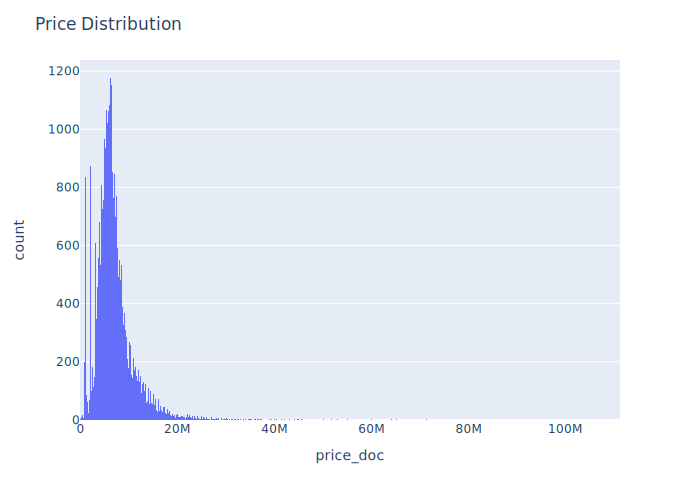

In [30]:
fig = px.histogram(full_data, x='price_doc')
fig.update_layout(title = 'Price Distribution')
fig.show()

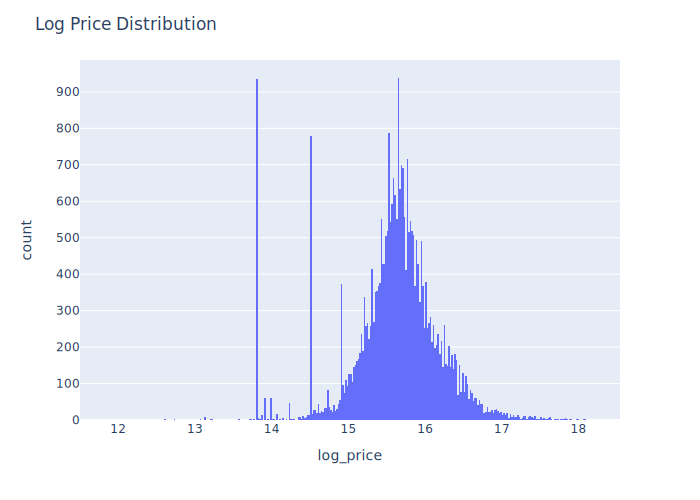

In [31]:
fig = px.histogram(full_data, x='log_price')
fig.update_layout(title = 'Log Price Distribution')
fig.show()

Log price might be a better target variable than the actual price.

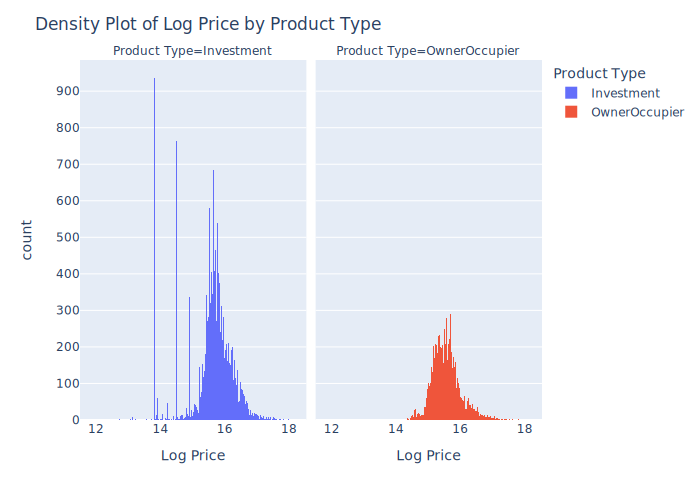

In [32]:
fig = px.histogram(full_data, x='log_price', facet_col='product_type',labels={'log_price':'Log Price', 'product_type':'Product Type'}, color='product_type')
fig.update_layout(title = 'Density Plot of Log Price by Product Type')
fig.show()

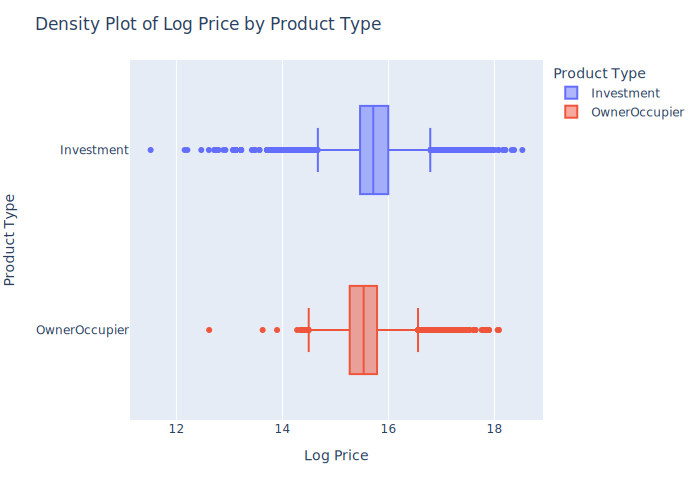

In [33]:
fig = px.box(full_data, x='log_price', y='product_type',labels={'log_price':'Log Price', 'product_type':'Product Type'}, color='product_type')
fig.update_layout(title = 'Density Plot of Log Price by Product Type')
fig.show()

There are many outliers in the log price column this might have an effect on our model predictions.

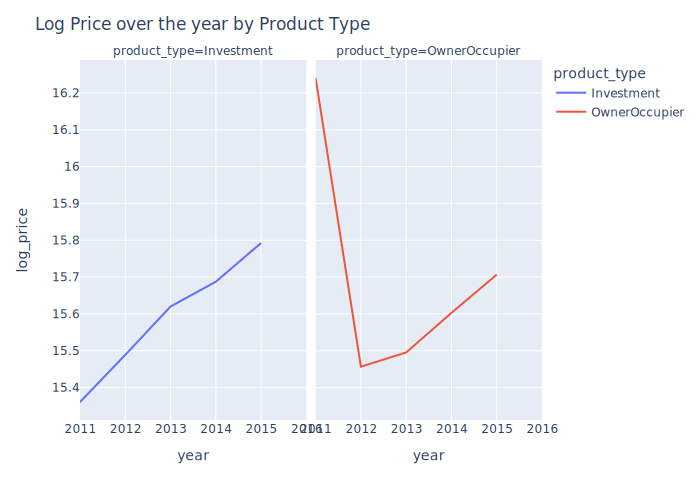

In [34]:
cp = full_data.copy()
cp['year'] = cp['timestamp'].dt.year
temp = (cp.groupby(['year','product_type'])['log_price'].mean()).reset_index()
temp['year'] = temp['year'].apply(lambda x: str(x))
year_order = sorted(temp['year'].unique())
fig = px.line(temp, x='year', y='log_price', facet_col = 'product_type', category_orders={'year': year_order}, color='product_type')
fig.update_layout(title = 'Log Price over the year by Product Type')
fig.show()

Prices different behavior among product types indicate that we might need to train separated models for each product type.

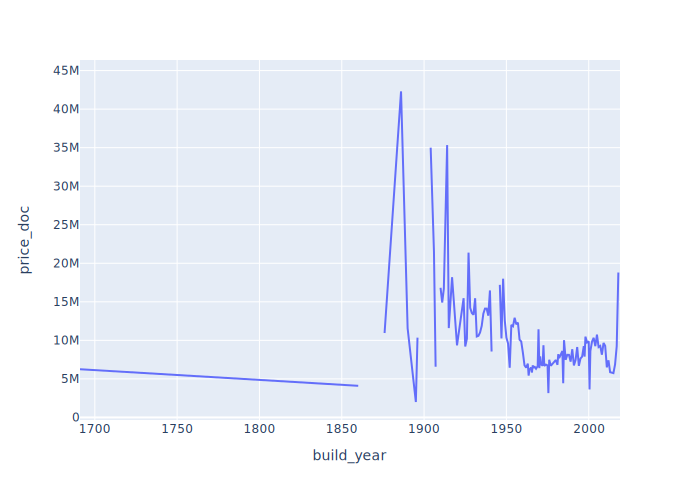

In [35]:
temp = (full_data.groupby("build_year")['price_doc'].mean()).reset_index()
fig = px.line(temp, x='build_year',y='price_doc')
fig.show()

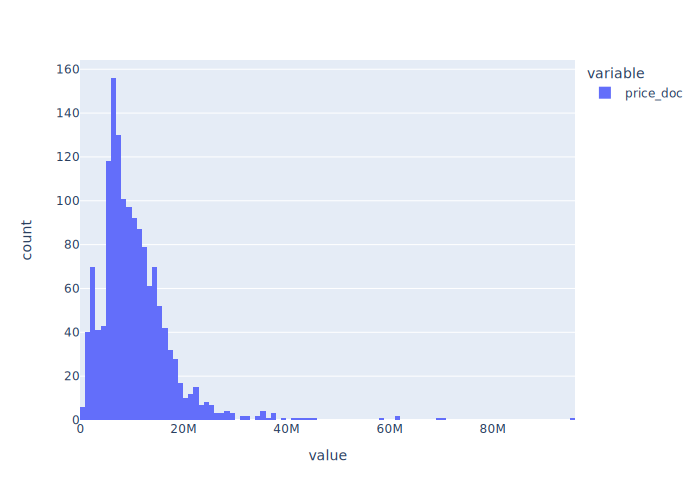

In [36]:
temp = full_data.loc[full_data.build_year <= 1960]
fig = px.histogram(temp['price_doc'])
fig.show()

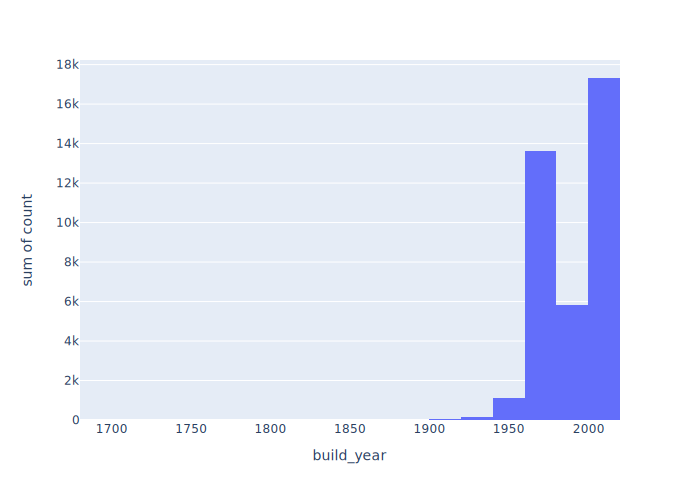

In [37]:
temp = (full_data['build_year'].value_counts()).reset_index()
fig = px.histogram(temp,x='build_year',y='count')
fig.show()

We found that for old building prices are higher when the build year is less than 1960 so we will add a binary feature to  describe if a house is "vintage"

In [38]:
full_data.loc[:,'is_vintage'] = full_data['build_year'].apply(lambda year: (year <= 1960)).astype(int)

/var/folders/2y/5vlst1hd6jz9tggyvm776y3m0000gn/T/ipykernel_47566/2529656510.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



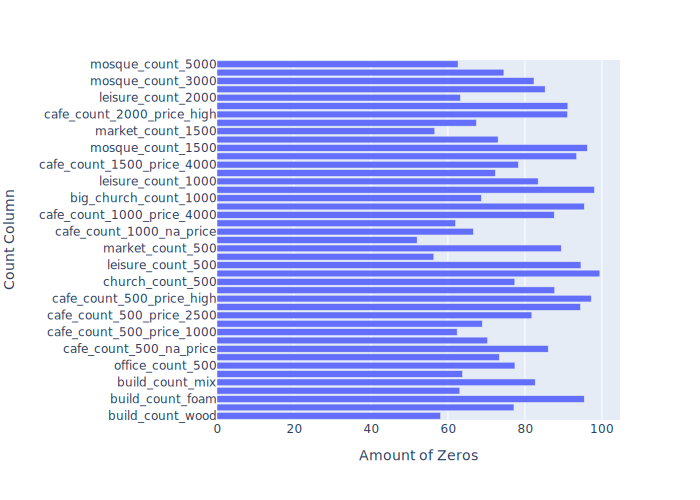

In [39]:
# Checking for sparsity in count data:

zeroes_pct = np.round((full_data.filter(like='count') == 0).mean()*100,2).reset_index().rename(columns = {0:'Amount of Zeros', 'index':'Count Column'})

px.bar(zeroes_pct[zeroes_pct['Amount of Zeros'] >= 50], x='Amount of Zeros',y='Count Column')

We checked the amount of zeros in our count columns to figure out how sparse they are. We then created a bar plot of the count columns that have at least 50% zeros. To cope with this issue we decided to turn each of the count column that is shown on the plot to a binary column which will indicate the absence of data 

In [40]:
sparse_count_columns = zeroes_pct[zeroes_pct['Amount of Zeros'] >= 50]['Count Column'].values
sparse_count_columns

array(['build_count_wood', 'build_count_frame', 'build_count_foam',
       'build_count_slag', 'build_count_mix', 'build_count_before_1920',
       'office_count_500', 'trc_count_500', 'cafe_count_500_na_price',
       'cafe_count_500_price_500', 'cafe_count_500_price_1000',
       'cafe_count_500_price_1500', 'cafe_count_500_price_2500',
       'cafe_count_500_price_4000', 'cafe_count_500_price_high',
       'big_church_count_500', 'church_count_500', 'mosque_count_500',
       'leisure_count_500', 'sport_count_500', 'market_count_500',
       'office_count_1000', 'cafe_count_1000_na_price',
       'cafe_count_1000_price_2500', 'cafe_count_1000_price_4000',
       'cafe_count_1000_price_high', 'big_church_count_1000',
       'mosque_count_1000', 'leisure_count_1000', 'market_count_1000',
       'cafe_count_1500_price_4000', 'cafe_count_1500_price_high',
       'mosque_count_1500', 'leisure_count_1500', 'market_count_1500',
       'cafe_count_2000_price_4000', 'cafe_count_2000_price_hi

In [41]:
for col in sparse_count_columns:
    full_data.loc[:, col + '_binary'] = ((full_data[col] > 0)).astype(int)

full_data.filter(like='_binary')

/var/folders/2y/5vlst1hd6jz9tggyvm776y3m0000gn/T/ipykernel_47566/3714908506.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/2y/5vlst1hd6jz9tggyvm776y3m0000gn/T/ipykernel_47566/3714908506.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/2y/5vlst1hd6jz9tggyvm776y3m0000gn/T/ipykernel_47566/3714908506.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

build_count_wood_binary  build_count_frame_binary  \
0                            0                         0   
1                            1                         0   
2                            0                         0   
3                            1                         1   
4                            0                         0   
...                        ...                       ...   
38128                        0                         0   
38129                        0                         0   
38130                        1                         1   
38131                        0                         0   
38132                        0                         0   

       build_count_foam_binary  build_count_slag_binary  \
0                            0                        0   
1                            0                        0   
2                            0                        1   
3                            0                        1   
4                            0                        1   
...                        ...                      ...   
38128                        0                        0   
38129                        0                        0   
38130                        0                        1   
38131                        0                        0   
38132                        0                        0   

       build_count_mix_binary  build_count_before_1920_binary  \
0                           0                               0   
1                           0                               1   
2                           0                               1   
3                           1                               1   
4                           1                               1   
...                       ...                             ...   
38128                       0                               0   
38129                       0                               0   
38130                       1                               1   
38131                       0                               0   
38132                       0                               0   

       office_count_500_binary  trc_count_500_binary  \
0                            0                     0   
1                            0                     0   
2                            0                     0   
3                            0                     0   
4                            1                     1   
...                        ...                   ...   
38128                        1                     1   
38129                        0                     0   
38130                        1                     1   
38131                        0                     1   
38132                        1                     1   

       cafe_count_500_na_price_binary  cafe_count_500_price_500_binary  ...  \
0                                   0                                0  ...   
1                                   0                                1  ...   
2                                   0                                0  ...   
3                                   0                                0  ...   
4                                   1                                1  ...   
...                               ...                              ...  ...   
38128                               0                                1  ...   
38129                               0                                0  ...   
38130                               1                                1  ...   
38131                               0                                1  ...   
38132                               0                                0  ...   

       leisure_count_1500_binary  market_count_1500_binary  \
0                              0                         1   
1                              1                  

In [42]:
full_data = full_data.drop(columns = sparse_count_columns)

In [43]:
for group in groups_dfs:
    if np.any(groups_dfs[group].columns.isin(sparse_count_columns)):
       idx = np.where(groups_dfs[group].columns.isin(sparse_count_columns))
       cols_to_drop = groups_dfs[group].columns[idx]
       groups_dfs[group] = groups_dfs[group].drop(columns = cols_to_drop)

## Macro CSV

In [44]:
macro = pd.read_csv("https://raw.githubusercontent.com/LidorErez98/Sberbank_ML/main/Data/macro.csv")
min_date, max_date = full_data['timestamp'].min(),full_data['timestamp'].max()
macro['date'] = pd.to_datetime(macro['timestamp'])
macro = macro[(macro['date'] >= min_date) & (macro['date'] <= max_date)]
macro['year'] = macro['date'].dt.year
macro['month'] = macro['date'].dt.month
macro['quarter'] = macro['date'].dt.quarter

In [45]:
# split to sub dataframes
inflation = macro[['date', 'quarter', 'year', 'month', 'cpi', 'ppi', 'gdp_deflator']]
gdp = macro[['date', 'quarter', 'year', 'month', 'gdp_quart', 'gdp_quart_growth', 'gdp_deflator', 'gdp_annual', 'gdp_annual_growth']]
# salary = macro[['date', 'quarter', 'year', 'month', 'salary', 'salary_growth', 'real_dispos_income_per_cap_growth', 'salary_growth']]
# mortgage = macro[['date', 'quarter', 'year', 'month', 'mortgage_rate', 'mortgage_growth', 'deposits_rate', 'deposits_growth']]
# investmeent = macro[['date', 'quarter', 'year', 'month', 'invest_fixed_assets', 'invest_fixed_assets_phys', 'profitable_enterpr_share', 'unprofitable_enterpr_share', 'share_own_revenues', 'overdue_wages_per_cap', 'fin_res_per_cap', 'invest_fixed_assets']]
# consumption = macro[['date', 'quarter', 'year', 'month', 'income_per_cap', 'real_dispos_income_per_cap_growth', 'salary', 'salary_growth', 'retail_trade_turnover', 'retail_trade_turnover_per_cap', 'retail_trade_turnover_growth', 'labor_force']]
# interest = macro[['date', 'quarter', 'year', 'month',  'deposits_rate', 'deposits_growth', 'mortgage_rate', 'mortgage_growth']]
# governmenr = macro[['date', 'quarter', 'year', 'month', 'balance_trade', 'balance_trade_growth', 'usdrub', 'eurrub', 'micex_rgbi_tr', 'micex']]

### INFLATION

In [46]:
inflation_df = inflation.copy()
# using plotly express to plot the data ovr time
def deflator_to_inflation_rate(deflator1, defltor0):
    return (deflator1 - defltor0)/defltor0

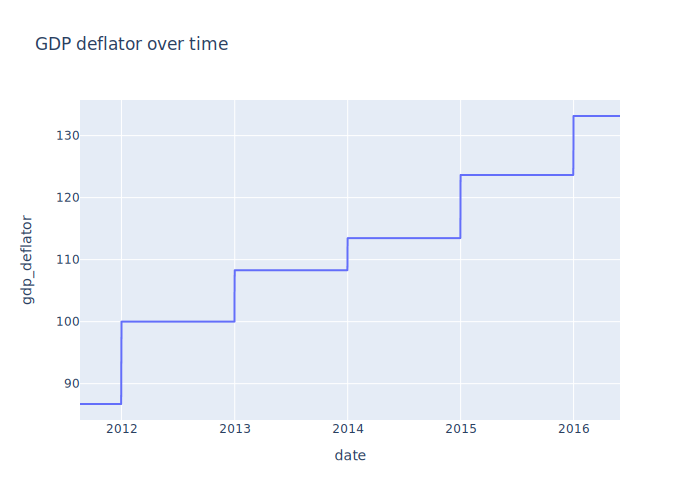

count    1746.000000
mean      111.344730
std        12.220722
min        86.721000
25%       100.000000
50%       113.465000
75%       123.661000
max       133.160000
Name: gdp_deflator, dtype: float64


In [47]:
fig = px.line(inflation_df, x='date', y='gdp_deflator', title='GDP deflator over time')
fig.show()
print(inflation_df['gdp_deflator'].describe())

#### Inflation Integrity

In [48]:
# fix the gdp deflator of 2011 to 100 and the rest of them accordingly
fix = inflation_df[inflation_df['year'] == 2011]['gdp_deflator'].values[0] - 100
inflation_df['gdp_deflator'] = inflation_df['gdp_deflator'] - fix
inflation_df['inflation_from_8_2011'] = inflation_df['gdp_deflator'].apply(lambda x: deflator_to_inflation_rate(x, 100))

In [49]:
# for annual inflation growth rate we will use the inflation from 8/2011  
annual_inflation_df = pd.DataFrame(inflation_df[['year', 'gdp_deflator', 'inflation_from_8_2011']].drop_duplicates(subset=['year']))
annual_inflation_df.set_index('year', inplace=True)
for i in range(2012, 2017):
    annual_inflation_df.loc[i, 'inflation_growth'] = annual_inflation_df.loc[i, 'inflation_from_8_2011'] - annual_inflation_df.loc[i-1, 'inflation_from_8_2011'] 
annual_inflation_df.loc[2011, 'inflation_growth'] = 0
annual_inflation_df



gdp_deflator  inflation_from_8_2011  inflation_growth
year                                                       
2011       100.000                0.00000           0.00000
2012       113.279                0.13279           0.13279
2013       121.578                0.21578           0.08299
2014       126.744                0.26744           0.05166
2015       136.940                0.36940           0.10196
2016       146.439                0.46439           0.09499

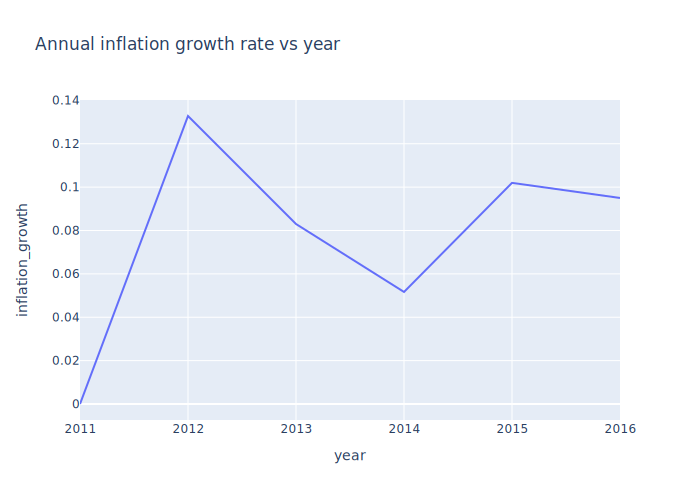

In [50]:
# annual inflation growth rate vs year ployline
fig = px.line(annual_inflation_df, x=annual_inflation_df.index, y='inflation_growth', title='Annual inflation growth rate vs year')
fig.show()

In [51]:
# add the inflation growth rate to the inflation dataframe
inflation_df.set_index('year', inplace=True)
inflation_df['annual_inflation_growth'] = annual_inflation_df['inflation_growth']
inflation_df.reset_index(inplace=True)
inflation_df


year       date  quarter  month    cpi    ppi  gdp_deflator  \
0     2011 2011-08-20        3      8  354.0  420.7       100.000   
1     2011 2011-08-21        3      8  354.0  420.7       100.000   
2     2011 2011-08-22        3      8  354.0  420.7       100.000   
3     2011 2011-08-23        3      8  354.0  420.7       100.000   
4     2011 2011-08-24        3      8  354.0  420.7       100.000   
...    ...        ...      ...    ...    ...    ...           ...   
1741  2016 2016-05-26        2      5  523.2  584.0       146.439   
1742  2016 2016-05-27        2      5  523.2  584.0       146.439   
1743  2016 2016-05-28        2      5  523.2  584.0       146.439   
1744  2016 2016-05-29        2      5  523.2  584.0       146.439   
1745  2016 2016-05-30        2      5  523.2  584.0       146.439   

      inflation_from_8_2011  annual_inflation_growth  
0                   0.00000                  0.00000  
1                   0.00000                  0.00000  
2                   0.00000                  0.00000  
3                   0.00000                  0.00000  
4                   0.00000                  0.00000  
...                     ...                      ...  
1741                0.46439                  0.09499  
1742                0.46439                  0.09499  
1743                0.46439                  0.09499  
1744                0.46439                  0.09499  
1745                0.46439                  0.09499  

[1746 rows x 9 columns]

#### cpi and ppi correlation with inflation rate

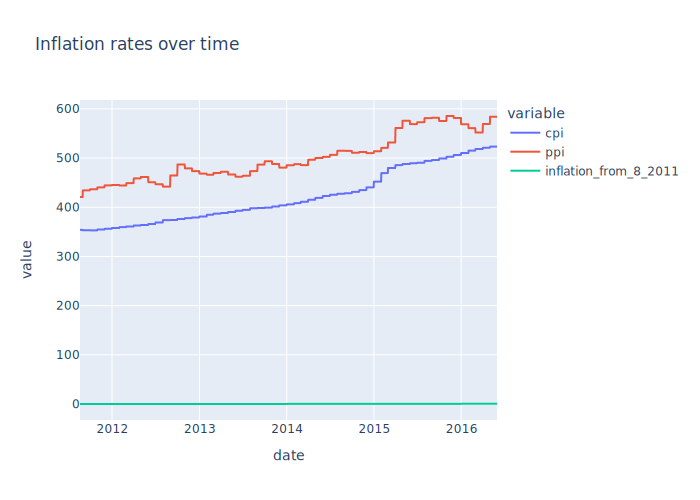

In [52]:
# plot 3 lines together
fig = px.line(inflation_df, x='date', y=['cpi', 'ppi', 'inflation_from_8_2011'], title='Inflation rates over time', color='variable')
fig.show()

In [53]:
inflation_df['cpi'].values[0]

354.0

In [54]:
# turn cpi and ppi to growths frrom 8 2011
cpifix = 100 - inflation_df['cpi'].values[0]
ppifix = 100 - inflation_df['ppi'].values[0]
inflation_df['cpi'] = inflation_df['cpi'] + cpifix
inflation_df['ppi'] = inflation_df['ppi'] + ppifix
inflation_df['cpi_growth'] = inflation_df['cpi'].apply(lambda x: deflator_to_inflation_rate(x, 100))
inflation_df['ppi_growth'] = inflation_df['ppi'].apply(lambda x: deflator_to_inflation_rate(x, 100))

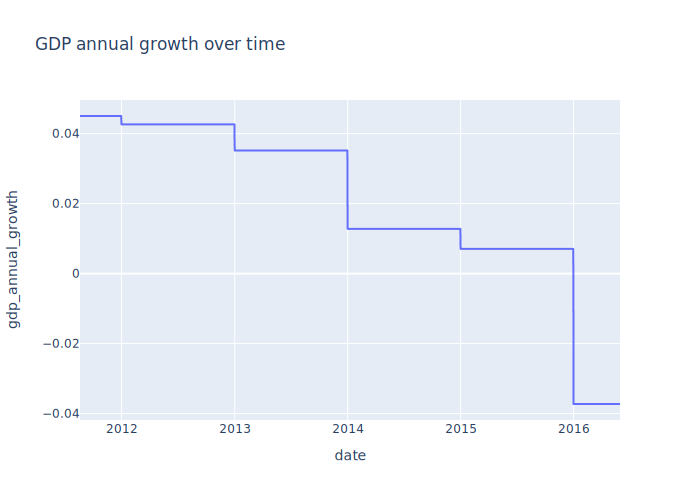

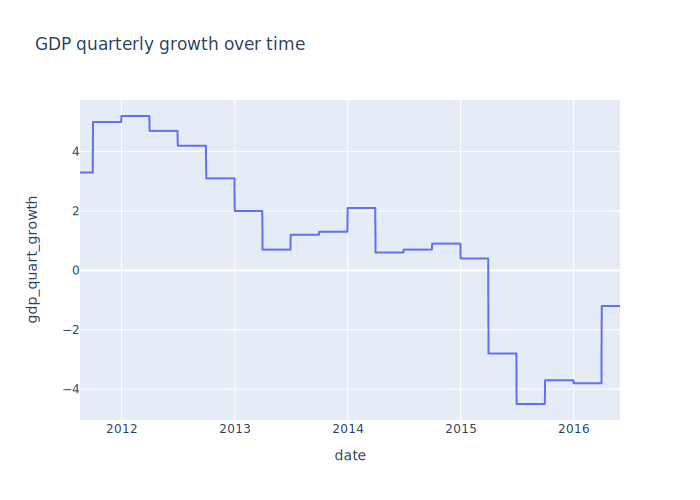

In [55]:
gdp_dfd = gdp.copy(deep=True)
# check the gdp growth over time( anuualy vs quarterly) plotly express
fig = px.line(gdp_dfd, x='date', y='gdp_annual_growth', title='GDP annual growth over time')
fig.show()
fig = px.line(gdp_dfd, x='date', y='gdp_quart_growth', title='GDP quarterly growth over time')
fig.show()

In [56]:
# create a df with the quart gdp growth for each quarter in each year no duplicates
gdp_dfd_quart = pd.DataFrame(gdp_dfd[['year', 'quarter', 'gdp_quart_growth']].drop_duplicates())
# setting yaer, quarter as index, and divide by 100 to get the percentage
gdp_dfd_quart['gdp_quart_growth'] = gdp_dfd_quart['gdp_quart_growth'].apply(lambda x: x/100)
gdp_dfd_quart.set_index(['year', 'quarter'], inplace=True)
gdp_dfd_quart['gdp_quart_growth_since_2011'] = gdp_dfd_quart['gdp_quart_growth'].cumsum()
gdp_dfd_quart

gdp_quart_growth  gdp_quart_growth_since_2011
year quarter                                               
2011 3                   0.033                        0.033
     4                   0.050                        0.083
2012 1                   0.052                        0.135
     2                   0.047                        0.182
     3                   0.042                        0.224
     4                   0.031                        0.255
2013 1                   0.020                        0.275
     2                   0.007                        0.282
     3                   0.012                        0.294
     4                   0.013                        0.307
2014 1                   0.021                        0.328
     2                   0.006                        0.334
     3                   0.007                        0.341
     4                   0.009                        0.350
2015 1                   0.004                        0.354
     2                  -0.028                        0.326
     3                  -0.045                        0.281
     4                  -0.037                        0.244
2016 1                  -0.038                        0.206
     2                  -0.012                        0.194

In [57]:
# adding the gdp growth sum to relevant rows in the gdp df
gdp_dfd.set_index(['year', 'quarter'], inplace=True)
gdp_dfd['gdp_quart_growth_since_2011'] = gdp_dfd_quart['gdp_quart_growth_since_2011']
gdp_dfd.reset_index(inplace=True)
gdp_dfd.head(17)


year  quarter       date  month  gdp_quart  gdp_quart_growth  \
0   2011        3 2011-08-20      8    14313.7               3.3   
1   2011        3 2011-08-21      8    14313.7               3.3   
2   2011        3 2011-08-22      8    14313.7               3.3   
3   2011        3 2011-08-23      8    14313.7               3.3   
4   2011        3 2011-08-24      8    14313.7               3.3   
5   2011        3 2011-08-25      8    14313.7               3.3   
6   2011        3 2011-08-26      8    14313.7               3.3   
7   2011        3 2011-08-27      8    14313.7               3.3   
8   2011        3 2011-08-28      8    14313.7               3.3   
9   2011        3 2011-08-29      8    14313.7               3.3   
10  2011        3 2011-08-30      8    14313.7               3.3   
11  2011        3 2011-08-31      8    14313.7               3.3   
12  2011        3 2011-09-01      9    14313.7               3.3   
13  2011        3 2011-09-02      9    14313.7               3.3   
14  2011        3 2011-09-03      9    14313.7               3.3   
15  2011        3 2011-09-04      9    14313.7               3.3   
16  2011        3 2011-09-05      9    14313.7               3.3   

    gdp_deflator  gdp_annual  gdp_annual_growth  gdp_quart_growth_since_2011  
0         86.721     46308.5           0.045037                        0.033  
1         86.721     46308.5           0.045037                        0.033  
2         86.721     46308.5           0.045037                        0.033  
3         86.721     46308.5           0.045037                        0.033  
4         86.721     46308.5           0.045037                        0.033  
5         86.721     46308.5           0.045037                        0.033  
6         86.721     46308.5           0.045037                        0.033  
7         86.721     46308.5           0.045037                        0.033  
8         86.721     46308.5           0.045037                        0.033  
9         86.721     46308.5           0.045037                        0.033  
10        86.721     46308.5           0.045037                        0.033  
11        86.721     46308.5           0.045037                        0.033  
12        86.721     46308.5           0.045037                        0.033  
13        86.721     46308.5           0.045037                        0.033  
14        86.721     46308.5           0.045037                        0.033  
15        86.721     46308.5           0.045037                        0.033  
16        86.721     46308.5           0.045037                        0.033

In [58]:
gdp_dfd_year = pd.DataFrame(gdp_dfd[['year', 'gdp_annual_growth']].drop_duplicates())
gdp_dfd_year.set_index('year', inplace=True)
gdp_dfd_year['gdp_annual_growth_since_2011'] = gdp_dfd_year['gdp_annual_growth'].cumsum()
gdp_dfd_year



gdp_annual_growth  gdp_annual_growth_since_2011
year                                                 
2011           0.045037                      0.045037
2012           0.042644                      0.087681
2013           0.035179                      0.122859
2014           0.012795                      0.135654
2015           0.007065                      0.142719
2016          -0.037267                      0.105452

In [59]:
# insert the new feature to gdp dfd
gdp_dfd.set_index('year', inplace=True)
gdp_dfd['gdp_annual_growth_since_2011'] = gdp_dfd_year['gdp_annual_growth_since_2011']
gdp_dfd.reset_index(inplace=True)
gdp_dfd['gdp_quart_growth'] = gdp_dfd['gdp_quart_growth'].apply(lambda x: x/100)

In [60]:
#adjusting the gdp growth rates so they will start from 0 in 2011
gdp_dfd['gdp_annual_growth'] = gdp_dfd['gdp_annual_growth'] - gdp_dfd[gdp_dfd['year'] == 2011]['gdp_annual_growth'].values[0]
gdp_dfd['gdp_annual_growth_since_2011'] = gdp_dfd['gdp_annual_growth_since_2011'] - gdp_dfd[gdp_dfd['year'] == 2011]['gdp_annual_growth_since_2011'].values[0]
gdp_dfd['gdp_quart_growth'] = gdp_dfd['gdp_quart_growth'] - gdp_dfd[gdp_dfd['year'] == 2011]['gdp_quart_growth'].values[0]
gdp_dfd['gdp_quart_growth_since_2011'] = gdp_dfd['gdp_quart_growth_since_2011'] - gdp_dfd[gdp_dfd['year'] == 2011]['gdp_quart_growth_since_2011'].values[0]


In [61]:
gdp_dfd.head(17)

year  quarter       date  month  gdp_quart  gdp_quart_growth  \
0   2011        3 2011-08-20      8    14313.7               0.0   
1   2011        3 2011-08-21      8    14313.7               0.0   
2   2011        3 2011-08-22      8    14313.7               0.0   
3   2011        3 2011-08-23      8    14313.7               0.0   
4   2011        3 2011-08-24      8    14313.7               0.0   
5   2011        3 2011-08-25      8    14313.7               0.0   
6   2011        3 2011-08-26      8    14313.7               0.0   
7   2011        3 2011-08-27      8    14313.7               0.0   
8   2011        3 2011-08-28      8    14313.7               0.0   
9   2011        3 2011-08-29      8    14313.7               0.0   
10  2011        3 2011-08-30      8    14313.7               0.0   
11  2011        3 2011-08-31      8    14313.7               0.0   
12  2011        3 2011-09-01      9    14313.7               0.0   
13  2011        3 2011-09-02      9    14313.7               0.0   
14  2011        3 2011-09-03      9    14313.7               0.0   
15  2011        3 2011-09-04      9    14313.7               0.0   
16  2011        3 2011-09-05      9    14313.7               0.0   

    gdp_deflator  gdp_annual  gdp_annual_growth  gdp_quart_growth_since_2011  \
0         86.721     46308.5                0.0                          0.0   
1         86.721     46308.5                0.0                          0.0   
2         86.721     46308.5                0.0                          0.0   
3         86.721     46308.5                0.0                          0.0   
4         86.721     46308.5                0.0                          0.0   
5         86.721     46308.5                0.0                          0.0   
6         86.721     46308.5                0.0                          0.0   
7         86.721     46308.5                0.0                          0.0   
8         86.721     46308.5                0.0                          0.0   
9         86.721     46308.5                0.0                          0.0   
10        86.721     46308.5                0.0                          0.0   
11        86.721     46308.5                0.0                          0.0   
12        86.721     46308.5                0.0                          0.0   
13        86.721     46308.5                0.0                          0.0   
14        86.721     46308.5                0.0                          0.0   
15        86.721     46308.5                0.0                          0.0   
16        86.721     46308.5                0.0                          0.0   

    gdp_annual_growth_since_2011  
0                            0.0  
1                            0.0  
2                            0.0  
3                            0.0  
4                            0.0  
5                            0.0  
6                            0.0  
7                            0.0  
8                            0.0  
9                            0.0  
10                           0.0  
11                           0.0  
12                           0.0  
13                           0.0  
14                           0.0  
15                           0.0  
16                           0.0

#### merge inflation gdp

In [62]:
# merge new features together to one df
inf_gdp_merged = inflation_df.merge(gdp_dfd, on=['date', 'quarter', 'year', 'month'])
# date feature and growth features only
inf_gdp_merged_total_growth = inf_gdp_merged[['date', 'quarter', 'year', 'month', 'inflation_from_8_2011', 'gdp_quart_growth_since_2011', 'gdp_annual_growth_since_2011']]
inf_gdp_merged_period_growth = inf_gdp_merged[['date', 'quarter', 'year', 'month', 'annual_inflation_growth', 'gdp_quart_growth', 'gdp_annual_growth']]
inf_gdp_merged_total_growth

date  quarter  year  month  inflation_from_8_2011  \
0    2011-08-20        3  2011      8                0.00000   
1    2011-08-21        3  2011      8                0.00000   
2    2011-08-22        3  2011      8                0.00000   
3    2011-08-23        3  2011      8                0.00000   
4    2011-08-24        3  2011      8                0.00000   
...         ...      ...   ...    ...                    ...   
1741 2016-05-26        2  2016      5                0.46439   
1742 2016-05-27        2  2016      5                0.46439   
1743 2016-05-28        2  2016      5                0.46439   
1744 2016-05-29        2  2016      5                0.46439   
1745 2016-05-30        2  2016      5                0.46439   

      gdp_quart_growth_since_2011  gdp_annual_growth_since_2011  
0                           0.000                      0.000000  
1                           0.000                      0.000000  
2                           0.000                      0.000000  
3                           0.000                      0.000000  
4                           0.000                      0.000000  
...                           ...                           ...  
1741                        0.161                      0.060415  
1742                        0.161                      0.060415  
1743                        0.161                      0.060415  
1744                        0.161                      0.060415  
1745                        0.161                      0.060415  

[1746 rows x 7 columns]

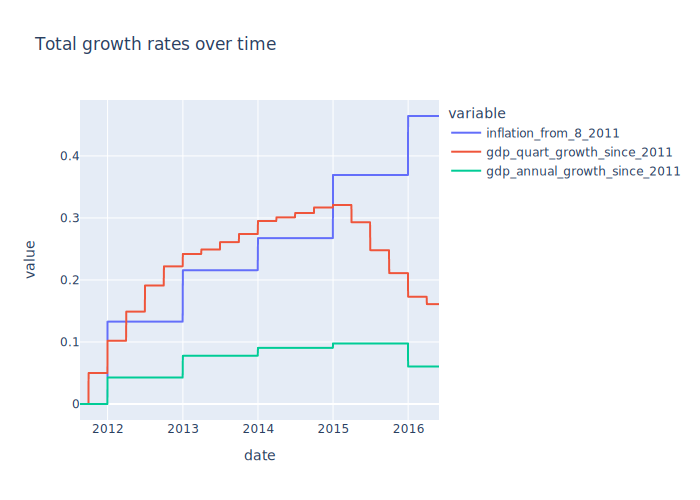

In [63]:
# plot all total_growth features together over time using plotly express
fig = px.line(inf_gdp_merged_total_growth, x='date', y=['inflation_from_8_2011', 'gdp_quart_growth_since_2011', 'gdp_annual_growth_since_2011'], title='Total growth rates over time', color='variable')
fig.show()

In [64]:
inf_gdp_merged_period_growth

date  quarter  year  month  annual_inflation_growth  \
0    2011-08-20        3  2011      8                  0.00000   
1    2011-08-21        3  2011      8                  0.00000   
2    2011-08-22        3  2011      8                  0.00000   
3    2011-08-23        3  2011      8                  0.00000   
4    2011-08-24        3  2011      8                  0.00000   
...         ...      ...   ...    ...                      ...   
1741 2016-05-26        2  2016      5                  0.09499   
1742 2016-05-27        2  2016      5                  0.09499   
1743 2016-05-28        2  2016      5                  0.09499   
1744 2016-05-29        2  2016      5                  0.09499   
1745 2016-05-30        2  2016      5                  0.09499   

      gdp_quart_growth  gdp_annual_growth  
0                0.000           0.000000  
1                0.000           0.000000  
2                0.000           0.000000  
3                0.000           0.000000  
4                0.000           0.000000  
...                ...                ...  
1741            -0.045          -0.082304  
1742            -0.045          -0.082304  
1743            -0.045          -0.082304  
1744            -0.045          -0.082304  
1745            -0.045          -0.082304  

[1746 rows x 7 columns]

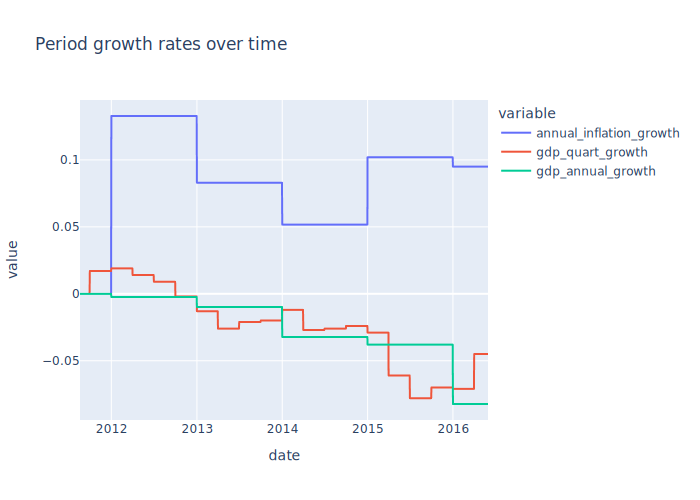

In [65]:
# plot period growth features together over time using plotly express
fig = px.line(inf_gdp_merged_period_growth, x='date', y=['annual_inflation_growth', 'gdp_quart_growth', 'gdp_annual_growth'], title='Period growth rates over time', color='variable')
fig.show()

In [66]:
# group the period growth features by year and month
inf_gdp_merged_monthly_growth = inf_gdp_merged_period_growth.groupby(['year', 'month']).mean()
inf_gdp_merged_monthly_growth.reset_index(inplace=True)
inf_gdp_merged_monthly_growth
## the same per quarter
inf_gdp_merged_quarterly_growth = inf_gdp_merged_period_growth.groupby(['year', 'quarter']).mean()
inf_gdp_merged_quarterly_growth.reset_index(inplace=True)
inf_gdp_merged_quarterly_growth

year  quarter                date      month  annual_inflation_growth  \
0   2011        3 2011-09-09 12:00:00   8.714286                  0.00000   
1   2011        4 2011-11-15 12:00:00  11.000000                  0.00000   
2   2012        1 2012-02-15 00:00:00   2.000000                  0.13279   
3   2012        2 2012-05-16 00:00:00   5.000000                  0.13279   
4   2012        3 2012-08-15 12:00:00   7.989130                  0.13279   
5   2012        4 2012-11-15 12:00:00  11.000000                  0.13279   
6   2013        1 2013-02-14 12:00:00   2.000000                  0.08299   
7   2013        2 2013-05-16 00:00:00   5.000000                  0.08299   
8   2013        3 2013-08-15 12:00:00   7.989130                  0.08299   
9   2013        4 2013-11-15 12:00:00  11.000000                  0.08299   
10  2014        1 2014-02-14 12:00:00   2.000000                  0.05166   
11  2014        2 2014-05-16 00:00:00   5.000000                  0.05166   
12  2014        3 2014-08-15 12:00:00   7.989130                  0.05166   
13  2014        4 2014-11-15 12:00:00  11.000000                  0.05166   
14  2015        1 2015-02-14 12:00:00   2.000000                  0.10196   
15  2015        2 2015-05-16 00:00:00   5.000000                  0.10196   
16  2015        3 2015-08-15 12:00:00   7.989130                  0.10196   
17  2015        4 2015-11-15 12:00:00  11.000000                  0.10196   
18  2016        1 2016-02-15 00:00:00   2.000000                  0.09499   
19  2016        2 2016-04-30 12:00:00   4.500000                  0.09499   

    gdp_quart_growth  gdp_annual_growth  
0              0.000           0.000000  
1              0.017           0.000000  
2              0.019          -0.002394  
3              0.014          -0.002394  
4              0.009          -0.002394  
5             -0.002          -0.002394  
6             -0.013          -0.009858  
7             -0.026          -0.009858  
8             -0.021          -0.009858  
9             -0.020          -0.009858  
10            -0.012          -0.032242  
11            -0.027          -0.032242  
12            -0.026          -0.032242  
13            -0.024          -0.032242  
14            -0.029          -0.037972  
15            -0.061          -0.037972  
16            -0.078          -0.037972  
17            -0.070          -0.037972  
18            -0.071          -0.082304  
19            -0.045          -0.082304

In [67]:
# for all ratings we found creating a wining function
def wine_rate(input_rating, input_period_in_year, output_period):
   return (1 + input_rating)**(output_period/input_period_in_year) - 1

In [68]:
inf_gdp_merged_quarterly_growth['wined_annual_growth_tquart'] = inf_gdp_merged_quarterly_growth['annual_inflation_growth'].apply(lambda x: wine_rate(x, 1, 4))
inf_gdp_merged_quarterly_growth['wined_gdp_quart_growth_tquart'] = inf_gdp_merged_quarterly_growth['gdp_quart_growth'].apply(lambda x: wine_rate(x, 1, 4))

In [69]:
# predict quarterly inflation growth rate using the annual inflation growth rate, and the gdp growth rates
X = inf_gdp_merged_quarterly_growth[['annual_inflation_growth', 'gdp_quart_growth', 'gdp_annual_growth']]
# use a wined annual inflation growth rate as the constant for the model to predict the quarterly inflation growth rate


In [70]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Define the independent variables (features)
X = inf_gdp_merged_quarterly_growth[['annual_inflation_growth', 'gdp_quart_growth', 'gdp_annual_growth']]

# Use the annual inflation growth rate as a constant for prediction
constant = inf_gdp_merged_quarterly_growth['annual_inflation_growth'].mean()

# Predict the quarterly inflation growth rate using a simple aggregation (e.g., mean or median)
predicted_quarterly_inflation_growth = X.mean(axis=1)  # You can also use other aggregation functions like median

# Print the predicted quarterly inflation growth rate
print("Predicted Quarterly Inflation Growth Rate:")
print(predicted_quarterly_inflation_growth)
# MAKINg sure to add a zero in the first row
predicted_quarterly_inflation_growth = pd.concat([pd.Series([0]), predicted_quarterly_inflation_growth], ignore_index=True)
# Print the predicted quarterly inflation growth rate
print("Predicted Quarterly Inflation Growth Rate:")
print(predicted_quarterly_inflation_growth)


Predicted Quarterly Inflation Growth Rate:
0     0.000000
1     0.005667
2     0.049799
3     0.048132
4     0.046465
5     0.042799
6     0.020044
7     0.015711
8     0.017377
9     0.017711
10    0.002473
11   -0.002527
12   -0.002194
13   -0.001527
14    0.011663
15    0.000996
16   -0.004671
17   -0.002004
18   -0.019438
19   -0.010771
dtype: float64
Predicted Quarterly Inflation Growth Rate:
0     0.000000
1     0.000000
2     0.005667
3     0.049799
4     0.048132
5     0.046465
6     0.042799
7     0.020044
8     0.015711
9     0.017377
10    0.017711
11    0.002473
12   -0.002527
13   -0.002194
14   -0.001527
15    0.011663
16    0.000996
17   -0.004671
18   -0.002004
19   -0.019438
20   -0.010771
dtype: float64


In [71]:
# add the predicted quarterly inflation growth rate to the dataframe
inf_gdp_merged_quarterly_growth['predicted_quarterly_inflation_growth'] = predicted_quarterly_inflation_growth
inf_gdp_merged_quarterly_growth

year  quarter                date      month  annual_inflation_growth  \
0   2011        3 2011-09-09 12:00:00   8.714286                  0.00000   
1   2011        4 2011-11-15 12:00:00  11.000000                  0.00000   
2   2012        1 2012-02-15 00:00:00   2.000000                  0.13279   
3   2012        2 2012-05-16 00:00:00   5.000000                  0.13279   
4   2012        3 2012-08-15 12:00:00   7.989130                  0.13279   
5   2012        4 2012-11-15 12:00:00  11.000000                  0.13279   
6   2013        1 2013-02-14 12:00:00   2.000000                  0.08299   
7   2013        2 2013-05-16 00:00:00   5.000000                  0.08299   
8   2013        3 2013-08-15 12:00:00   7.989130                  0.08299   
9   2013        4 2013-11-15 12:00:00  11.000000                  0.08299   
10  2014        1 2014-02-14 12:00:00   2.000000                  0.05166   
11  2014        2 2014-05-16 00:00:00   5.000000                  0.05166   
12  2014        3 2014-08-15 12:00:00   7.989130                  0.05166   
13  2014        4 2014-11-15 12:00:00  11.000000                  0.05166   
14  2015        1 2015-02-14 12:00:00   2.000000                  0.10196   
15  2015        2 2015-05-16 00:00:00   5.000000                  0.10196   
16  2015        3 2015-08-15 12:00:00   7.989130                  0.10196   
17  2015        4 2015-11-15 12:00:00  11.000000                  0.10196   
18  2016        1 2016-02-15 00:00:00   2.000000                  0.09499   
19  2016        2 2016-04-30 12:00:00   4.500000                  0.09499   

    gdp_quart_growth  gdp_annual_growth  wined_annual_growth_tquart  \
0              0.000           0.000000                    0.000000   
1              0.017           0.000000                    0.000000   
2              0.019          -0.002394                    0.646636   
3              0.014          -0.002394                    0.646636   
4              0.009          -0.002394                    0.646636   
5             -0.002          -0.002394                    0.646636   
6             -0.013          -0.009858                    0.375618   
7             -0.026          -0.009858                    0.375618   
8             -0.021          -0.009858                    0.375618   
9             -0.020          -0.009858                    0.375618   
10            -0.012          -0.032242                    0.223211   
11            -0.027          -0.032242                    0.223211   
12            -0.026          -0.032242                    0.223211   
13            -0.024          -0.032242                    0.223211   
14            -0.029          -0.037972                    0.474563   
15            -0.061          -0.037972                    0.474563   
16            -0.078          -0.037972                    0.474563   
17            -0.070          -0.037972                    0.474563   
18            -0.071          -0.082304                    0.437608   
19            -0.045          -0.082304                    0.437608   

    wined_gdp_quart_growth_tquart  predicted_quarterly_inflation_growth  
0                        0.000000                              0.000000  
1                        0.069754                              0.000000  
2                        0.078194                              0.005667  
3                        0.057187                              0.049799  
4                        0.036489                              0.048132  
5                       -0.007976                              0.046465  
6                       -0.050995                              0.042799  
7                       -0.100014                              0.020044  
8                       -0.081391                              0.015711  
9                       -0.077632                              0.017377  
10                      -0.047143                              0.017711  
11    

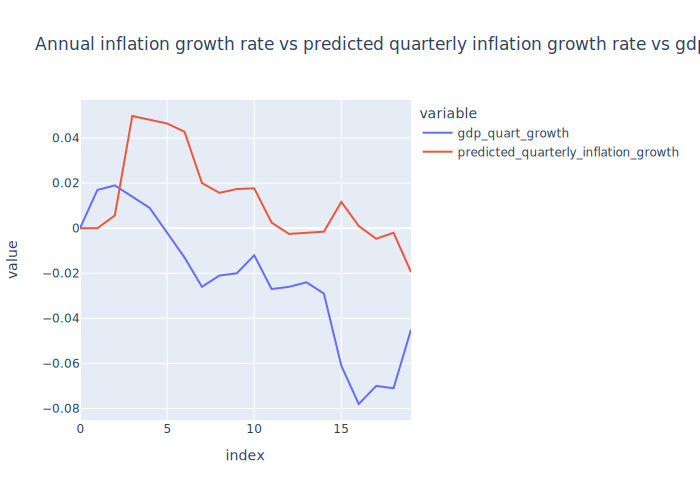

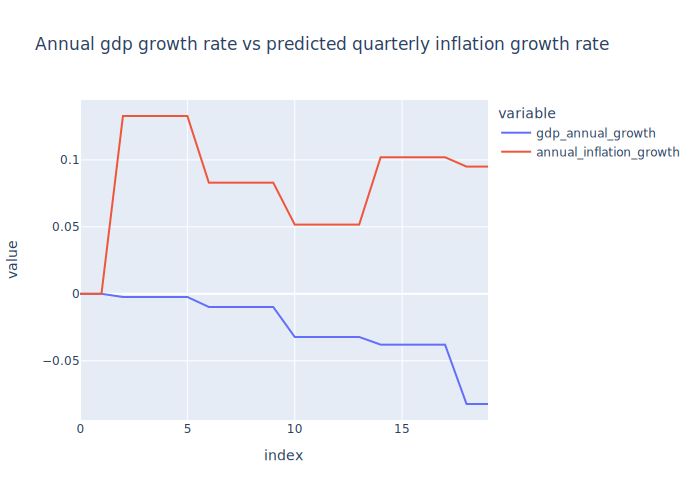

In [72]:
## plot the predicted quarterly inflation growth rate vs the actual quarterly gdp_growth as well as the annual inflation growth rate and annual gdp growth rate
### over time
fig = px.line(inf_gdp_merged_quarterly_growth, x= inf_gdp_merged_quarterly_growth.index, y=[ 'gdp_quart_growth', 'predicted_quarterly_inflation_growth'], title='Annual inflation growth rate vs predicted quarterly inflation growth rate vs gdp growth rate')
fig.show()
##plot annual igdp growth rate vs predicted quarterly inflation growth rate
fig = px.line(inf_gdp_merged_quarterly_growth, x= inf_gdp_merged_quarterly_growth.index, y=['gdp_annual_growth', 'annual_inflation_growth'], title='Annual gdp growth rate vs predicted quarterly inflation growth rate')  
fig.show()

## Categorical Variables

In [73]:
def CategoricalHelper(data,target_encoding = False):
    data = data.select_dtypes('object')
    classes = {}
    for col in data.columns:
        if data[col].nunique() == 2:
            classes[col] = data[col].unique()
        elif col == 'ecology':
            classes[col] = 'Encoder'
        else:
            if target_encoding and col == 'sub_area':
                classes[col] = 'TargetEncoding'
            else:
                classes[col] = 'Dummies'
    return classes

In [74]:
ecology = ['excellent','good','satisfactory','poor', 'no data']
ecology_encoding = [4,3,2,1,-1]
encoder = dict(zip(ecology,ecology_encoding))
encoder

{'excellent': 4, 'good': 3, 'satisfactory': 2, 'poor': 1, 'no data': -1}

In [75]:
def categoricalToNumbers(data,classes,encoder,m=300):
    # Data Contains categorical variables only.
    for c in classes:
        if type(classes[c]) == str:
            if classes[c] == 'Dummies':
                dummies = pd.get_dummies(data[c])*1
                data = data.drop(columns = c).join(dummies)
            elif classes[c] == 'TargetEncoding':
                sa_grp = data.groupby(c)['price_sq'].transform('mean')
                sa_count = data[c].value_counts().to_dict()
                sa_counts = data[c].map(sa_count)
                sa_weights = (sa_counts)/(sa_counts + m)
                data[c] = sa_grp*(sa_weights) + data['price_sq'].mean()*(1-sa_weights)
            else:
                data.loc[:,c] = data[c].apply(lambda val: encoder[val])
        else:
            data.loc[:,c] = data[c].apply(lambda val: (val == 'yes')*1)
    return data

In [76]:
classes = CategoricalHelper(full_data, True)
classes.pop('product_type')
classes

{'sub_area': 'TargetEncoding',
 'culture_objects_top_25': array(['no', 'yes'], dtype=object),
 'thermal_power_plant_raion': array(['no', 'yes'], dtype=object),
 'incineration_raion': array(['no', 'yes'], dtype=object),
 'oil_chemistry_raion': array(['no', 'yes'], dtype=object),
 'radiation_raion': array(['no', 'yes'], dtype=object),
 'railroad_terminal_raion': array(['no', 'yes'], dtype=object),
 'big_market_raion': array(['no', 'yes'], dtype=object),
 'nuclear_reactor_raion': array(['no', 'yes'], dtype=object),
 'detention_facility_raion': array(['no', 'yes'], dtype=object),
 'water_1line': array(['no', 'yes'], dtype=object),
 'big_road1_1line': array(['no', 'yes'], dtype=object),
 'railroad_1line': array(['no', 'yes'], dtype=object),
 'ecology': 'Encoder'}

In [77]:
full_data = categoricalToNumbers(full_data, classes, encoder)

# Correlation Analysis

On this part we wanted to understand if our independent features correlate with each other to check if there is some redundancy in our data. So for each product type we checked the correlation within each group.

We have separated the correlation analysis for each product type

In [78]:
# Get the dtypes for each group
groups_dtypes = {group:list(groups_dfs[group].dtypes.unique()) for group in groups_dfs} # we don't need buildings anymore
groups_dtypes

{'areas': [dtype('float64'), dtype('int64')],
 'buildings': [dtype('float64')],
 'demographics': [dtype('float64')],
 'distances': [dtype('float64'), dtype('int64'), dtype('O')],
 'education': [dtype('float64')],
 'facilities': [dtype('float64'), dtype('int64'), dtype('O')],
 'interior': [dtype('int64'), dtype('O'), dtype('float64')],
 'surroundings': [dtype('O'), dtype('int64'), dtype('float64')]}

In [79]:
from matplotlib.colors import LinearSegmentedColormap

def createHeatMap(corr, group, annot=True):
    plt.figure(figsize=(10,10))
    cmap: LinearSegmentedColormap =  sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(corr, cmap=cmap, annot=annot, fmt=".2f")
    plt.title(f'Correlation Matrix of {group}')
    plt.tight_layout()
    plt.show()

In [80]:
groups_corrs = ['areas','demographics','surroundings','interior','distances'] # Groups for the correlation Analysis.

In [81]:
# Change ID's to INT
groups_dfs['distances'].loc[:,groups_dfs['distances'].filter(like='ID').columns] = groups_dfs['distances'].filter(like='ID').astype('int64')

In [82]:
# Create a dictionary for each group with the correlation matrix.
groups_floats = {group:groups_dfs[group].select_dtypes(['float64']) for group in groups_dfs}

### Investment

In [83]:
investment = full_data[full_data['product_type'] == 'Investment']
investment.drop(columns = 'product_type', inplace=True)

/var/folders/2y/5vlst1hd6jz9tggyvm776y3m0000gn/T/ipykernel_47566/514358765.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



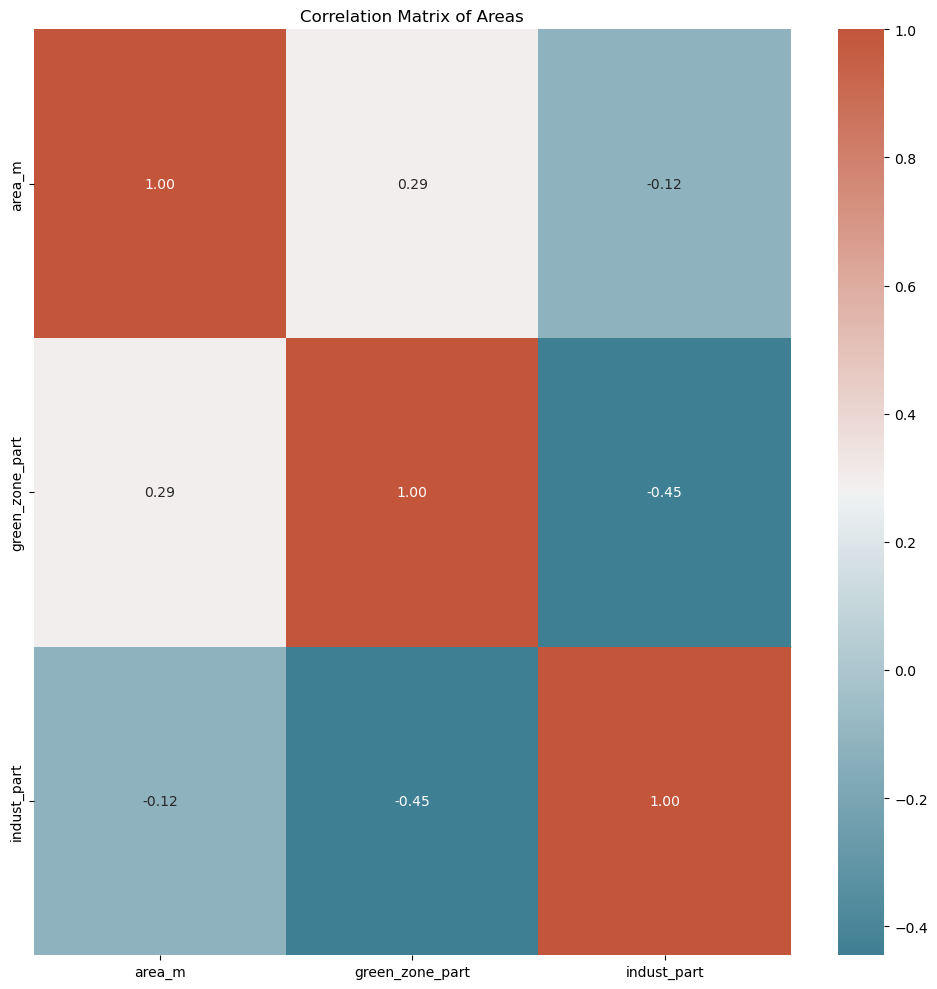

In [84]:
createHeatMap(investment[groups_floats['areas'].columns].corr(), 'Areas')

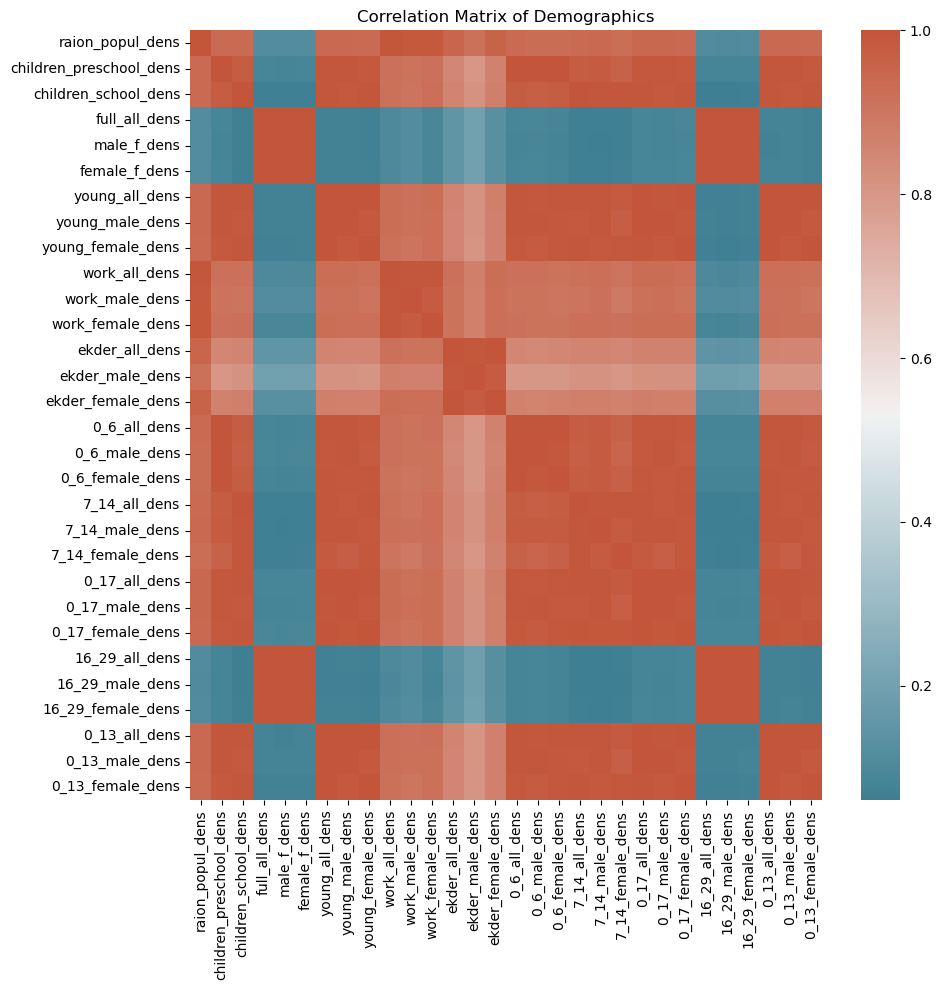

In [85]:
createHeatMap(investment[groups_floats['demographics'].columns].corr(), 'Demographics', annot=False)

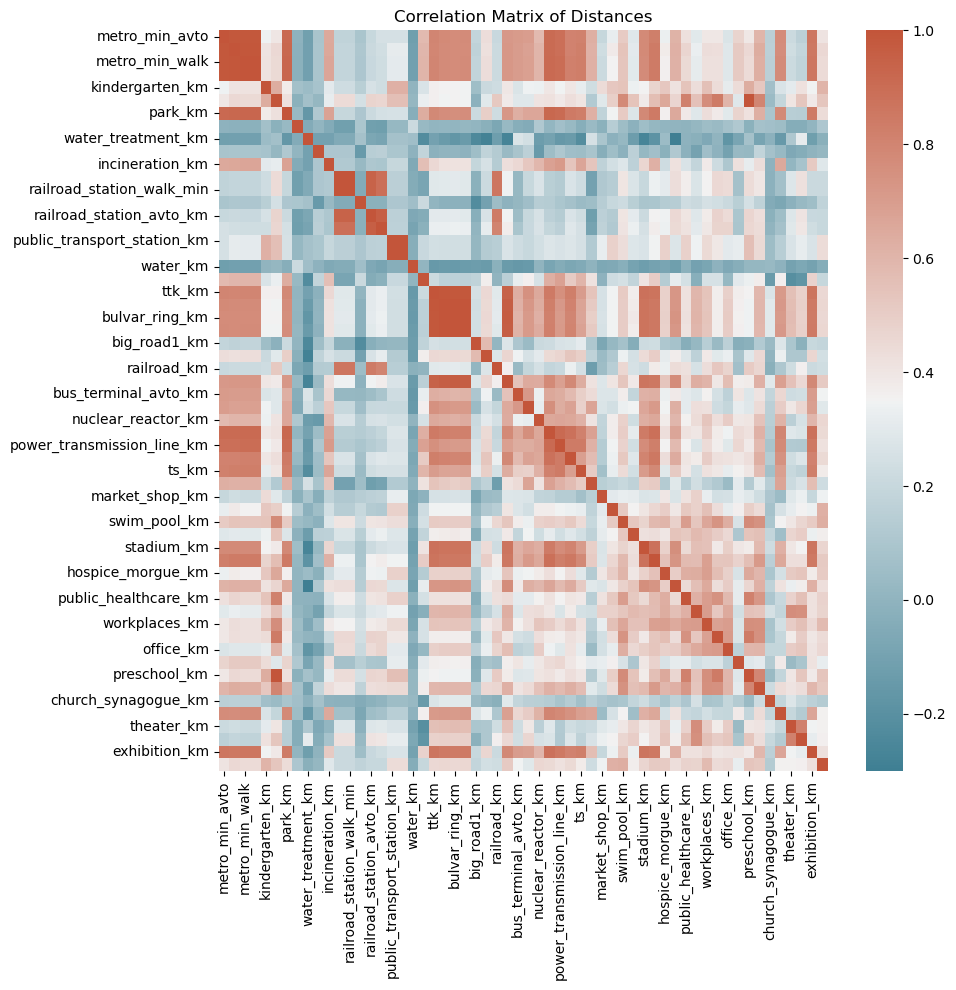

In [86]:
createHeatMap(investment[groups_floats['distances'].columns].corr(), 'Distances', annot=False)

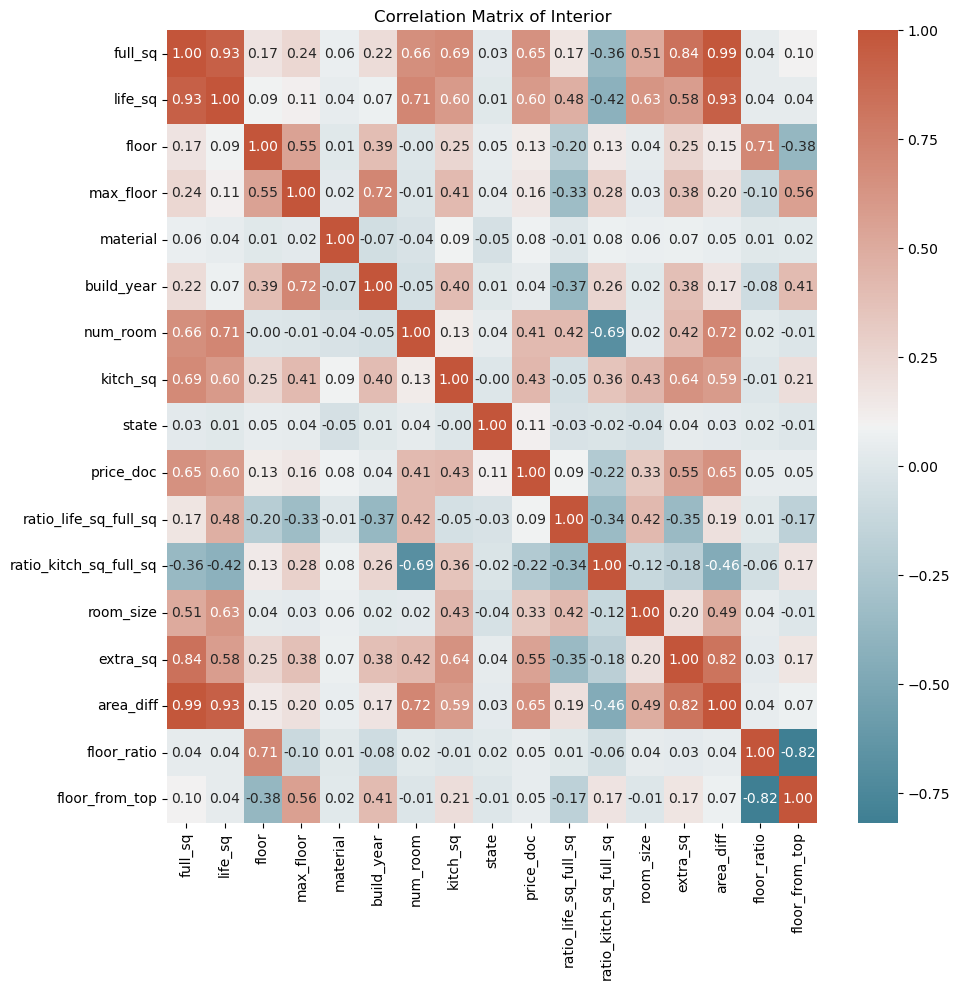

In [87]:
createHeatMap(investment[groups_floats['interior'].columns].corr(), 'Interior')

In [88]:
cafe_invst = [col for col in investment.filter(like='cafe').columns if '_binary' not in col]
green_invst = [col for col in groups_floats['surroundings'].columns if 'green' in col.lower() or 'prom' in col.lower()]

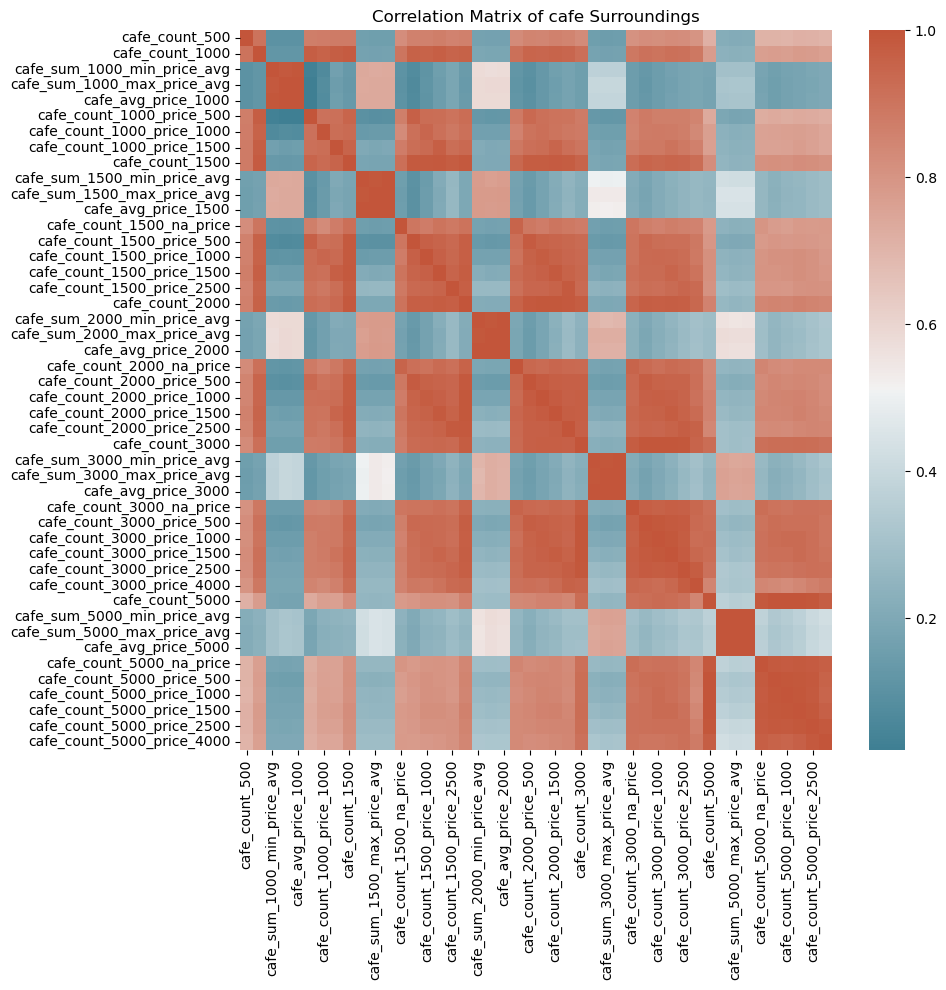

In [89]:
createHeatMap(investment[cafe_invst].corr(), 'cafe Surroundings', annot=False)

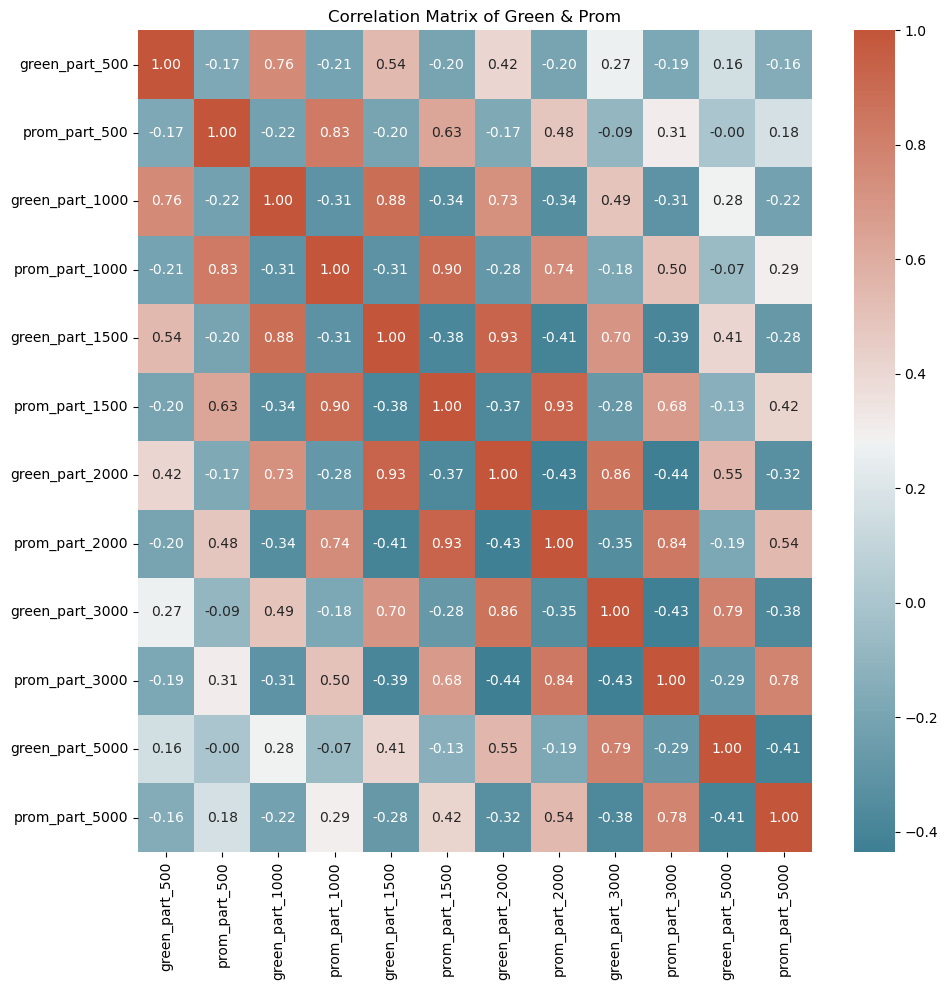

In [90]:
createHeatMap(investment[green_invst].corr(), 'Green & Prom')

### OwnerOcuppier

In [91]:
ocuppier = full_data[full_data['product_type'] == 'OwnerOccupier']
ocuppier.drop(columns = 'product_type', inplace=True)

/var/folders/2y/5vlst1hd6jz9tggyvm776y3m0000gn/T/ipykernel_47566/1144162341.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



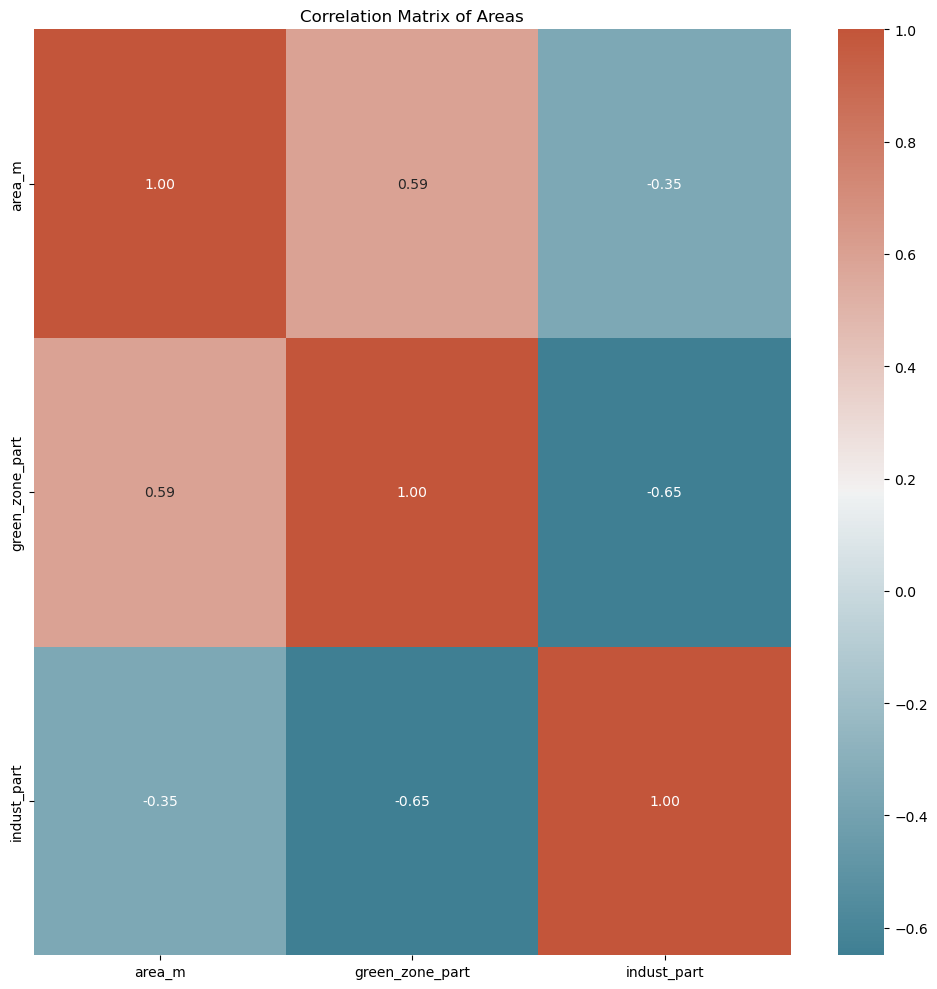

In [92]:
createHeatMap(ocuppier[groups_floats['areas'].columns].corr(), 'Areas')

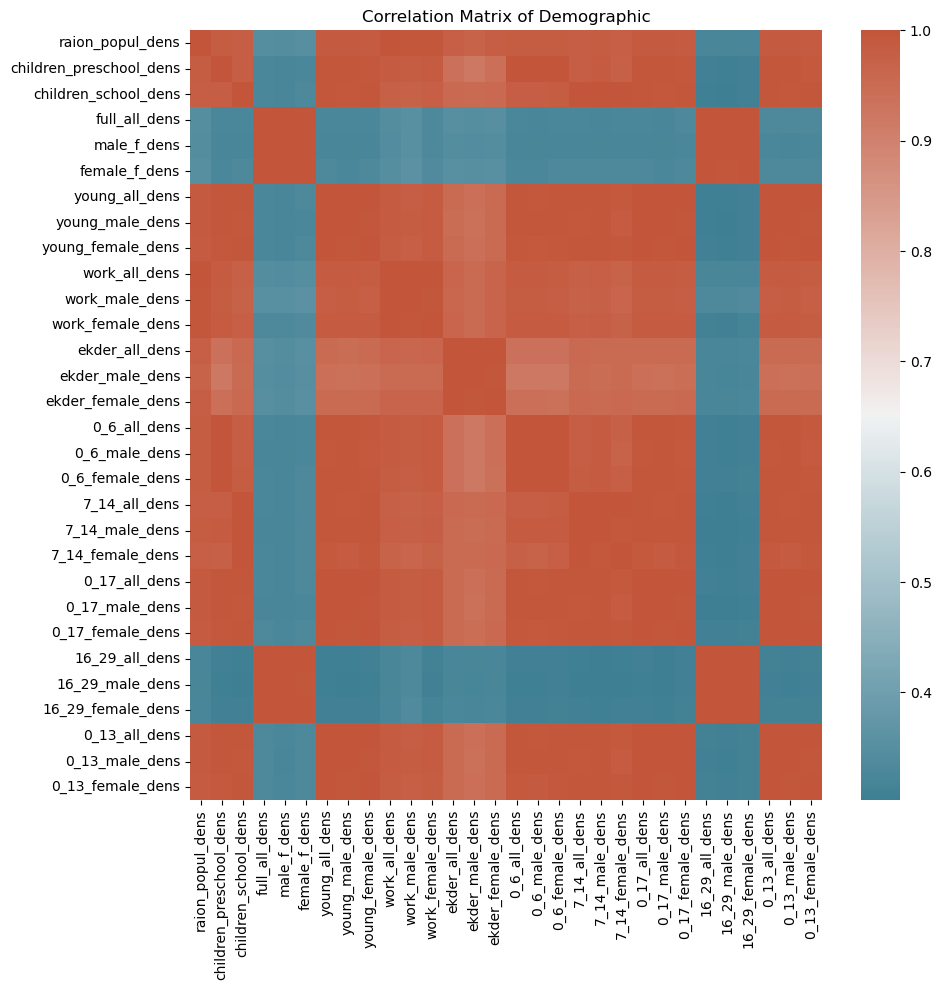

In [93]:
createHeatMap(ocuppier[groups_dfs['demographics'].columns].corr(), 'Demographic', annot=False)

In [94]:
cafe_ocu = ocuppier[[col for col in ocuppier.filter(like='cafe') if '_binary' not in col]]
green_prom_ocu =  ocuppier[ocuppier.columns[np.where(ocuppier.columns.str.contains('green','prom'))]]

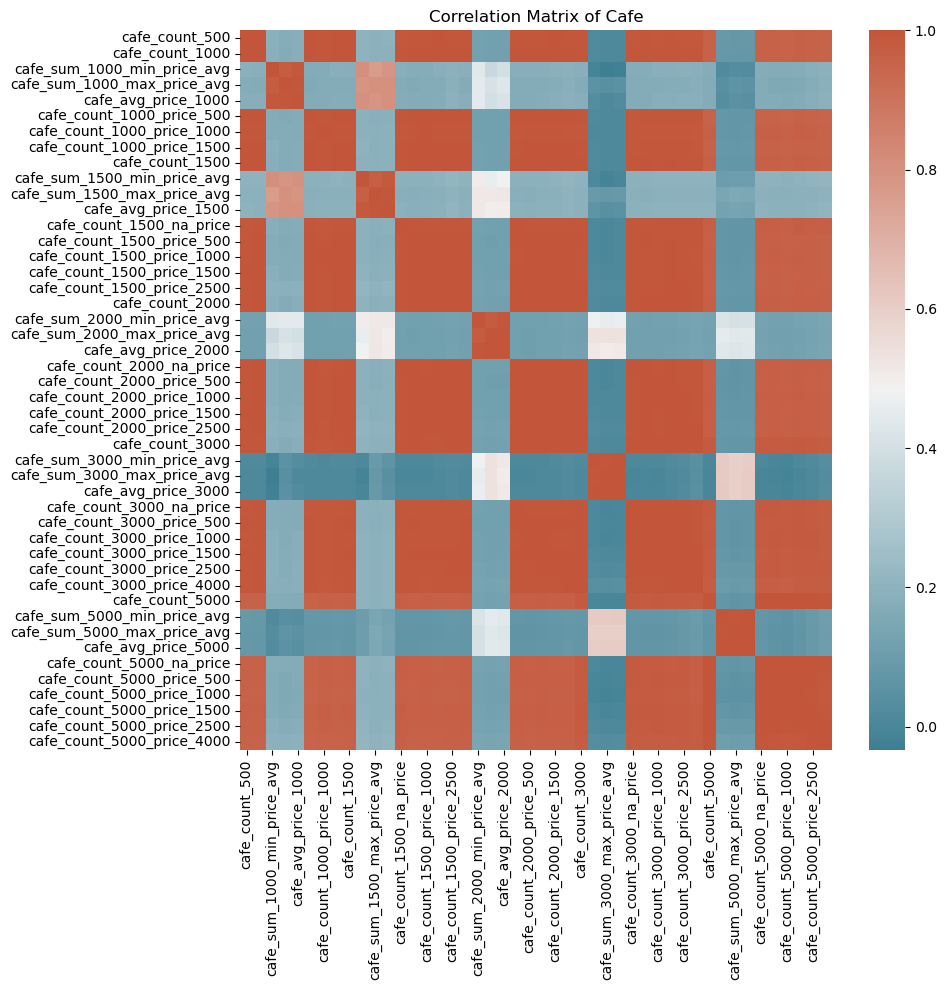

In [95]:
createHeatMap(corr=cafe_ocu.corr(), group='Cafe', annot=False)

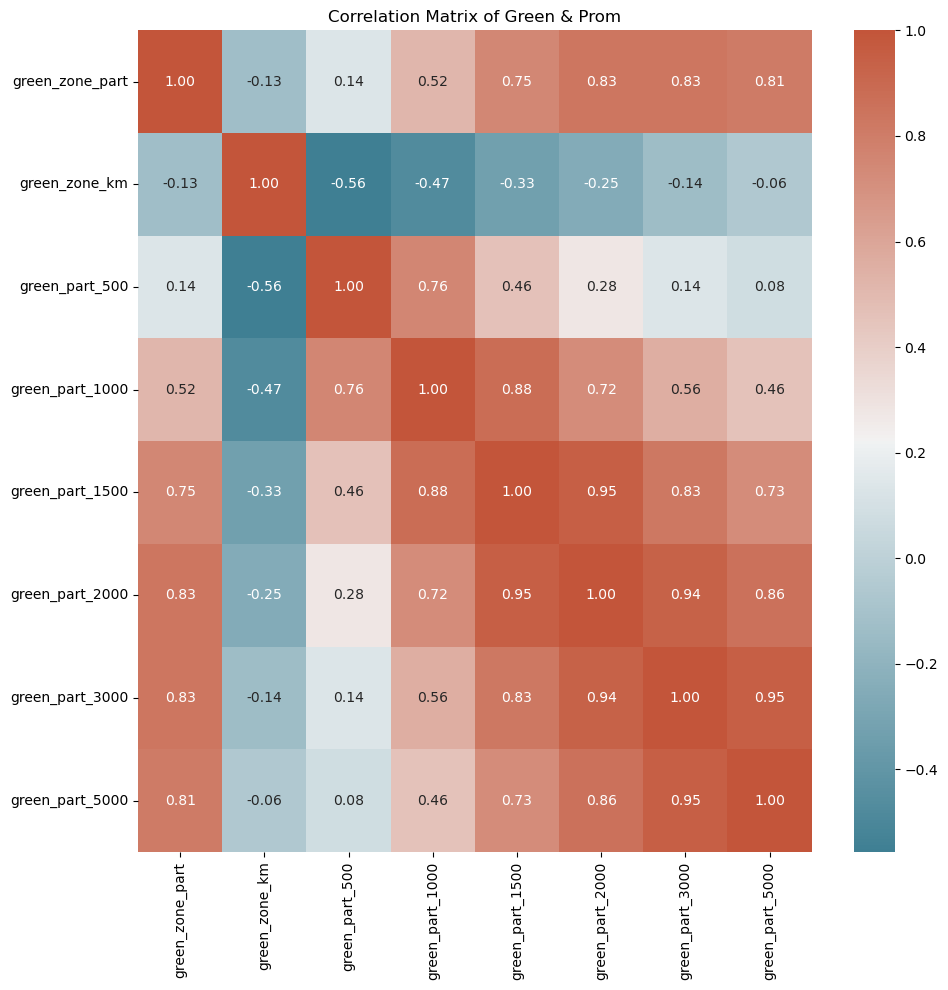

In [96]:
createHeatMap(green_prom_ocu.corr(),'Green & Prom')

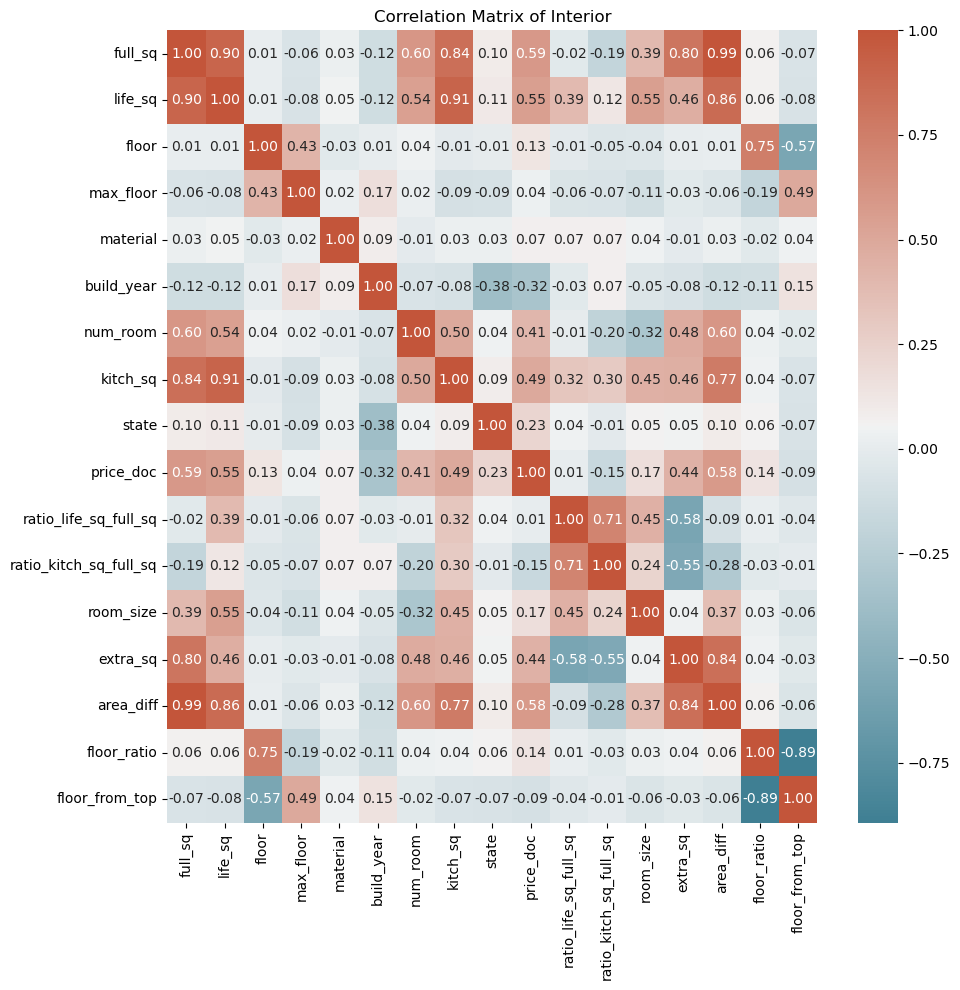

In [97]:
createHeatMap(ocuppier[groups_floats['interior'].columns].corr(), 'Interior')

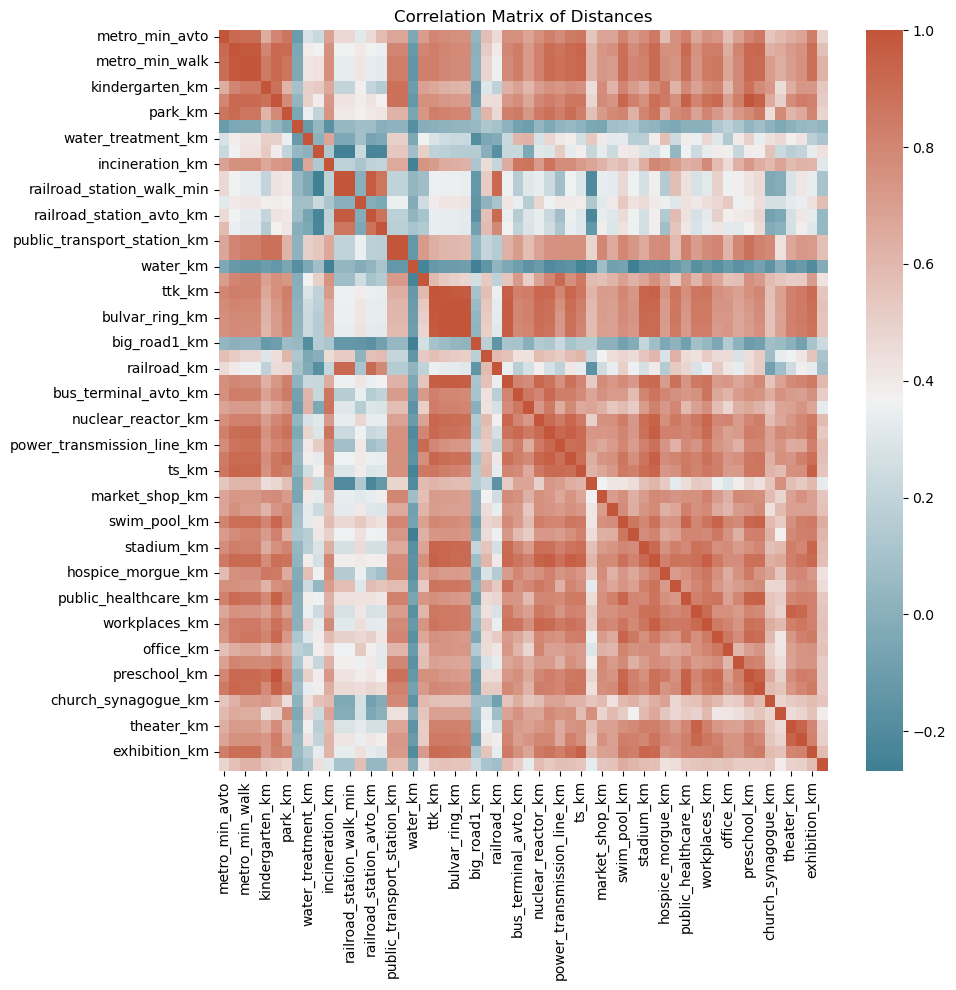

In [98]:
createHeatMap(ocuppier[groups_floats['distances'].columns].corr(), 'Distances', annot=False)

We have some high correlation between independent features which might indicate that we have some redundancy in our data this we might need to use PCA / carefully remove them.

# Principal Componenet Analysis

To handle the redundancy in our data, we'll use PCA. However, when using PCA choosing the right number of components is crucial. To achive that we'll use a scree plot and we will choose the number of componenets that hold between 85%-90% of the variance.

We created two functions that will help us understand what is the number of componenets that will preserve at least 85% of the variance.

In [99]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Plotting explained variance ratio vs. number of components
def plotPCA(pca_data, ratio):
    scaler = StandardScaler()
    pca = PCA()

    # Scaler & PCA Pipeline.
    pipe = Pipeline([('scaler',scaler),('pca',pca)])
    pipe.fit(pca_data)

    # Visualize explained variance ratio
    plt.figure(figsize = (10,8))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xticks(np.arange(0, len(np.cumsum(pca.explained_variance_ratio_))) )
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Explained Variance Ratio vs. Number of Components')
    plt.grid(True)
    plt.show()
    return np.where(np.cumsum(pca.explained_variance_ratio_) >= ratio)[0].min() + 1

def pca_df(num_components, data, name):
    # Pca & Scaler pipeline.
    pca = PCA(num_components)
    scaler = StandardScaler()
    pipe_2 = Pipeline([('scaler',scaler),('pca',pca)])
    # Getting the new features.
    x = pipe_2.fit_transform(data)
    names = [f'{name}_pca{i}' for i in range(1,num_components+1)]
    return pd.DataFrame(x, columns=names)

## Investment

### Surroundings PCA

We've separated the surroundings into 2 sub groups:

1. Green + Prom
2. Cafe

Then we have applied PCA to reduce the correlation within each group.

In [100]:
cafe_surroundings = groups_floats['surroundings'][cafe_invst]
green_surroundings = groups_floats['surroundings'][green_invst]

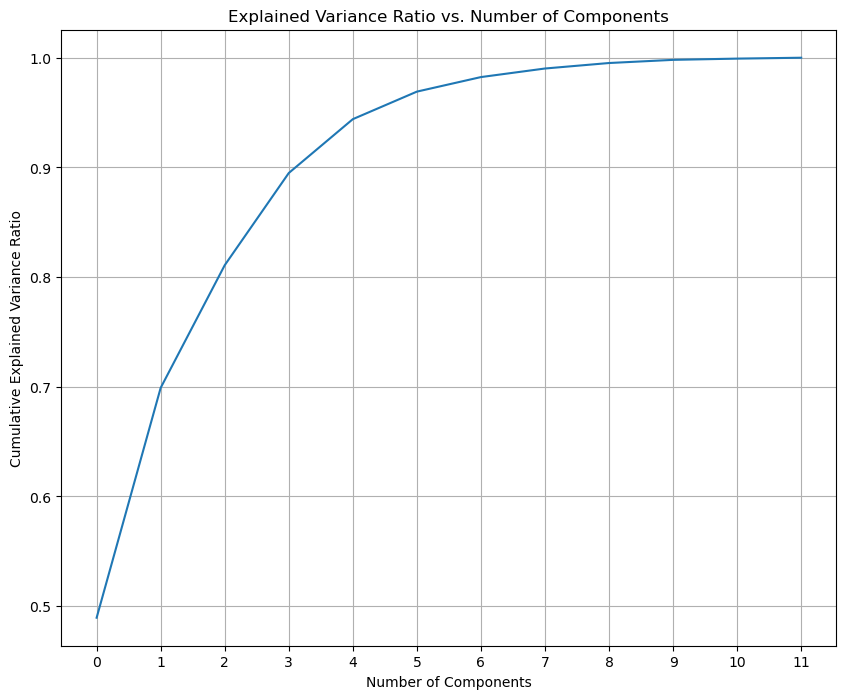

6

In [101]:
plotPCA(green_surroundings, 0.95)

In [102]:
green_pca_invst = pca_df(6, green_surroundings, 'green')

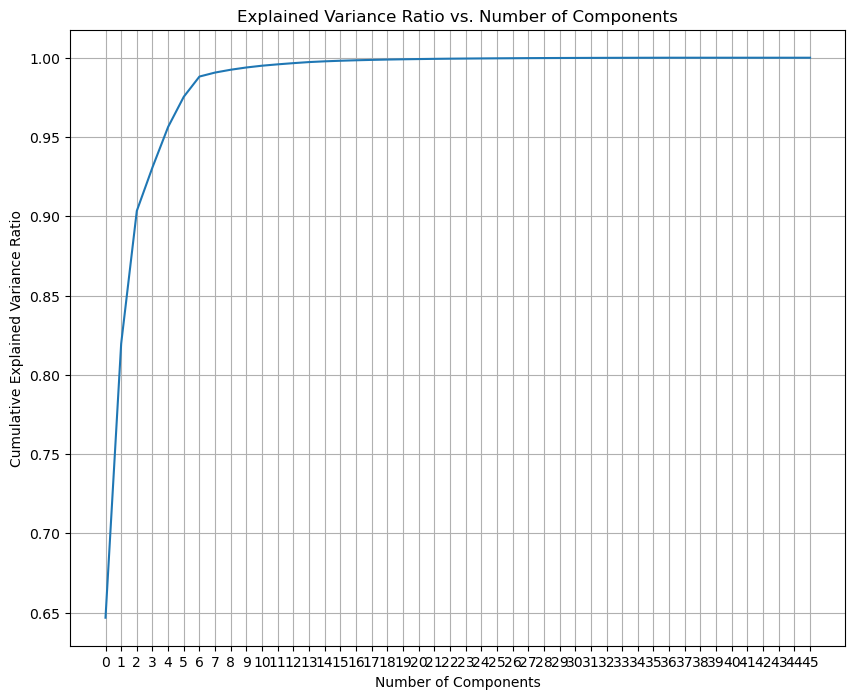

5

In [103]:
plotPCA(cafe_surroundings, 0.95)

In [104]:
cafe_pca_invst = pca_df(5, cafe_surroundings, 'cafe')

### Distances PCA

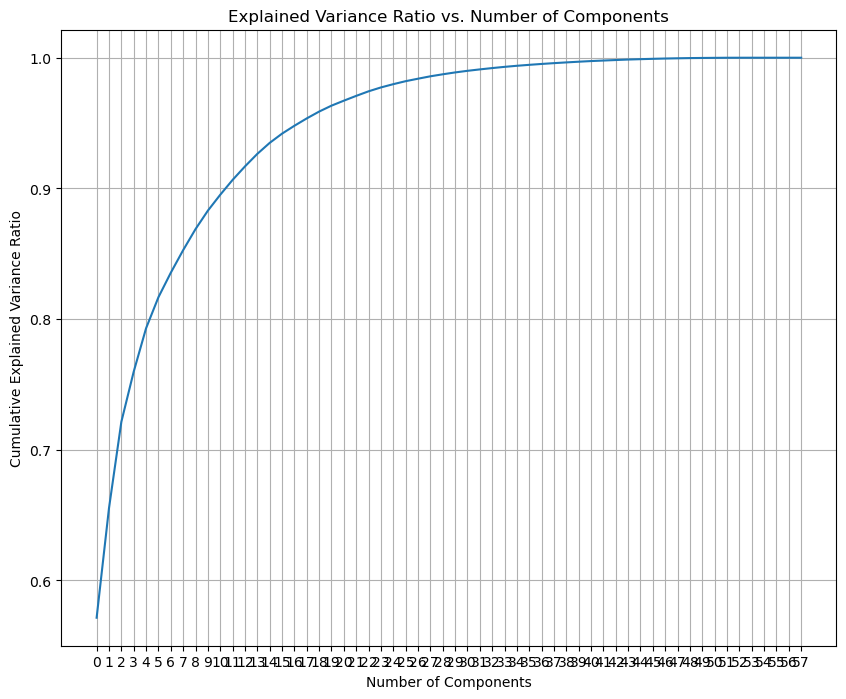

18

In [105]:
distances = groups_floats['distances']

plotPCA(distances, 0.95)

In [106]:
distances_pca_invst = pca_df(18,distances, 'distances')

### Demographics PCA

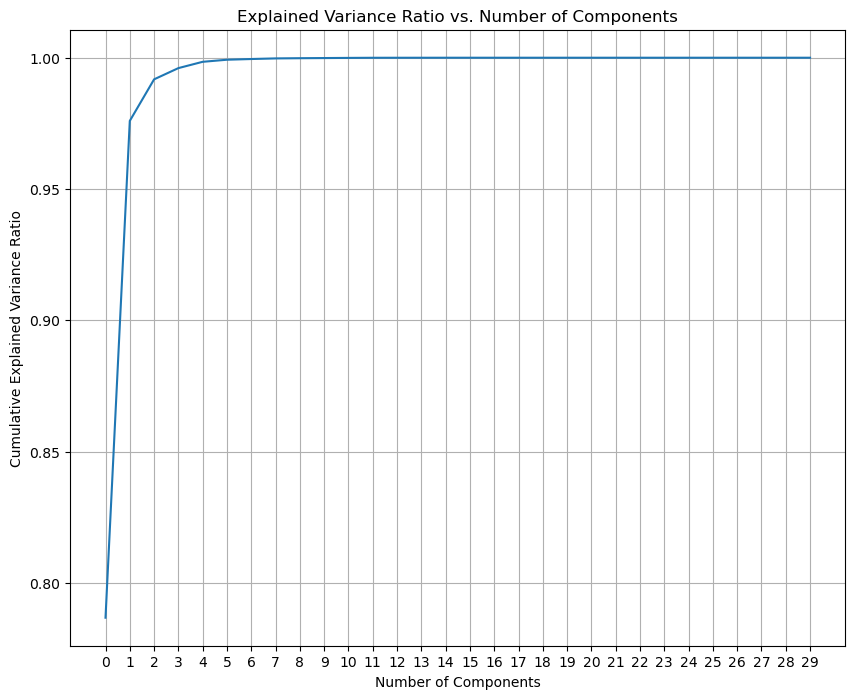

2

In [107]:
demographics = groups_floats['demographics']
plotPCA(demographics, 0.95)

In [108]:
demographics_pca_invst = pca_df(2,demographics,'demographic')

In [109]:
# Combine the pca data frames:

# Demographics, Surroundings, Distances
pca_df_inv = pd.concat([cafe_pca_invst, green_pca_invst, demographics_pca_invst,distances_pca_invst],axis=1)
surr_floats = list(groups_dfs['surroundings'].select_dtypes("float64").columns)
demographics = list(groups_dfs['demographics'].filter(like='dens').columns)
distances = list(groups_dfs['distances'].select_dtypes('float64').columns)
new_inv = investment.drop(columns=surr_floats+demographics+distances).reset_index(drop=True)
new_inv[pca_df_inv.columns] = pca_df_inv

## OwnerOcuppier

### Surroundings PCA

We've separated the surroundings into 2 sub groups:

1. Green + Prom
2. Cafe

Then we have applied PCA to reduce the correlation within each group.

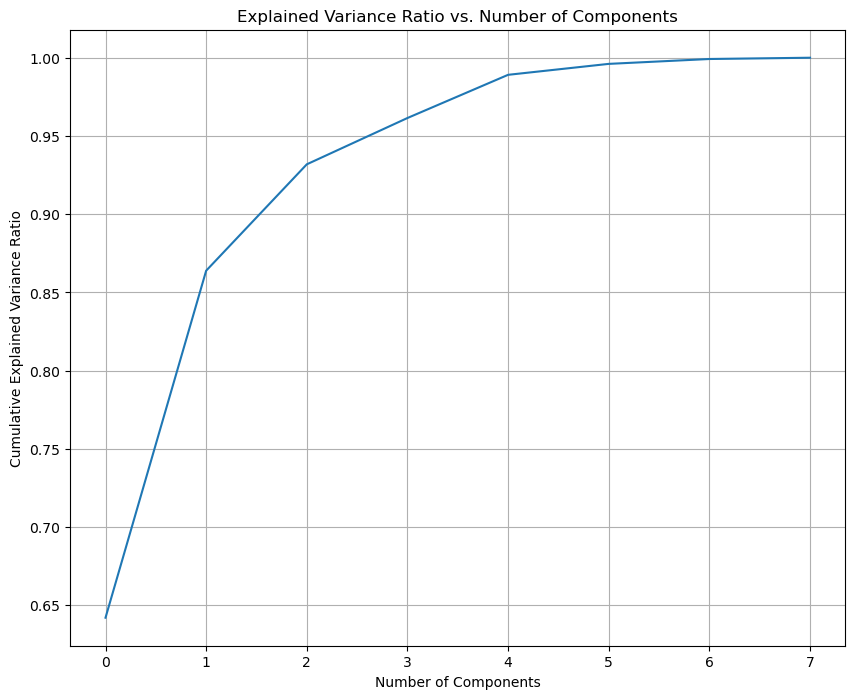

4

In [110]:
plotPCA(green_prom_ocu, 0.95)

In [111]:
green_prom_pca_ocu = pca_df(4, green_prom_ocu, 'green_prom')

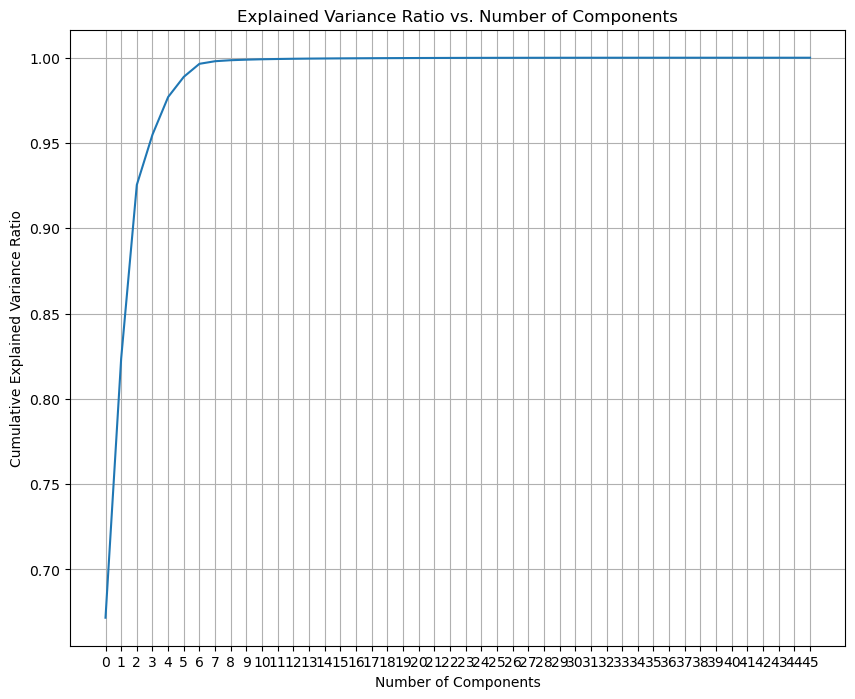

4

In [112]:
plotPCA(cafe_ocu, 0.95)

In [113]:
cafe_ocu_pca = pca_df(4, cafe_ocu, 'cafe')

### Distances PCA

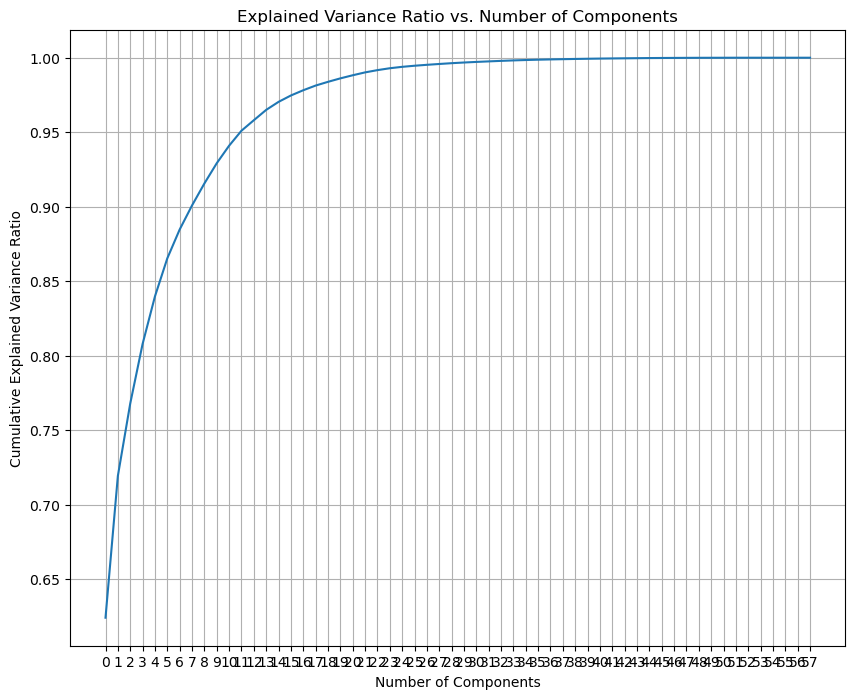

12

In [114]:
distances_ocu = ocuppier[groups_dfs['distances'].columns].select_dtypes('float64')

plotPCA(distances_ocu, 0.95)

In [115]:
distances_pca_ocu = pca_df(12,distances_ocu, 'distances')

### Demographics PCA

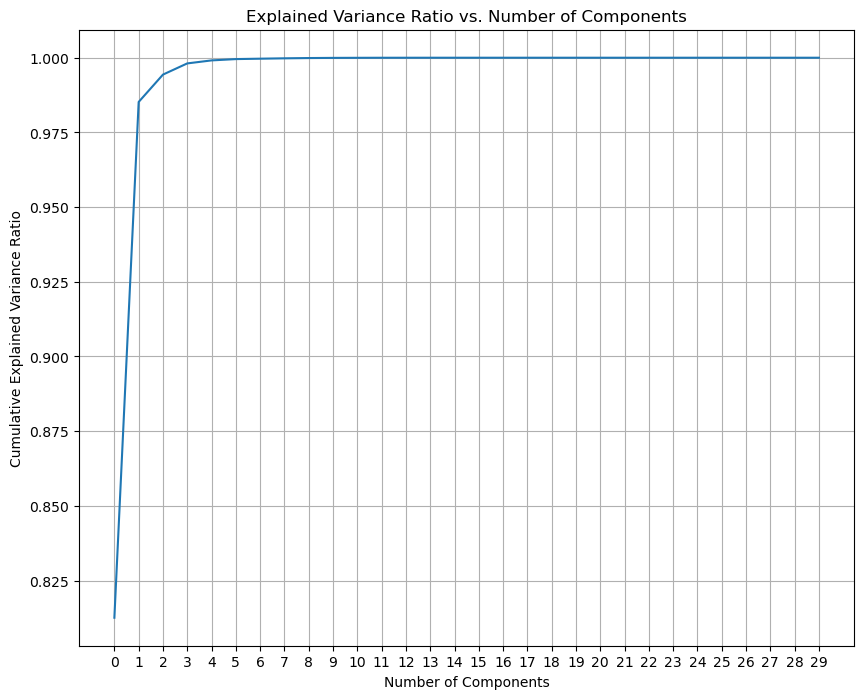

2

In [116]:
demographics_ocu = ocuppier[groups_dfs['demographics'].filter(like='dens').columns]
plotPCA(demographics_ocu, 0.95)

In [117]:
demographics_pca_ocu = pca_df(2,demographics_ocu,'demographic')

In [118]:
# Combine the pca data frames:

# Demographics, Surroundings, Distances

pca_df_ocu = pd.concat([cafe_ocu_pca, green_prom_pca_ocu, demographics_pca_ocu,distances_pca_ocu],axis=1)
surr_floats = list(groups_dfs['surroundings'].select_dtypes("float64").columns)
demographics = list(groups_dfs['demographics'].filter(like='dens').columns)
distances = list(groups_dfs['distances'].select_dtypes('float64').columns)
new_ocu = ocuppier.drop(columns=surr_floats+demographics+distances).reset_index(drop=True)
new_ocu[pca_df_ocu.columns] = pca_df_ocu

# Preparing Data For Model Building

In [119]:
# Part 5 
new_inv = new_inv[(new_inv.price_sq <= 600000) & (new_inv.price_sq >= 10000) | new_inv.price_sq.isnull()] # reduces errors...
new_ocu = new_ocu[(new_ocu.price_sq <= 600000) & (new_ocu.price_sq >= 10000) | new_ocu.price_sq.isnull()] # reduces errors...

## Investment

Before building and tuning the models we first need to handle some bad prices values in our investment data. 

RECALL:

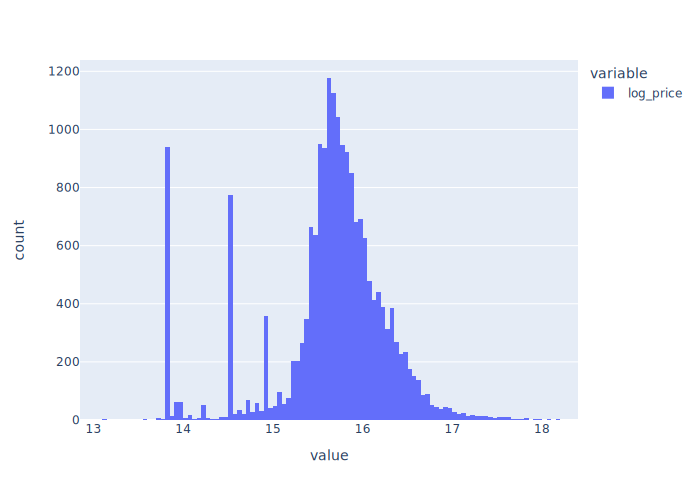

In [120]:
px.histogram(new_inv['log_price'])

Bad Values:

1. 14.9 - 14.95
2. 14.5 - 14.55
3. 13.8 - 13.85


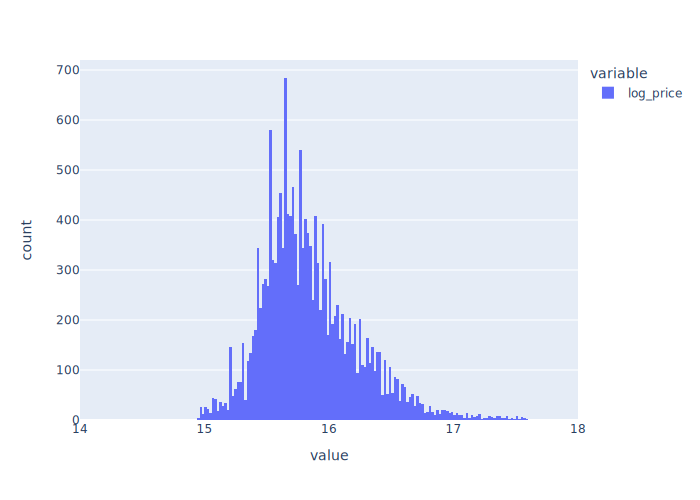

In [121]:
fig = px.histogram(new_inv[~(((new_inv['log_price']>=12) & (new_inv['log_price'] <= 14.95)) | (new_inv['log_price'] > 17.6))]['log_price'])
fig.update_layout(xaxis_range = [14,18])

Seems a little bit better...

In [122]:
inv = new_inv[~(((new_inv['log_price']>=12) & (new_inv['log_price'] <= 14.95)) | (new_inv['log_price'] > 17.6))].set_index('timestamp').drop(columns = 'id')

In [123]:
cat = inv.select_dtypes('object').columns
inv[cat] = inv[cat].astype('int')
response_vars = inv.columns[inv.columns.isin(['price_doc','price_sq','log_price'])] # get response variables
inv_response_values = inv[inv.columns[inv.columns.isin(response_vars)]]
inv_features = inv[inv.columns[~inv.columns.isin(inv_response_values.columns)]] # get features

## OwnerOcuppier

In [124]:
cat = new_ocu.select_dtypes('object').columns
new_ocu[cat] = new_ocu[cat].astype('int')
ocu = new_ocu.set_index('timestamp').drop(columns = 'id')
response_vars = ocu.columns[ocu.columns.isin(['price_doc','price_sq','log_price'])] # get response variables
ocu_response_values = ocu[ocu.columns[ocu.columns.isin(response_vars)]]
ocu_features = ocu[ocu.columns[~ocu.columns.isin(ocu_response_values.columns)]] # get features

In [125]:
# Splitting data - train.csv, test.csv
ocu_test = ocu[ocu.price_doc.isnull()].drop(columns=ocu_response_values.columns)
inv_test = inv[inv.price_doc.isnull()].drop(columns=inv_response_values.columns)
ocu_train = ocu[~ocu.price_doc.isnull()]
inv_train = inv[~inv.price_doc.isnull()]

In [126]:
#  Get response variables values
ocu_price = ocu_train.price_doc
ocu_logprice = ocu_train.log_price
ocu_pricesq = ocu_train.price_sq

inv_price = inv_train.price_doc
inv_logprice = inv_train.log_price
inv_pricesq = inv_train.price_sq

In [127]:
final_ocu_train = ocu_train.drop(columns = ['price_doc','log_price','price_sq'])
final_inv_train = inv_train.drop(columns = ['price_doc','log_price','price_sq'])

In [128]:
from_float_to_int = ['material','state','build_year','floor','max_floor','num_room','hospital_beds_raion','floor_from_top','building_age'] + list(groups_dfs['buildings'].columns) + list(full_data.filter(like='missing').columns)

In [129]:
final_inv_train[from_float_to_int] = final_inv_train[from_float_to_int].astype(int)
final_ocu_train[from_float_to_int] = final_ocu_train[from_float_to_int].astype(int)

# Model Building and Hyperparameter Tuning


There are several methods for hyperparameter tuning so in order to choose which method to use we read about the ones we know. While researching for reading materials we encountered bayesian optimization method for tuning. [(Putatunda, S. et al)](https://dl.acm.org/doi/abs/10.1145/3297067.3297080) Showed that hyperopt (a library for bayesian optimization in python)  gave the best results in terms of time complexitiy and minimizing the loss function compared to random seach and grid search thus we decided to use it in our project as well.

In [238]:
def trainTestSplit(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=22)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=22)
    return x_train, x_val, x_test, y_train, y_val, y_test

In [239]:
ocu_x_train, ocu_x_val, ocu_x_test, ocu_y_train, ocu_y_val, ocu_y_test = trainTestSplit(final_ocu_train, ocu_logprice)
inv_x_train, inv_x_val, inv_x_test, inv_y_train, inv_y_val, inv_y_test = trainTestSplit(final_inv_train, inv_logprice)

In [240]:
def plotImportance(n_features, importance, features, model,Product):
    sorted_imp = importance.argsort()[::-1]
    df_imp = pd.DataFrame(dict(features = features[sorted_imp], imp = importance[sorted_imp]))
    fig = px.bar(df_imp[:n_features], y='features', x='imp')
    fig.update_layout(title = f'Feature Importance - {model} {Product}')
    fig.show()
    print(features[importance.argmax()])

## XGBoost


We created an objective function for each type of apartments.

In [241]:
def xgb_inv_tuning_allfeatures(parameters):
    model = XGBRegressor(**parameters)
    evaluation = [(inv_x_train,inv_y_train),(inv_x_val, inv_y_val)]
    model.fit(inv_x_train,inv_y_train,eval_set=evaluation,verbose=False)
    preds = model.predict(inv_x_val)
    rmse = mean_squared_error(inv_y_val, preds, squared=False)
    print("Score:",rmse)
    return {'loss':rmse,'status':STATUS_OK,'model':model}

In [242]:
def xgb_ocu_tuning_allfeatures(parameters):
    model = XGBRegressor(**parameters)
    evaluation = [(ocu_x_train,ocu_y_train),(ocu_x_val, ocu_y_val)]
    model.fit(ocu_x_train, ocu_y_train,eval_set=evaluation,verbose=False)
    preds = model.predict(ocu_x_val)
    rmse = mean_squared_error(ocu_y_val, preds, squared=False)
    print("Score:",rmse)
    return {'loss':rmse,'status':STATUS_OK,'model':model}

we defined xgboost parameter space as [(Kapoor & Perrone, 2021)](https://arxiv.org/abs/2111.06924) did

In [243]:
xgb_parameters = {'max_depth':hp.randint("max_depth", 2,8),
                  'eta':hp.loguniform('eta',np.log((1/10)**3), np.log(1)),
                  'colsample_bytree': hp.uniform('colsample_bytree',0.3,1),
                  'subsample': hp.uniform('subsample',0.5,1),
                  'reg_lambda': hp.loguniform('reg_lambda',np.log((1/10)**6),np.log(20)),
                  'reg_alpha': hp.loguniform('reg_alpha',np.log((1/10)**6),np.log(20)),
                  'gamma': hp.loguniform('gamma', np.log((1/10)**6),np.log(64)),
                  'n_estimators': hp.randint('n_estimators',100,1024),
                  'eval_metric':'rmse',
                  'objective':'reg:squarederror'
                  }

In [244]:
xgb_trials_ocu = Trials()


In [245]:
xgb_trials_inv = Trials()

In [246]:
xgb_ocu_best_parameters = fmin(
    fn=xgb_ocu_tuning_allfeatures,
    space = xgb_parameters,
    algo=tpe.suggest,
    max_evals = 50,
    trials=xgb_trials_ocu
)

print(xgb_ocu_best_parameters)

Score:                                                                          
0.1058841780318957                                                              
Score:                                                                          
0.11760002354235286                                                             
Score:                                                                          
0.11243087575672941                                                             
Score:                                                                          
0.24060875364947543                                                             
Score:                                                                          
0.24511412104881367                                                             
Score:                                                                          
0.14878641873855952                                                             
Score:                      

In [247]:
best_model_ocu = xgb_trials_ocu.results[np.argmin([r['loss'] for r in xgb_trials_ocu.results if 'loss' in r])]['model'] # gets the best model

In [248]:
top_models = 5 # get the top 5 models... we will use average on the predictions..

In [249]:
top_xgb_ocu = sorted(xgb_trials_ocu.results, key= lambda x: x['loss'] if 'loss' in x else 9999)[:top_models] # gets the top 5 models

In [250]:
xgb_inv_best_parameters = fmin(
    fn=xgb_inv_tuning_allfeatures,
    space = xgb_parameters,
    algo=tpe.suggest,
    max_evals = 50,
    trials=xgb_trials_inv
)

print(xgb_inv_best_parameters)

Score:                                                                          
0.2644836297439095                                                              
Score:                                                                          
0.237984461666739                                                               
Score:                                                                          
0.210273106002578                                                               
Score:                                                                          
0.1913569946088281                                                              
Score:                                                                          
0.20951332148997517                                                             
Score:                                                                          
0.28066070348554417                                                             
Score:                      

Score:                                                                          
0.19445228859836627                                                             
Score:                                                                          
0.19794270711307135                                                             
Score:                                                                          
0.19028979628278397                                                             
Score:                                                                          
0.22037142354119835                                                             
Score:                                                                          
0.19148575567196613                                                             
Score:                                                                          
0.19284961295365233                                                             
Score:                      

In [251]:
best_model_inv = xgb_trials_inv.results[np.argmin([r['loss'] for r in xgb_trials_inv.results if 'loss' in r ])]['model']

In [252]:
top_xgb_inv = sorted(xgb_trials_inv.results, key= lambda x: x['loss'] if 'loss' in x else 9999)[:top_models]

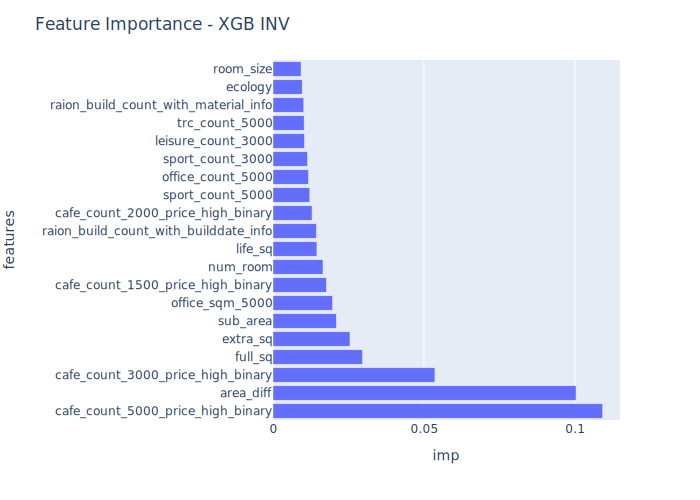

cafe_count_5000_price_high_binary


In [253]:
plotImportance(n_features=20, importance=best_model_inv.feature_importances_, features=inv_x_train.columns, model="XGB", Product="INV")

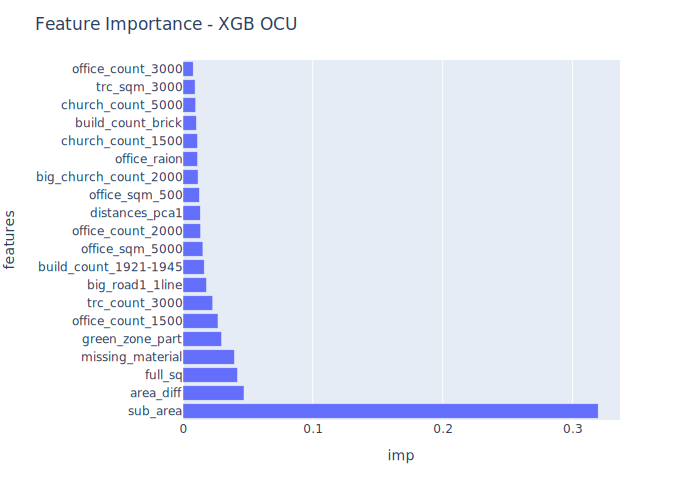

sub_area


In [254]:
plotImportance(n_features=20, importance=best_model_ocu.feature_importances_, features= ocu_x_train.columns, model="XGB", Product="OCU")

## Random Forest


In [255]:
rf_parameters = {
    'n_estimators': hp.choice('n_estimators', np.arange(50,1050,50)),
    'max_features':hp.choice('max_features', ['log2','sqrt']),
    'criterion': hp.choice('criterion', ['friedman_mse', 'squared_error']),
    'max_depth': scope.int(hp.uniform('max_depth', 5,20)),
    'max_samples': hp.uniform('max_samples', 0,0.8),
    'min_samples_leaf': scope.int(hp.uniform('min_samples_leaf',1,5)),
    'min_samples_split': scope.int(hp.uniform('min_samples_split',2,6))
}

In [256]:
def rf_inv_tuning_allfeatures(parameters):
    model = RandomForestRegressor(**parameters)
    model.fit(inv_x_train,inv_y_train)
    preds = model.predict(inv_x_val)
    rmse = mean_squared_error(inv_y_val, preds, squared=False)
    print("Score:",rmse)
    return {'loss':rmse,'status':STATUS_OK,'model':model}

In [257]:
def rf_ocu_tuning_allfeatures(parameters):
    model = RandomForestRegressor(**parameters)
    model.fit(ocu_x_train, ocu_y_train)
    preds = model.predict(ocu_x_val)
    rmse = mean_squared_error(ocu_y_val, preds, squared=False)
    print("Score:",rmse)
    return {'loss':rmse,'status':STATUS_OK,'model':model}

In [258]:
rf_trials_inv = Trials()

In [259]:
rf_inv_best_parameters = fmin(
    fn=rf_inv_tuning_allfeatures,
    space = rf_parameters,
    algo=tpe.suggest,
    max_evals = 20,
    trials=rf_trials_inv
)
print(rf_inv_best_parameters)

Score:                                                                          
0.22299355804043655                                                             
Score:                                                                          
0.25935196368644237                                                             
Score:                                                                          
0.21612811558531436                                                             
Score:                                                                          
0.2089327336511747                                                              
Score:                                                                          
0.26499524273401126                                                             
Score:                                                                          
0.20532434921530165                                                             
Score:                      

In [260]:
rf_trials_ocu = Trials()

In [261]:
rf_ocu_best_parameters = fmin(
    fn=rf_ocu_tuning_allfeatures,
    space = rf_parameters,
    algo=tpe.suggest,
    max_evals = 20,
    trials=rf_trials_ocu
)
print(rf_ocu_best_parameters)

Score:                                                                          
0.18007082690660559                                                             
Score:                                                                          
0.18707279774761876                                                             
Score:                                                                          
0.19483020273773885                                                             
Score:                                                                          
0.1329407121782871                                                              
Score:                                                                          
0.1498122550728186                                                              
Score:                                                                          
0.15415476376610596                                                             
Score:                      

In [262]:
best_rf_ocu = rf_trials_ocu.results[np.argmin([r['loss'] for r in rf_trials_ocu.results if 'loss' in r])]['model']
best_rf_inv = rf_trials_inv.results[np.argmin([r['loss'] for r in rf_trials_inv.results if 'loss' in r])]['model']

top5_rf_ocu = sorted(rf_trials_ocu.results, key= lambda x: x['loss'] if 'loss' in x else 9999)[:top_models]
top5_rf_inv = sorted(rf_trials_inv.results, key= lambda x: x['loss'] if 'loss' in x else 9999)[:top_models]

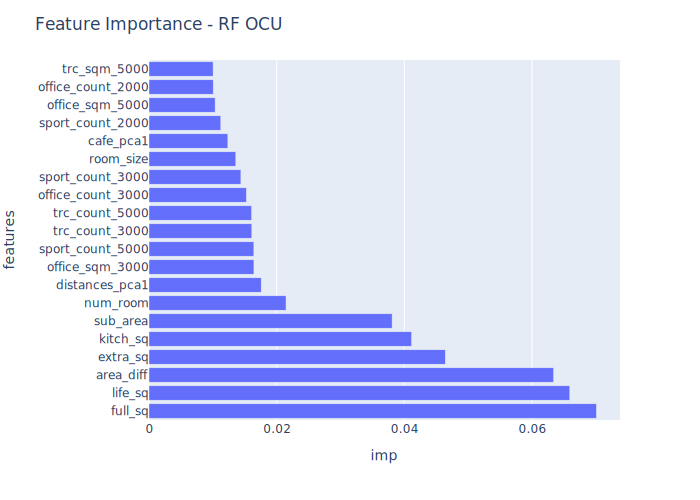

full_sq


In [263]:
plotImportance(n_features=20, importance=best_rf_ocu.feature_importances_, features=ocu_x_train.columns, model="RF", Product="OCU")

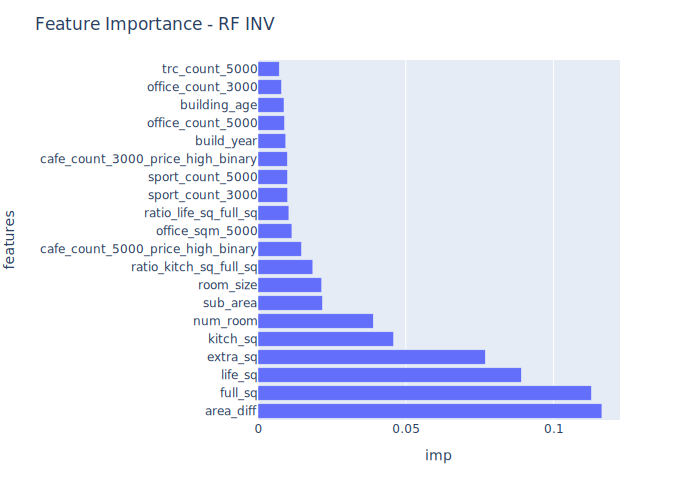

area_diff


In [264]:
plotImportance(n_features=20, importance=best_rf_inv.feature_importances_, features=inv_x_train.columns, model="RF", Product="INV")

## Test Predictions

In [265]:
inv_xgb_testpreds = best_model_inv.predict(inv_x_test)
inv_rf_testpreds = best_rf_inv.predict(inv_x_test)

ocu_xgb_testpreds = best_model_ocu.predict(ocu_x_test)
ocu_rf_testpreds = best_rf_ocu.predict(ocu_x_test)

test_inv_preds = pd.DataFrame(dict(year = inv_x_test.year,quarter = inv_x_test.quarter,xgb = np.expm1(inv_xgb_testpreds), rf=np.expm1(inv_rf_testpreds),true = np.expm1(inv_y_test)))
#test_inv_preds = pd.DataFrame(dict(year = inv_x_test.year,quarter = inv_x_test.quarter,xgb = inv_xgb_testpreds*inv_x_test['full_sq'], rf= inv_rf_testpreds*inv_x_test['full_sq'], true = inv_y_test*inv_x_test['full_sq']))
test_ocu_preds = pd.DataFrame(dict(year = ocu_x_test.year, quarter = ocu_x_test.quarter, xgb = np.expm1(ocu_xgb_testpreds) ,rf=np.expm1(ocu_rf_testpreds), true = np.expm1(ocu_y_test)))

In [266]:
q = test_inv_preds.groupby(['year','quarter'])
q2 = test_ocu_preds.groupby(['year','quarter'])

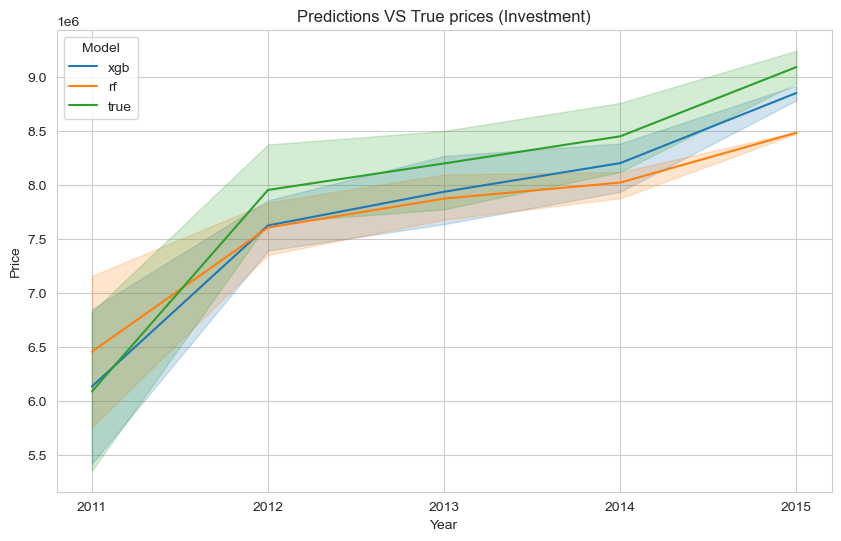

In [267]:
melted_q = q.mean().reset_index().melt(id_vars='year',var_name='model', value_name='prediction')
melted_q['year'] = melted_q['year'].apply(lambda year: str(year))
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the lines for different models
sns.lineplot(data=melted_q[melted_q['model'] !='quarter'], x='year', y='prediction', hue='model')

plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Predictions VS True prices (Investment)')

plt.legend(title='Model')
plt.show()

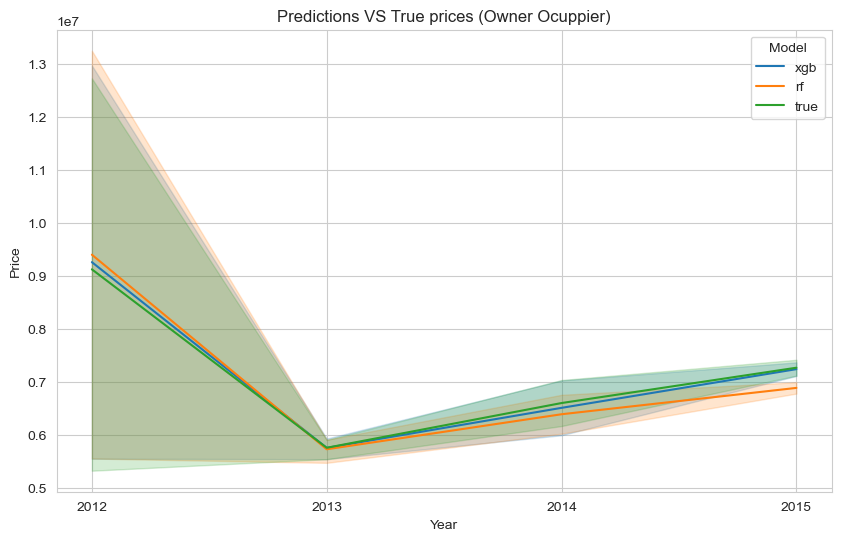

In [268]:
melted_q2 = q2.mean().reset_index().melt(id_vars='year',var_name='model', value_name='prediction')
melted_q2['year'] = melted_q2['year'].apply(lambda year: str(year))
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the lines for different models
sns.lineplot(data=melted_q2[melted_q2['model'] !='quarter'], x='year', y='prediction', hue='model')

plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Predictions VS True prices (Owner Ocuppier)')

plt.legend(title='Model')
plt.show()

It seems that for both xgboost and random forest models it's easier to predict the prices for the Owner Ocuppier product type. 

XGboost - Give better results in both cases. 



XGBoost - Builds trees sequentially, optimize a specific objective function.

Random Forest - builds trees independently with no interaction between them.

The sequential nature of xgboost allows it to learn complex patterns as the current tree learns from previous trees mistakes (reduces bias but prone to overfitting) while random forest may capture different pattern due to the randomness during the training phase. 

As mentioned above, random forest builds trees independently where each of the trees learn a certain part of the data and at the end the predictions are summarized using average. This method reduces the variance of the model and allows a better generalization to unseen data.

So we believe that the difference between the two models predictions is probably because xgboost can learn complex patterns while a bagging ensemble model (random forest) is good when the model has low bias already. 

Though XGBOOST predictions seem to be a little better, we still wanted to try and ensemble them.

# XGBoost without Hyper Tuning

Though hyper parameter tuning algorithm can help get better results we decided to try choosing the right parameters ourselves. We did some research online, and decided to create 5 parameters sets so we ended up having 5 xgboost models for each product type.

In [130]:
import xgboost as xgb
def no_tune_train(params, x_train,y_train):
    dtrain = xgb.DMatrix(x_train, y_train)

    boosts = xgb.cv(params, dtrain, num_boost_round = 10000, verbose_eval = 100, early_stopping_rounds = 50)

    xgb_model = xgb.train(params, dtrain,num_boost_round=len(boosts))
    return xgb_model

## Log Price

In [270]:
ocu_xgb_no_tune_params1 = {
    'subsample':0.7,
    'max_depth': 4,
    'colsample_bytree':0.7,
    'lambda': 200,
    'alpha':8,
    'eta': 0.05
}
ocu_xgb_no_tune_params2 = {
    'subsample':1,
    'max_depth':4,
    'colsample_bytree':0.7,
    'lambda': 200,
    'alpha':8,
    'eta':0.05
}

ocu_xgb_no_tune_params3 = {
    'subsample':1,
    'max_depth':4,
    'colsample_bytree':1,
    'lambda': 200,
    'alpha':8,
    'eta':0.05,
    'nthread':8
}

ocu_xgb_no_tune_params4 = {
    'subsample':0.9,
    'max_depth':4,
    'colsample_bytree':0.7,
    'lambda': 200,
    'alpha':8,
    'eta':0.05
}

ocu_xgb_no_tune_params5 = {
    'subsample':0.8,
    'max_depth':7,
    'colsample_bytree':0.7,
    'lambda': 200,
    'alpha':8,
    'eta':0.05
}
ocu_notue_xgb1 = no_tune_train(params=ocu_xgb_no_tune_params1, x_train=final_ocu_train,y_train=ocu_train.log_price)
ocu_notue_xgb2 = no_tune_train(params=ocu_xgb_no_tune_params2, x_train=final_ocu_train,y_train=ocu_train.log_price)
ocu_notue_xgb3 = no_tune_train(params=ocu_xgb_no_tune_params3, x_train=final_ocu_train,y_train=ocu_train.log_price)
ocu_notue_xgb4 = no_tune_train(params=ocu_xgb_no_tune_params4, x_train=final_ocu_train,y_train=ocu_train.log_price)
ocu_notue_xgb5 = no_tune_train(params=ocu_xgb_no_tune_params5, x_train=final_ocu_train,y_train=ocu_train.log_price)


[0]	train-rmse:0.43817+0.00228	test-rmse:0.43827+0.00482
[100]	train-rmse:0.15363+0.00092	test-rmse:0.16070+0.00237
[200]	train-rmse:0.13024+0.00113	test-rmse:0.14034+0.00156
[300]	train-rmse:0.12142+0.00133	test-rmse:0.13335+0.00159
[400]	train-rmse:0.11649+0.00152	test-rmse:0.12965+0.00158
[500]	train-rmse:0.11323+0.00163	test-rmse:0.12726+0.00158
[600]	train-rmse:0.11071+0.00168	test-rmse:0.12545+0.00170
[700]	train-rmse:0.10888+0.00170	test-rmse:0.12425+0.00172
[800]	train-rmse:0.10744+0.00173	test-rmse:0.12330+0.00187
[900]	train-rmse:0.10623+0.00173	test-rmse:0.12252+0.00191
[1000]	train-rmse:0.10515+0.00172	test-rmse:0.12179+0.00200
[1100]	train-rmse:0.10424+0.00173	test-rmse:0.12121+0.00206
[1200]	train-rmse:0.10349+0.00176	test-rmse:0.12071+0.00210
[1300]	train-rmse:0.10280+0.00174	test-rmse:0.12031+0.00212
[1400]	train-rmse:0.10219+0.00175	test-rmse:0.11994+0.00218
[1500]	train-rmse:0.10166+0.00172	test-rmse:0.11967+0.00220
[1600]	train-rmse:0.10120+0.00169	test-rmse:0.11941+

[5500]	train-rmse:0.09637+0.00157	test-rmse:0.11706+0.00300
[5600]	train-rmse:0.09631+0.00157	test-rmse:0.11703+0.00300
[5700]	train-rmse:0.09626+0.00155	test-rmse:0.11699+0.00302
[5800]	train-rmse:0.09621+0.00154	test-rmse:0.11697+0.00303
[5900]	train-rmse:0.09616+0.00155	test-rmse:0.11694+0.00303
[6000]	train-rmse:0.09611+0.00155	test-rmse:0.11692+0.00304
[6100]	train-rmse:0.09607+0.00156	test-rmse:0.11690+0.00304
[6200]	train-rmse:0.09601+0.00156	test-rmse:0.11686+0.00304
[6300]	train-rmse:0.09595+0.00156	test-rmse:0.11684+0.00304
[6400]	train-rmse:0.09590+0.00156	test-rmse:0.11681+0.00304
[6500]	train-rmse:0.09586+0.00156	test-rmse:0.11680+0.00305
[6600]	train-rmse:0.09582+0.00155	test-rmse:0.11677+0.00306
[6700]	train-rmse:0.09578+0.00154	test-rmse:0.11675+0.00307
[6800]	train-rmse:0.09573+0.00155	test-rmse:0.11674+0.00307
[6900]	train-rmse:0.09570+0.00155	test-rmse:0.11671+0.00307
[7000]	train-rmse:0.09566+0.00155	test-rmse:0.11670+0.00306
[7100]	train-rmse:0.09563+0.00154	test-r

In [271]:
inv_xgb_no_tune_params1 = {
    'subsample':0.7,
    'max_depth': 4,
    'colsample_bytree':0.6,
    'lambda': 100,
    'alpha':8,
    'eta': 0.05
}
inv_xgb_no_tune_params2 = {
    'subsample':1,
    'max_depth':4,
    'colsample_bytree':0.5,
    'lambda': 100,
    'alpha':8,
    'eta':0.05
}

inv_xgb_no_tune_params3 = {
    'subsample':1,
    'max_depth':4,
    'colsample_bytree':1,
    'lambda': 100,
    'alpha':8,
    'eta':0.05
}

inv_xgb_no_tune_params4 = {
    'subsample':0.9,
    'max_depth':4,
    'colsample_bytree':0.8,
    'lambda': 100,
    'alpha':8,
    'eta':0.05
}

inv_xgb_no_tune_params5 = {
    'subsample':0.7,
    'max_depth':6,
    'colsample_bytree':1,
    'lambda': 100,
    'alpha':8,
    'eta':0.05
}


inv_notue_xgb1 = no_tune_train(params=inv_xgb_no_tune_params1, x_train=final_inv_train,y_train=inv_train.log_price)
inv_notue_xgb2 = no_tune_train(params=inv_xgb_no_tune_params2, x_train=final_inv_train,y_train=inv_train.log_price)
inv_notue_xgb3 = no_tune_train(params=inv_xgb_no_tune_params3, x_train=final_inv_train,y_train=inv_train.log_price)
inv_notue_xgb4 = no_tune_train(params=inv_xgb_no_tune_params4, x_train=final_inv_train,y_train=inv_train.log_price)
inv_notue_xgb5 = no_tune_train(params=inv_xgb_no_tune_params5, x_train=final_inv_train,y_train=inv_train.log_price)


[0]	train-rmse:0.37664+0.00145	test-rmse:0.37672+0.00315
[100]	train-rmse:0.19010+0.00260	test-rmse:0.19851+0.00594
[200]	train-rmse:0.17815+0.00263	test-rmse:0.19003+0.00638
[300]	train-rmse:0.17254+0.00256	test-rmse:0.18758+0.00650
[400]	train-rmse:0.16838+0.00252	test-rmse:0.18633+0.00642
[500]	train-rmse:0.16497+0.00249	test-rmse:0.18569+0.00646
[600]	train-rmse:0.16198+0.00244	test-rmse:0.18511+0.00644
[700]	train-rmse:0.15934+0.00238	test-rmse:0.18488+0.00639
[800]	train-rmse:0.15695+0.00237	test-rmse:0.18468+0.00637
[900]	train-rmse:0.15475+0.00242	test-rmse:0.18445+0.00633
[1000]	train-rmse:0.15270+0.00241	test-rmse:0.18428+0.00632
[1051]	train-rmse:0.15171+0.00240	test-rmse:0.18428+0.00632
[0]	train-rmse:0.37625+0.00147	test-rmse:0.37639+0.00313
[100]	train-rmse:0.18728+0.00264	test-rmse:0.19715+0.00600
[200]	train-rmse:0.17591+0.00280	test-rmse:0.18924+0.00620
[300]	train-rmse:0.17054+0.00273	test-rmse:0.18692+0.00619
[400]	train-rmse:0.16648+0.00275	test-rmse:0.18581+0.00614

## Price SQ

In [147]:
ocu_xgb_no_tune_params1 = {
    'subsample':0.7,
    'max_depth': 9,
    'colsample_bytree':0.7,
    'lambda': 200,
    'eta': 0.1,
    'nthread':8
}

ocu_xgb_no_tune_params2 = {
    'subsample':1,
    'max_depth':9,
    'colsample_bytree':0.7,
    'lambda': 200,
    'eta':0.1,
    'nthread':8
}

ocu_xgb_no_tune_params3 = {
    'subsample':1,
    'max_depth':9,
    'colsample_bytree':1,
    'lambda': 200,
    'eta':0.1,
    'nthread':8
}

ocu_xgb_no_tune_params4 = {
    'subsample':0.9,
    'max_depth':7,
    'colsample_bytree':0.7,
    'lambda': 200,
    'eta':0.1,
    'nthread':8
}

ocu_xgb_no_tune_params5 = {
    'subsample':0.8,
    'max_depth':5,
    'colsample_bytree':0.7,
    'lambda': 200,
    'eta':0.1,
    'nthread':8
}

ocu_xgb_no_tune_params5 = {
    'subsample':0.8,
    'max_depth':5,
    'colsample_bytree':0.7,
    'lambda': 200,
    'eta':0.1,
    'nthread':8
}


ocu_pricesq_xgb1 = no_tune_train(params=ocu_xgb_no_tune_params1, x_train=final_ocu_train,y_train=ocu_train.price_sq)
ocu_pricesq_xgb2 = no_tune_train(params=ocu_xgb_no_tune_params2, x_train=final_ocu_train,y_train=ocu_train.price_sq)
ocu_pricesq_xgb3 = no_tune_train(params=ocu_xgb_no_tune_params3, x_train=final_ocu_train,y_train=ocu_train.price_sq)
#ocu_pricesq_xgb4 = no_tune_train(params=ocu_xgb_no_tune_params4, x_train=final_ocu_train,y_train=ocu_train.price_sq)
#ocu_pricesq_xgb5 = no_tune_train(params=ocu_xgb_no_tune_params5, x_train=final_ocu_train,y_train=ocu_train.price_sq)


[0]	train-rmse:38484.04351+82.81214	test-rmse:38511.40089+121.35604


[100]	train-rmse:13426.85362+254.17402	test-rmse:16535.86734+652.90802
[200]	train-rmse:10629.67716+240.78336	test-rmse:15394.79994+819.80247
[300]	train-rmse:9027.43355+248.07033	test-rmse:14995.22186+871.75253
[400]	train-rmse:7918.69434+213.82946	test-rmse:14833.17364+834.15515
[500]	train-rmse:7063.36252+178.84266	test-rmse:14738.91645+829.42617
[600]	train-rmse:6344.76561+156.53873	test-rmse:14702.24565+819.33211
[700]	train-rmse:5752.15969+137.10726	test-rmse:14678.04015+820.54702
[800]	train-rmse:5247.29628+130.82079	test-rmse:14662.46412+807.01359
[900]	train-rmse:4815.03619+119.87757	test-rmse:14656.43571+797.33632
[980]	train-rmse:4505.53181+109.98867	test-rmse:14651.93410+791.05719
[0]	train-rmse:38325.34227+82.76809	test-rmse:38361.97021+125.98146
[100]	train-rmse:12264.16324+282.85783	test-rmse:15942.91470+639.86436
[200]	train-rmse:9576.56596+266.79715	test-rmse:14957.27466+752.50615
[300]	train-rmse:7972.91509+90.41686	test-rmse:14661.61716+774.62263
[400]	train-rmse:692

In [141]:
inv_xgb_no_tune_params1 = {
    'subsample':0.7,
    'max_depth': 6,
    'colsample_bytree':0.6,
    'lambda': 8,
    'eta': 0.02,
    'nthread':8
}

inv_xgb_no_tune_params2 = {
    'subsample':0.9,
    'max_depth':6,
    'colsample_bytree':0.5,
    'lambda': 8,
    'eta':0.02,
    'nthread':8
}

inv_xgb_no_tune_params3 = {
    'subsample':1,
    'max_depth':6,
    'colsample_bytree':1,
    'lambda': 8,
    'eta':0.02,
    'nthread':8
}

inv_xgb_no_tune_params4 = {
    'subsample':0.9,
    'max_depth':6,
    'colsample_bytree':0.8,
    'lambda': 8,
    'eta':0.02,
    'nthread':8
}

inv_xgb_no_tune_params5 = {
    'subsample':0.7,
    'max_depth':6,
    'colsample_bytree':1,
    'lambda': 8,
    'eta':0.02,
    'nthread':8
}

inv_pricesq_xgb1 = no_tune_train(params=inv_xgb_no_tune_params1, x_train=final_inv_train,y_train=inv_train.price_sq)
inv_pricesq_xgb2 = no_tune_train(params=inv_xgb_no_tune_params2, x_train=final_inv_train,y_train=inv_train.price_sq)
inv_pricesq_xgb3 = no_tune_train(params=inv_xgb_no_tune_params3, x_train=final_inv_train,y_train=inv_train.price_sq)
inv_pricesq_xgb4 = no_tune_train(params=inv_xgb_no_tune_params4, x_train=final_inv_train,y_train=inv_train.price_sq)
inv_pricesq_xgb5 = no_tune_train(params=inv_xgb_no_tune_params5, x_train=final_inv_train,y_train=inv_train.price_sq)


[0]	train-rmse:40112.21781+175.26007	test-rmse:40151.52418+345.31237


[100]	train-rmse:25711.24004+236.21457	test-rmse:28245.22951+567.98767
[200]	train-rmse:22314.38376+230.34538	test-rmse:26545.31651+658.81802
[300]	train-rmse:20574.14821+220.62122	test-rmse:26043.54682+694.32533
[400]	train-rmse:19272.88465+210.60736	test-rmse:25823.75970+697.74861
[500]	train-rmse:18151.33097+203.38738	test-rmse:25691.44177+702.09002
[600]	train-rmse:17114.23670+173.80141	test-rmse:25608.20154+705.21522
[700]	train-rmse:16176.44440+170.63210	test-rmse:25570.65349+709.45554
[800]	train-rmse:15297.85928+168.02783	test-rmse:25541.02594+713.26550
[900]	train-rmse:14490.24694+154.35175	test-rmse:25520.23765+717.69675
[1000]	train-rmse:13728.23725+151.38681	test-rmse:25513.63791+714.89461
[1007]	train-rmse:13670.34789+151.36641	test-rmse:25511.38387+715.40773
[0]	train-rmse:40104.87528+181.34007	test-rmse:40144.53793+344.42132
[100]	train-rmse:25584.16697+210.08906	test-rmse:28229.89677+546.69327
[200]	train-rmse:22129.89002+238.69873	test-rmse:26539.37626+607.61935
[300]	

## Price Doc

In [274]:
ocu_price_xgb1 = no_tune_train(params=ocu_xgb_no_tune_params1, x_train=final_ocu_train,y_train=ocu_train.price_doc)
ocu_price_xgb2 = no_tune_train(params=ocu_xgb_no_tune_params2, x_train=final_ocu_train,y_train=ocu_train.price_doc)
ocu_price_xgb3 = no_tune_train(params=ocu_xgb_no_tune_params3, x_train=final_ocu_train,y_train=ocu_train.price_doc)
ocu_price_xgb4 = no_tune_train(params=ocu_xgb_no_tune_params4, x_train=final_ocu_train,y_train=ocu_train.price_doc)
ocu_price_xgb5 = no_tune_train(params=ocu_xgb_no_tune_params5, x_train=final_ocu_train,y_train=ocu_train.price_doc)

[0]	train-rmse:3997561.35034+105907.26534	test-rmse:3997081.92588+227108.23764
[100]	train-rmse:1394180.32318+86822.30984	test-rmse:1673751.15972+266801.50298
[200]	train-rmse:1051343.93733+71406.55071	test-rmse:1497363.61191+245541.14749
[300]	train-rmse:869121.88629+62188.59237	test-rmse:1436081.40288+231210.73280
[400]	train-rmse:746920.60417+54914.22926	test-rmse:1407370.71659+222621.85112
[500]	train-rmse:657828.42981+46388.24218	test-rmse:1392457.41027+217308.31632
[600]	train-rmse:587418.87263+38347.58312	test-rmse:1386128.96860+213790.19186
[700]	train-rmse:529879.66017+32439.42607	test-rmse:1380192.71594+212187.48130
[800]	train-rmse:483781.76497+29393.89820	test-rmse:1375431.63458+209616.37949
[900]	train-rmse:443424.80433+25430.11737	test-rmse:1372541.69579+207543.18844
[1000]	train-rmse:407289.65558+22673.81195	test-rmse:1370148.80911+205875.23850
[1100]	train-rmse:375589.71539+19566.97559	test-rmse:1368918.56551+204935.82996
[1200]	train-rmse:349257.13216+15859.37876	test-

In [275]:
inv_price_xgb1 = no_tune_train(params=inv_xgb_no_tune_params1, x_train=final_inv_train,y_train=inv_train.price_doc)
inv_price_xgb2 = no_tune_train(params=inv_xgb_no_tune_params2, x_train=final_inv_train,y_train=inv_train.price_doc)
inv_price_xgb3 = no_tune_train(params=inv_xgb_no_tune_params3, x_train=final_inv_train,y_train=inv_train.price_doc)
inv_price_xgb4 = no_tune_train(params=inv_xgb_no_tune_params4, x_train=final_inv_train,y_train=inv_train.price_doc)
inv_price_xgb5 = no_tune_train(params=inv_xgb_no_tune_params5, x_train=final_inv_train,y_train=inv_train.price_doc)


[0]	train-rmse:4043486.19608+36468.84202	test-rmse:4044329.11215+75340.12220
[100]	train-rmse:2249147.07222+23808.76128	test-rmse:2381206.05804+76191.10618
[200]	train-rmse:1845647.60587+25251.86052	test-rmse:2105554.70170+75403.99085
[300]	train-rmse:1665873.98608+25838.22730	test-rmse:2021312.20021+72613.03314
[400]	train-rmse:1551986.08521+26007.90318	test-rmse:1985194.00300+72208.09522
[500]	train-rmse:1463856.55551+25284.63476	test-rmse:1964009.74085+72673.81490
[600]	train-rmse:1390000.65129+22823.39715	test-rmse:1950926.57437+72698.40867
[700]	train-rmse:1326289.33063+20527.95404	test-rmse:1941020.80665+74043.51078
[800]	train-rmse:1268927.08281+18281.34543	test-rmse:1933900.38222+75395.58635
[900]	train-rmse:1217075.57841+17523.84799	test-rmse:1928562.42327+75680.89146
[1000]	train-rmse:1168848.58893+16602.98446	test-rmse:1924649.44471+75254.87038
[1100]	train-rmse:1125195.02139+17243.66110	test-rmse:1922216.16729+75060.90572
[1200]	train-rmse:1083337.20123+16731.74384	test-rms

## No Tune Top Features Models

In [276]:
def getTopFeatures(model,  n_features=100):
    scores = model.get_score()
    scores_items = scores.items()
    sorted_imp = sorted(list(scores_items), key=lambda x:x[1], reverse=True)
    return [f for f, v in sorted_imp][:n_features]

In [277]:
ocu_topf_xgb1 = no_tune_train(params=ocu_xgb_no_tune_params1, x_train=final_ocu_train[getTopFeatures(ocu_pricesq_xgb1)],y_train=ocu_train.price_sq)
ocu_topf_xgb2 = no_tune_train(params=ocu_xgb_no_tune_params2, x_train=final_ocu_train[getTopFeatures(ocu_pricesq_xgb2)],y_train=ocu_train.price_sq)
ocu_topf_xgb3 = no_tune_train(params=ocu_xgb_no_tune_params3, x_train=final_ocu_train[getTopFeatures(ocu_pricesq_xgb3)],y_train=ocu_train.price_sq)
#ocu_topf_xgb4 = no_tune_train(params=ocu_xgb_no_tune_params4, x_train=final_ocu_train[getTopFeatures(ocu_pricesq_xgb4)],y_train=ocu_train.price_sq)
#ocu_topf_xgb5 = no_tune_train(params=ocu_xgb_no_tune_params5, x_train=final_ocu_train[getTopFeatures(ocu_pricesq_xgb5)],y_train=ocu_train.price_sq)


[0]	train-rmse:38480.25836+81.13618	test-rmse:38509.61063+127.08556
[100]	train-rmse:13450.93157+236.11228	test-rmse:16551.25581+712.61958
[200]	train-rmse:10660.64047+224.24871	test-rmse:15417.84622+891.01862
[300]	train-rmse:9034.54293+216.08831	test-rmse:15002.09528+952.65054
[400]	train-rmse:7923.52501+190.03904	test-rmse:14835.55598+937.81474
[500]	train-rmse:7076.68285+153.40698	test-rmse:14772.91208+929.39184
[600]	train-rmse:6357.57283+124.30423	test-rmse:14746.82396+925.44247
[700]	train-rmse:5760.42348+111.06358	test-rmse:14718.41485+923.41680
[800]	train-rmse:5253.35127+91.99815	test-rmse:14708.35794+914.98522
[900]	train-rmse:4811.45094+81.62272	test-rmse:14703.31453+912.89991
[984]	train-rmse:4491.67784+81.37224	test-rmse:14701.78423+903.22484
[0]	train-rmse:38313.47596+72.78976	test-rmse:38342.36822+144.02281
[100]	train-rmse:12316.29503+250.01243	test-rmse:16048.47925+660.59775
[200]	train-rmse:9512.16455+238.50445	test-rmse:15043.77187+772.75257
[300]	train-rmse:7944.55

In [278]:
inv_topf_xgb1 = no_tune_train(params=inv_xgb_no_tune_params1, x_train=final_inv_train[getTopFeatures(inv_pricesq_xgb1)],y_train=inv_train.price_sq)
inv_topf_xgb2 = no_tune_train(params=inv_xgb_no_tune_params2, x_train=final_inv_train[getTopFeatures(inv_pricesq_xgb2)],y_train=inv_train.price_sq)
inv_topf_xgb3 = no_tune_train(params=inv_xgb_no_tune_params3, x_train=final_inv_train[getTopFeatures(inv_pricesq_xgb3)],y_train=inv_train.price_sq)
inv_topf_xgb4 = no_tune_train(params=inv_xgb_no_tune_params4, x_train=final_inv_train[getTopFeatures(inv_pricesq_xgb4)],y_train=inv_train.price_sq)
inv_topf_xgb5 = no_tune_train(params=inv_xgb_no_tune_params5, x_train=final_inv_train[getTopFeatures(inv_pricesq_xgb5)],y_train=inv_train.price_sq)

[0]	train-rmse:40188.62492+177.40797	test-rmse:40212.88273+347.07107
[100]	train-rmse:28392.54466+216.86992	test-rmse:29643.56770+518.69098
[200]	train-rmse:25253.95135+208.64492	test-rmse:27501.59138+578.58448
[300]	train-rmse:23733.77698+201.55973	test-rmse:26750.27888+614.49033
[400]	train-rmse:22685.10013+211.08082	test-rmse:26393.06148+610.95818
[500]	train-rmse:21798.86978+206.76134	test-rmse:26186.44478+605.41645
[600]	train-rmse:21018.03054+197.75076	test-rmse:26051.76119+599.71006
[700]	train-rmse:20292.82960+190.10698	test-rmse:25961.49427+596.47046
[800]	train-rmse:19624.90386+197.89920	test-rmse:25898.35222+591.47515
[900]	train-rmse:18997.72127+206.65107	test-rmse:25856.91614+594.80101
[1000]	train-rmse:18404.91357+205.97959	test-rmse:25827.42656+596.52622
[1100]	train-rmse:17838.09382+209.15900	test-rmse:25803.19312+608.44313
[1200]	train-rmse:17289.39440+197.81026	test-rmse:25781.71462+618.38652
[1300]	train-rmse:16777.89312+195.15464	test-rmse:25762.74809+619.28543
[140

# Predictions for Kaggle

In [148]:
mn = 84/90
mn_inv =  77/90

## No Tune Price SQ

In [149]:
inv_pricesq_preds = [inv_pricesq_xgb1.predict(xgb.DMatrix(inv_test))*inv_test['full_sq'],
inv_pricesq_xgb2.predict(xgb.DMatrix(inv_test))*inv_test['full_sq'],
inv_pricesq_xgb3.predict(xgb.DMatrix(inv_test))*inv_test['full_sq'],
inv_pricesq_xgb4.predict(xgb.DMatrix(inv_test))*inv_test['full_sq'],
inv_pricesq_xgb5.predict(xgb.DMatrix(inv_test))*inv_test['full_sq']
]


ocu_pricesq_preds = [ocu_pricesq_xgb1.predict(xgb.DMatrix(ocu_test))*ocu_test['full_sq'],
ocu_pricesq_xgb2.predict(xgb.DMatrix(ocu_test))*ocu_test['full_sq'],
ocu_pricesq_xgb3.predict(xgb.DMatrix(ocu_test))*ocu_test['full_sq'],
#ocu_pricesq_xgb4.predict(xgb.DMatrix(ocu_test))*ocu_test['full_sq'],
#ocu_pricesq_xgb5.predict(xgb.DMatrix(ocu_test))*ocu_test['full_sq']
]

In [150]:
# Average/ Median the predictions
ocu_pricesq_preds = np.median(np.array(ocu_pricesq_preds),axis=0)
inv_pricesq_preds = np.median(np.array(inv_pricesq_preds),axis=0)

In [151]:
# Create the data frame of the predictions.
inv_pricesq_notune = pd.DataFrame(dict(id=new_inv[new_inv['price_doc'].isnull()]['id'], price_doc = inv_pricesq_preds*mn_inv))
ocu_pricesq_notune = pd.DataFrame(dict(id=new_ocu[new_ocu['price_doc'].isnull()]['id'], price_doc = ocu_pricesq_preds*mn))
xgb_pricesq_finals = pd.concat([ocu_pricesq_notune,inv_pricesq_notune])

## No Tune Log Price

In [283]:
# Get the predictions for each model
inv_notunepreds = [np.expm1(inv_notue_xgb1.predict(xgb.DMatrix(inv_test))), 
                   np.expm1(inv_notue_xgb2.predict(xgb.DMatrix(inv_test))),
                     np.expm1(inv_notue_xgb3.predict(xgb.DMatrix(inv_test))),
                     np.expm1(inv_notue_xgb4.predict(xgb.DMatrix(inv_test))),
                     np.expm1(inv_notue_xgb5.predict(xgb.DMatrix(inv_test)))]

ocu_notunepreds = [np.expm1(ocu_notue_xgb1.predict(xgb.DMatrix(ocu_test))), 
                   np.expm1(ocu_notue_xgb2.predict(xgb.DMatrix(ocu_test))), 
                   np.expm1(ocu_notue_xgb3.predict(xgb.DMatrix(ocu_test))),
                   np.expm1(ocu_notue_xgb4.predict(xgb.DMatrix(ocu_test))),
                   np.expm1(ocu_notue_xgb5.predict(xgb.DMatrix(ocu_test)))]

In [284]:
# Average the predictions
ocu_notune_preds = np.mean(np.array(ocu_notunepreds),axis=0)
inv_notune_preds = np.mean(np.array(inv_notunepreds),axis=0)

In [285]:
# Create the data frame of the predictions.
inv_xgb_notune = pd.DataFrame(dict(id=new_inv[new_inv['price_doc'].isnull()]['id'], price_doc = inv_notune_preds*mn_inv))
ocu_xgb_notune = pd.DataFrame(dict(id=new_ocu[new_ocu['price_doc'].isnull()]['id'], price_doc = ocu_notune_preds*mn))
xgb_notune_finals = pd.concat([ocu_xgb_notune,inv_xgb_notune])

## No Tune Price Doc

In [286]:
inv_price_preds = [inv_price_xgb1.predict(xgb.DMatrix(inv_test)),
inv_price_xgb2.predict(xgb.DMatrix(inv_test)),
inv_price_xgb3.predict(xgb.DMatrix(inv_test)),
inv_price_xgb4.predict(xgb.DMatrix(inv_test)),
inv_price_xgb5.predict(xgb.DMatrix(inv_test))]


ocu_price_preds = [ocu_price_xgb1.predict(xgb.DMatrix(ocu_test)),
ocu_price_xgb2.predict(xgb.DMatrix(ocu_test)),
ocu_price_xgb3.predict(xgb.DMatrix(ocu_test)),
ocu_price_xgb4.predict(xgb.DMatrix(ocu_test)),
ocu_price_xgb5.predict(xgb.DMatrix(ocu_test))]

In [287]:
# Average the predictions
ocu_price_preds = np.mean(np.array(ocu_price_preds),axis=0)
inv_price_preds = np.mean(np.array(inv_price_preds),axis=0)

In [288]:
# Create the data frame of the predictions.
inv_xgb_price = pd.DataFrame(dict(id=new_inv[new_inv['price_doc'].isnull()]['id'], price_doc = inv_price_preds*mn_inv))
ocu_xgb_price = pd.DataFrame(dict(id=new_ocu[new_ocu['price_doc'].isnull()]['id'], price_doc = ocu_price_preds*mn))
xgb_price_finals = pd.concat([ocu_xgb_price,inv_xgb_price])

## No Tune Top Features Price SQ

In [316]:
inv_topf_preds = [inv_topf_xgb1.predict(xgb.DMatrix(inv_test[getTopFeatures(inv_pricesq_xgb1)]))*inv_test['full_sq'],
inv_topf_xgb2.predict(xgb.DMatrix(inv_test[getTopFeatures(inv_pricesq_xgb2)]))*inv_test['full_sq'],
inv_topf_xgb3.predict(xgb.DMatrix(inv_test[getTopFeatures(inv_pricesq_xgb3)]))*inv_test['full_sq'],
inv_topf_xgb4.predict(xgb.DMatrix(inv_test[getTopFeatures(inv_pricesq_xgb4)]))*inv_test['full_sq'],
inv_topf_xgb5.predict(xgb.DMatrix(inv_test[getTopFeatures(inv_pricesq_xgb5)]))*inv_test['full_sq']]


ocu_topf_preds = [ocu_topf_xgb1.predict(xgb.DMatrix(ocu_test[getTopFeatures(ocu_pricesq_xgb1)]))*ocu_test['full_sq'],
ocu_topf_xgb2.predict(xgb.DMatrix(ocu_test[getTopFeatures(ocu_pricesq_xgb2)]))*ocu_test['full_sq'],
ocu_topf_xgb3.predict(xgb.DMatrix(ocu_test[getTopFeatures(ocu_pricesq_xgb3)]))*ocu_test['full_sq'],
#ocu_topf_xgb4.predict(xgb.DMatrix(ocu_test[getTopFeatures(ocu_pricesq_xgb4)]))*ocu_test['full_sq'],
#ocu_topf_xgb5.predict(xgb.DMatrix(ocu_test[getTopFeatures(ocu_pricesq_xgb5)]))*ocu_test['full_sq']
]

In [317]:
inv_topf_preds = np.mean(np.array(inv_topf_preds),axis=0)
ocu_topf_preds = np.mean(np.array(ocu_topf_preds),axis=0)

In [318]:
inv_xgb_topf= pd.DataFrame(dict(id=new_inv[new_inv['price_doc'].isnull()]['id'], price_doc = inv_topf_preds*mn_inv))
ocu_xgb_topf = pd.DataFrame(dict(id=new_ocu[new_ocu['price_doc'].isnull()]['id'], price_doc = ocu_topf_preds*mn))
xgb_topf_finals = pd.concat([ocu_xgb_topf,inv_xgb_topf])
xgb_topf_finals['price_doc'] = xgb_topf_finals['price_doc']

## Top 5 models - bayesian optimization

In [292]:
top_inv_preds = [np.exp(model['model'].predict(inv_test)) - 1 for model in top_xgb_inv]
top_ocu_preds = [np.exp(model['model'].predict(ocu_test)) - 1 for model in top_xgb_ocu]

top_rf_inv_preds = [np.expm1(model['model'].predict(inv_test)) for model in top5_rf_inv]
top_rf_ocu_preds = [np.expm1(model['model'].predict(ocu_test)) for model in top5_rf_ocu]

In [293]:
top_avg_inv_price = np.array(top_inv_preds).mean(axis=0)
top_avg_ocu_price = np.array(top_ocu_preds).mean(axis=0)

top_avg_inv_rf = np.array(top_rf_inv_preds).mean(axis=0)
top_avg_ocu_rf = np.array(top_rf_ocu_preds).mean(axis=0)

In [294]:
inv_xgb_top = pd.DataFrame(dict(id = new_inv[new_inv['price_doc'].isnull()]['id'], price_doc = top_avg_inv_price*mn_inv))
ocu_xgb_top = pd.DataFrame(dict(id = new_ocu[new_ocu['price_doc'].isnull()]['id'], price_doc = top_avg_ocu_price*mn))
xgb_top_finals = pd.concat([ocu_xgb_top, inv_xgb_top])


inv_rf_top = pd.DataFrame(dict(id = new_inv[new_inv['price_doc'].isnull()]['id'], price_doc = top_avg_inv_rf*mn_inv))
ocu_rf_top = pd.DataFrame(dict(id = new_ocu[new_ocu['price_doc'].isnull()]['id'], price_doc = top_avg_ocu_rf*mn))
rf_top_finals = pd.concat([ocu_rf_top, inv_rf_top])

##  Top 1 Model - bayesian optimization

In [295]:
inv_xgb_preds = np.exp(best_model_inv.predict(inv_test)) - 1
#inv_xgb_preds = np.exp(best_model_inv.predict(inv_test))*inv_test['full_sq']
ocu_xgb_preds = np.exp(best_model_ocu.predict(ocu_test)) - 1


inv_xgb = pd.DataFrame(dict(id = new_inv[new_inv['price_doc'].isnull()]['id'], price_doc = inv_xgb_preds*mn_inv))
#inv_xgb = pd.DataFrame(dict(id=inv_done[inv_done['price_doc'].isnull()]['id'].reset_index(drop=True), price_doc=inv_xgb_preds.reset_index(drop=True)))
ocu_xgb = pd.DataFrame(dict(id = new_ocu[new_ocu['price_doc'].isnull()]['id'], price_doc = ocu_xgb_preds*mn))
xgb_finals = pd.concat([ocu_xgb, inv_xgb])



rf_inv_preds = np.exp(best_rf_inv.predict(inv_test)) - 1
# rf_inv_preds = best_rf_inv.predict(inv_test)*inv_test['full_sq']
rf_ocu_preds = np.exp(best_rf_ocu.predict(ocu_test)) - 1
inv_rf = pd.DataFrame(dict(id = new_inv[new_inv['price_doc'].isnull()]['id'], price_doc = rf_inv_preds*mn_inv))
# inv_rf  =pd.DataFrame(dict(id=inv_done[inv_done['price_doc'].isnull()]['id'].reset_index(drop=True), price_doc=rf_inv_preds.reset_index(drop=True)))
ocu_rf = pd.DataFrame(dict(id = new_ocu[new_ocu['price_doc'].isnull()]['id'], price_doc = rf_ocu_preds*mn))
rf_finals = pd.concat([ocu_rf, inv_rf])

## Ensemble
Top 1 Model - Investment (Bayesian Optimization) , Pricesq Investment Model

For OwnerOcuppier - pricesq model only.

In [313]:
ensemble_inv = pd.DataFrame(dict(id=inv_xgb['id'],price_doc = inv_xgb['price_doc']*0.12 + inv_pricesq_notune['price_doc']*0.88))
ensemble_inv = pd.concat([ocu_pricesq_notune,ensemble_inv])

# Kaggle Submission Files

In [152]:
xgb_pricesq_finals.to_csv("./price_sq_xgb.csv",index=False)

In [314]:
# Ensemble 
ensemble_inv.to_csv("./ensemble_inv_normalocu.csv",index=False)

In [315]:
# Random Forest Predictions
rf_finals.to_csv("./rf_submission.csv", index=False)
# XGboost Predictions
xgb_finals.to_csv("./xgb_submission.csv", index=False)

# # XGboost (without algorithm for tuning)
xgb_notune_finals.to_csv("./xgb_notune.csv", index=False)

# # XGboost (without algorithm for tuning) TOP FEATURES

xgb_topf_finals.to_csv("./xgb_topf_notune.csv", index=False)

# # XGBOOST (without algorithm for tuning) PRICE SQ

xgb_pricesq_finals.to_csv("./price_sq_xgb.csv",index=False)

# # XGboost (without algorithm for tuning) PRICE DOC

xgb_price_finals.to_csv("./price_doc_xgb.csv", index=False)

# Top 5 xgboost models
xgb_top_finals.to_csv("./xgb_top5_submission.csv", index=False)

# Top 5 random forest models
rf_top_finals.to_csv("./rf_top5_submission.csv",index=False)

# # Weighted Average
pd.DataFrame(dict(id=rf_finals['id'], price_doc=(xgb_finals['price_doc']*0.9999999 + rf_finals['price_doc']*0.01))).to_csv("./top1_rf_xgb_ensemble.csv",index=False)
pd.DataFrame(dict(id=xgb_top_finals['id'], price_doc=(xgb_top_finals['price_doc']*0.9999999 + rf_top_finals['price_doc']*0.01))).to_csv("./top5_rf_xgb_ensemble.csv",index=False)
pd.DataFrame(dict(id=xgb_notune_finals['id'], price_doc=xgb_notune_finals['price_doc']*0.9 + xgb_finals['price_doc']*0.1)).to_csv("./xgb_stack_ensemble.csv",index=False)
pd.DataFrame(dict(id=xgb_notune_finals['id'], price_doc=xgb_notune_finals['price_doc']*0.9 + xgb_top_finals['price_doc']*0.1)).to_csv("./xgb_stack_top5_ensemble.csv",index=False)
pd.DataFrame(dict(id=xgb_pricesq_finals['id'], price_doc=xgb_pricesq_finals['price_doc']*0.9+ xgb_notune_finals['price_doc']*(1-0.9))).to_csv("./xgb_pricesq_stack_ensemble.csv",index=False)

#  Bibliography

Kapoor, S., & Perrone, V. (2021). A simple and fast baseline for tuning large XGBoost models. arXiv preprint arXiv:2111.06924.

Putatunda, S., & Rama, K. (2018). A Comparative Analysis of Hyperopt as Against Other Approaches for Hyper-Parameter Optimization of XGBoost. International Conference on Signal Processing and Machine Learning.